## Comparative Bank Case Study


### Configure WRDS Connection

In [22]:
import wrds
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Bank Codes

In [23]:
bank_info = {
    "Citi": 7213,
    "US Bank": 6548,
    "PNC": 6384,
    "Truist": 9846,
    "FifthThird": 6672,
    "Regions": 12368,
    "KeyBank": 17534,
    "Citizens": 57957,
    "Valley": 9396,
    "BankOfHawaii": 18053,
    # optional “run” case studies:
    "SiliconValley": 24735,
    "FirstRepublic": 59017,
}

fdic_certs = list(bank_info.values())
cert_list_sql = ", ".join(str(c) for c in fdic_certs)
cert_list_sql

'7213, 6548, 6384, 9846, 6672, 12368, 17534, 57957, 9396, 18053, 24735, 59017'

## MAIN DATA QUERY

⸻

Call Report–Based Liquidity and Funding Panel

This query constructs a quarterly, bank-level panel from WRDS Call Report data for a single FDIC-insured institution. For each report date, the query selects the latest available submission to ensure that amended filings are reflected. All monetary values are reported in thousands of U.S. dollars, consistent with Call Report conventions.

The panel is designed to support analysis of bank liquidity, funding structure, and deposit behavior, with a specific focus on (i) consolidated balance-sheet size and capital, (ii) the composition of deposits and non-deposit funding, and (iii) liquid asset holdings that approximate high-quality liquid assets (HQLA).

Consolidated balance-sheet measures

Core balance-sheet variables are drawn from consolidated (RCFD/RCFN) schedules to align with an FFIEC-031–style view of the banking organization. These include total assets, net loans and leases, total equity capital, total liabilities plus minority interest, and consolidated total deposits. This consolidated perspective facilitates internally consistent liquidity ratios and funding comparisons over time.

Funding structure and deposits

Funding is decomposed into:
	•	Core deposit funding, measured by consolidated total deposits (RCFN2200), and
	•	Wholesale/non-deposit funding, proxied by federal funds purchased and securities sold under agreements to repurchase (RCFD2800) and other borrowed money (RCFD3190).

To support heterogeneity in deposit run-off and interest-rate sensitivity, the query also extracts a domestic deposit split from RCON schedules, separating noninterest-bearing deposits (RCON6631) from interest-bearing deposits (RCON6636). This domestic decomposition can be combined with consolidated deposit totals to model differential deposit behavior.

Liquidity and HQLA building blocks

Liquid asset holdings are measured using standard Call Report categories commonly employed as HQLA proxies: cash and balances due from depository institutions, interest-bearing balances, held-to-maturity securities, available-for-sale debt securities, and trading assets. Together, these variables support the construction of simple liquidity buffers and liquidity ratios relative to assets or runnable funding.

⸻

Variable definitions

| Variable | Source table | Call code | Description |
|---|---:|---|---|
| report_date | RCFD_1 | WRDSREPORTDATE | Call Report reference date |
| fdic_cert | RCFD_1 | RSSD9050 | FDIC certificate number |
| rssd_id | RCFD_1 | RSSD9001 | RSSD identifier |
| total_assets | RCFD_2 | RCFD2170 | Total consolidated assets |
| total_loans | RCFD_2 | RCFD2122 | Loans and leases, net |
| total_equity | RCFD_2 | RCFD3210 | Total equity capital |
| total_liabs_minority | RCFD_2 | RCFD2948 | Total liabilities + minority interest |
| total_deposits | RCFN_1 | RCFN2200 | Total consolidated deposits |
| fedfunds_purchased_repos | RCFD_1 | RCFD2800 | Federal funds purchased & repos |
| other_borrowed_money | RCFD_1 | RCFD3190 | Other borrowed money |
| cash_and_balances | RCFD_1 | RCFD0010 | Cash & balances due from depository institutions |
| interest_bearing_balances | RCFD_1 | RCFD0071 | Interest-bearing balances |
| securities_htm_total | RCFD_1 | RCFD1754 | Held-to-maturity securities, total |
| securities_afs_total | RCFD_1 | RCFD1773 | Available-for-sale debt securities, total |
| trading_assets_total | RCFD_2 | RCFD3545 | Trading assets, total |
| total_deposits_domestic | RCON_2 | RCON2200 | Total domestic deposits |
| nonint_deposits_domestic | RCON_2 | RCON6631 | Noninterest-bearing domestic deposits |
| intbearing_deposits_domestic | RCON_2 | RCON6636 | Interest-bearing domestic deposits |

This panel provides a consistent foundation for modeling deposit run‑off, funding substitution, and liquidity buffers relative to runnable funding and consolidated assets.

In [38]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Connect + choose a bank
# -----------------------------

FDIC_CERT = 24735 # KeyBank; change as desired

# -----------------------------
# 2. WRDS query: assets, deposits, wholesale funding
# -----------------------------
query = f"""
    WITH latest_submissions AS (
        SELECT
            rssd9050,
            wrdsreportdate,
            MAX(rssdsubmissiondate) AS max_submission
        FROM bank.wrds_call_rcfd_1
        WHERE rssd9050 IN ({FDIC_CERT})
        GROUP BY rssd9050, wrdsreportdate
    )
    SELECT
        /* ============================
           IDENTIFIERS
           ============================ */
        r1.wrdsreportdate              AS report_date,
        r1.rssd9050                    AS fdic_cert,
        r1.rssd9001                    AS rssd_id,           -- RSSD ID (not ABA)

        /* ============================
           CORE BALANCE SHEET (CONSOLIDATED)
           ============================ */
        r2.rcfd2170                    AS total_assets,          -- TOTAL ASSETS (RCFD2170)
        r2.rcfd2122                    AS total_loans,           -- LOANS & LEASES, NET (RCFD2122 / B529-ish)
        r2.rcfd3210                    AS total_equity,          -- TOTAL EQUITY CAPITAL (RCFD3210)
        r2.rcfd2948                    AS total_liabs_minority,  -- TOTAL LIABILITIES & MINORITY INTEREST (RCFD2948)

        /* ============================
           TOTAL DEPOSITS (CONSOLIDATED)
           ============================ */
        rdep.rcfn2200                  AS total_deposits,        -- TOTAL DEPOSITS (RCFN2200)

        /* ============================
           HQLA BUILDING BLOCKS
           (Level 1 & Level 2A candidates)
           ============================ */

        -- Cash & balances: RC-A / RC
        r1.rcfd0010                    AS cash_and_balances,         -- CASH & BALANCES DUE (RCFD0010: total)
        r1.rcfd0081                    AS cash_nonint_coin,          -- NONINT-BEARING BALANCES & COIN (RCFD0081)
        r1.rcfd0071                    AS interest_bearing_balances, -- INTEREST-BEARING BALANCES (RCFD0071)

        -- Very liquid money-market assets in domestic offices
        rcon1.rconb987                 AS fedfunds_sold_domestic,    -- FEDERAL FUNDS SOLD (RCONB987)
        rcon2.rconb989                 AS repos_bought_domestic,     -- SECURITIES PURCHASED UNDER REPO (RCONB989)

        -- Securities totals (to split into Level 1 / 2A in Python)
        r1.rcfd1754                    AS securities_htm_total,      -- HTM SECURITIES; TOTAL (RCFD1754)
        r1.rcfd1773                    AS securities_afs_total,      -- AFS DEBT SECURITIES; TOTAL (RCFD1773)

        -- Trading assets (can be haircut or partially counted)
        r2.rcfd3545                    AS trading_assets_total,      -- TRADING ASSETS; TOTAL (RCFD3545)

        /* ============================
           WHOLESALE / NON-DEPOSIT FUNDING
           (CONSOLIDATED + DOMESTIC)
           ============================ */

        -- Consolidated wholesale-style liabilities (RCFD_1 / RCFD_2)
        r1.rcfd3190                    AS other_borrowed_money_consol,  -- OTHER BORROWED MONEY (RCFD3190; older)
        r2.rcfd3200                    AS subordinated_debt_consol,     -- SUBORD NOTES & DEBENTURES (RCFD3200)
        r2.rcfdb989                    AS repos_bought_consol,          -- SECURITIES PURCHASED UNDER REPO (RCFDB989)
        r2.rcfdb995                    AS repos_sold_consol,            -- SECURITIES SOLD UNDER REPO (RCFDB995)

        -- Domestic wholesale funding (RCON_1 / RCON_2)
        rcon1.rconb993                 AS fedfunds_purchased_domestic,  -- FED FUNDS PURCHASED IN DOMESTIC OFFICES (RCONB993)
        rcon2.rconb995                 AS repos_sold_domestic,          -- SECURITIES SOLD UNDER REPO (RCONB995)
        rcon2.rcon3190                 AS other_borrowed_money_domestic,-- OTHER BORROWED MONEY (RCON3190)

        /* ============================
           DOMESTIC DEPOSITS (RCON)
           ============================ */
        rcon2.rcon2200                 AS total_deposits_domestic,      -- TOTAL DOMESTIC DEPOSITS (RCON2200)
        rcon2.rcon6631                 AS nonint_deposits_domestic,     -- NONINTEREST-BEARING (RCON6631)
        rcon2.rcon6636                 AS intbearing_deposits_domestic  -- INTEREST-BEARING (RCON6636)

    FROM bank.wrds_call_rcfd_1 r1
    INNER JOIN latest_submissions ls
        ON  r1.rssd9050           = ls.rssd9050
        AND r1.wrdsreportdate     = ls.wrdsreportdate
        AND r1.rssdsubmissiondate = ls.max_submission

    /* Consolidated balance sheet extension (RCFD_2) */
    LEFT JOIN bank.wrds_call_rcfd_2 r2
        ON  r1.rssd9050           = r2.rssd9050
        AND r1.wrdsreportdate     = r2.wrdsreportdate
        AND r1.rssdsubmissiondate = r2.rssdsubmissiondate

    /* Total deposits (RCFN_1, consolidated) */
    LEFT JOIN bank.wrds_call_rcfn_1 rdep
        ON  r1.rssd9050           = rdep.rssd9050
        AND r1.wrdsreportdate     = rdep.wrdsreportdate
        AND r1.rssdsubmissiondate = rdep.rssdsubmissiondate

    /* Domestic balance sheet / funding detail (RCON_1: fed funds sold/purchased) */
    LEFT JOIN bank.wrds_call_rcon_1 rcon1
        ON  r1.rssd9050           = rcon1.rssd9050
        AND r1.wrdsreportdate     = rcon1.wrdsreportdate
        AND r1.rssdsubmissiondate = rcon1.rssdsubmissiondate

    /* Domestic balance sheet + deposits + other borrowed money (RCON_2) */
    LEFT JOIN bank.wrds_call_rcon_2 rcon2
        ON  r1.rssd9050           = rcon2.rssd9050
        AND r1.wrdsreportdate     = rcon2.wrdsreportdate
        AND r1.rssdsubmissiondate = rcon2.rssdsubmissiondate

    WHERE r1.rssd9050 IN ({FDIC_CERT})
    ORDER BY r1.rssd9050, r1.wrdsreportdate;
"""

panel = db.raw_sql(query)
panel["report_date"] = pd.to_datetime(panel["report_date"])
panel = panel.sort_values(["fdic_cert", "report_date"]).reset_index(drop=True)

panel.to_csv(f"{FDIC_CERT}.csv", index=False)
panel

report_date  fdic_cert  rssd_id  total_assets  total_loans  ...  repos_sold_domestic  \
0   2001-03-31      24735   802866          <NA>         <NA>  ...                 <NA>   
1   2001-06-30      24735   802866          <NA>         <NA>  ...                 <NA>   
2   2001-09-30      24735   802866          <NA>         <NA>  ...                 <NA>   
3   2001-12-31      24735   802866          <NA>         <NA>  ...                 <NA>   
4   2002-03-31      24735   802866          <NA>         <NA>  ...                    0   
..         ...        ...      ...           ...          ...  ...                  ...   
83  2021-12-31      24735   802866   208581000.0   66275000.0  ...                61000   
84  2022-03-31      24735   802866   217804000.0   68664000.0  ...                63000   
85  2022-06-30      24735   802866   211824000.0   70954000.0  ...                50000   
86  2022-09-30      24735   802866   210244000.0   72128000.0  ...                36000   
87  2022-12-31      24735   802866   209026000.0   74249000.0  ...                36000   

    other_borrowed_money_domestic  total_deposits_domestic  nonint_deposits_domestic  intbearing_deposits_domestic  
0                               9                4065675.0                    372176                     3693499.0  
1                               0                3666568.0                    262641                     3403927.0  
2                           66413                3477299.0                    135220                     3342079.0  
3                           66888                3395268.0                    246944                     3148324.0  
4                           67363                3195018.0                    219385                     2975633.0  
..                            ...                      ...                       ...                           ...  
83                          60000              175378000.0                 121685000                    53693000.0  
84                          36000              182802000.0                 124113000                    58689000.0  
85                        3653000              174957000.0                 110885000                    64072000.0  
86                       13516000              165341000.0                  92151000                    73190000.0  
87                       15040000              161479000.0                  79394000                    82085000.0  

[88 rows x 26 columns]

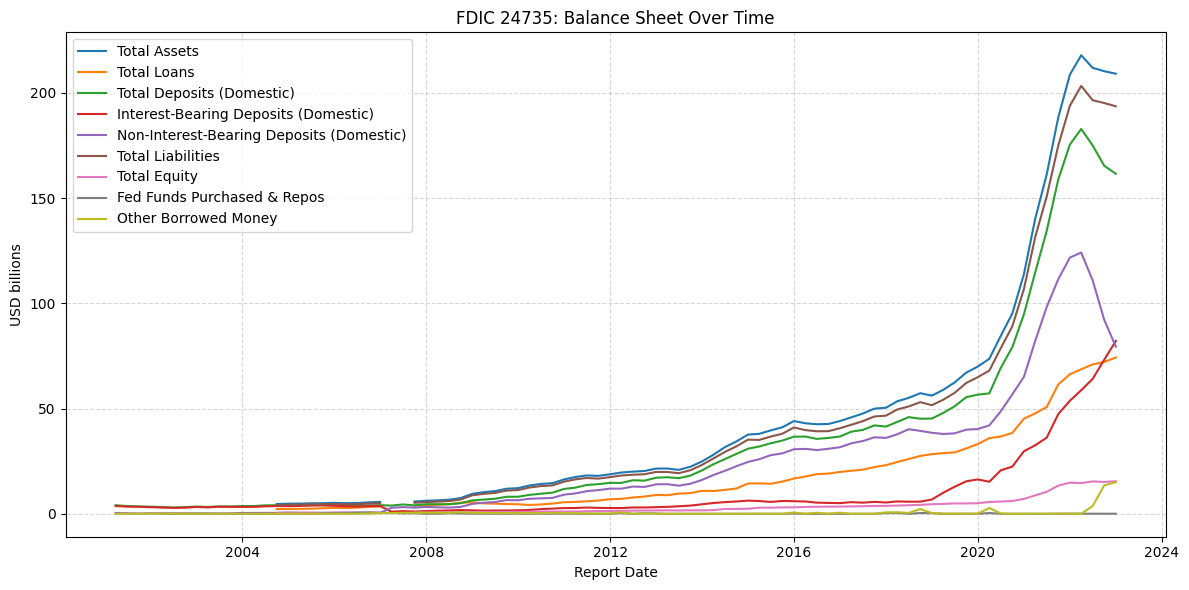

In [39]:
# Scale to USD billions (Call Report is in $ thousands)
panel["total_assets_bn"]            = panel["total_assets"] / 1e6
panel["total_loans_bn"]             = panel["total_loans"] / 1e6
panel["total_deposits_bn"]          = panel["total_deposits_domestic"] / 1e6  # <-- THIS is deposits
panel["intbearing_deposits_domestic_bn"] = panel["intbearing_deposits_domestic"] / 1e6
panel["nonint_deposits_domestic_bn"] = panel["nonint_deposits_domestic"] / 1e6
panel["total_liabs_minority_bn"]    = panel["total_liabs_minority"] / 1e6
panel["total_equity_bn"]            = panel["total_equity"] / 1e6
panel["fedfunds_purchased_repos_bn"] = (panel["fedfunds_purchased_domestic"] + panel["repos_sold_domestic"]) / 1e6
panel["other_borrowed_money_domestic_bn"]    = panel["other_borrowed_money_domestic"] / 1e6

plt.figure(figsize=(12, 6))

plt.plot(panel["report_date"], panel["total_assets_bn"],         label="Total Assets")
plt.plot(panel["report_date"], panel["total_loans_bn"],          label="Total Loans")
plt.plot(panel["report_date"], panel["total_deposits_bn"],       label="Total Deposits (Domestic)")
plt.plot(panel["report_date"], panel["intbearing_deposits_domestic_bn"], label="Interest-Bearing Deposits (Domestic)")
plt.plot(panel["report_date"], panel["nonint_deposits_domestic_bn"], label="Non-Interest-Bearing Deposits (Domestic)")
plt.plot(panel["report_date"], panel["total_liabs_minority_bn"], label="Total Liabilities")
plt.plot(panel["report_date"], panel["total_equity_bn"],         label="Total Equity")
plt.plot(panel["report_date"], panel["fedfunds_purchased_repos_bn"], label="Fed Funds Purchased & Repos")
plt.plot(panel["report_date"], panel["other_borrowed_money_domestic_bn"], label="Other Borrowed Money")

plt.title(f"FDIC {FDIC_CERT}: Balance Sheet Over Time")
plt.xlabel("Report Date")
plt.ylabel("USD billions")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
panel[
    [
        "report_date",
        "total_assets",
        "total_deposits",
        "total_deposits_domestic"
    ]
].tail()

report_date  total_assets  total_deposits  total_deposits_domestic
83  2021-12-31   208581000.0        16053000              175378000.0
84  2022-03-31   217804000.0        17612000              182802000.0
85  2022-06-30   211824000.0        15196000              174957000.0
86  2022-09-30   210244000.0        13537000              165341000.0
87  2022-12-31   209026000.0        13899000              161479000.0

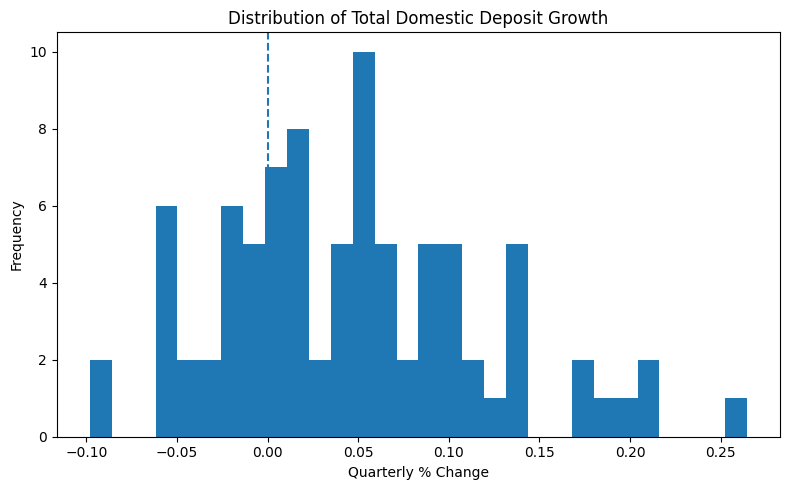

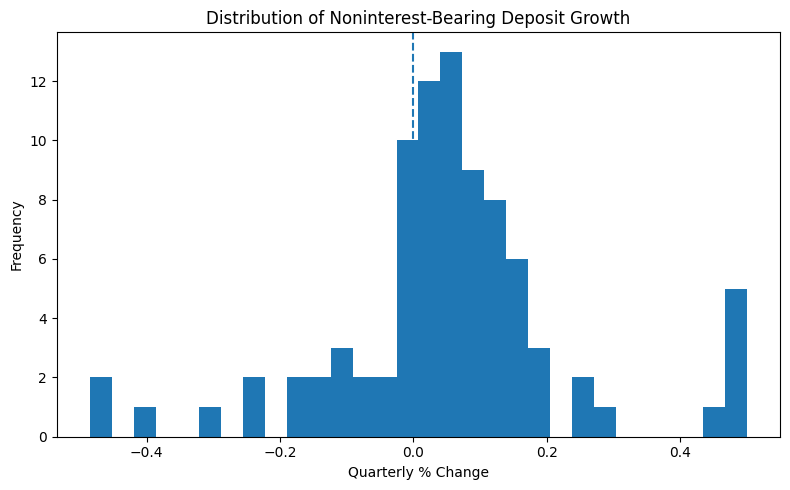

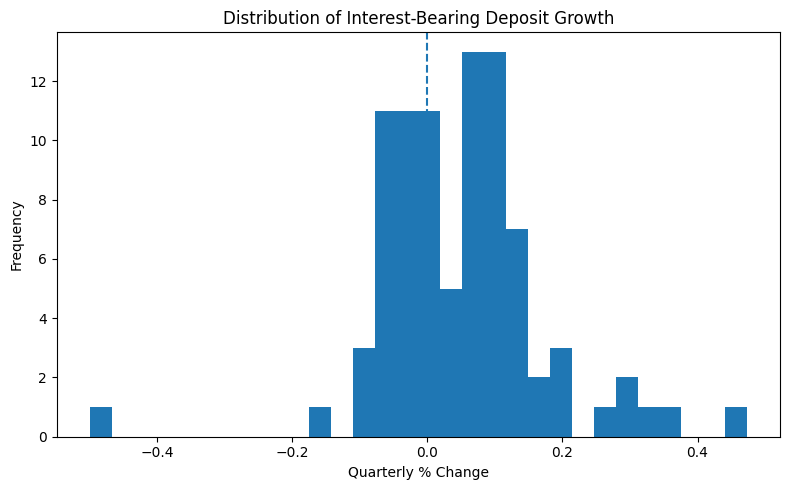

In [41]:
# -----------------------------
# Deposit growth / outflow measures
# -----------------------------

# Ensure proper time ordering
panel = panel.sort_values(["fdic_cert", "report_date"]).reset_index(drop=True)

# Total domestic deposits
panel["dep_total_pct"] = panel["total_deposits_domestic"].pct_change()

# Noninterest-bearing deposits (stickier)
panel["dep_nonint_pct"] = panel["nonint_deposits_domestic"].pct_change()

# Interest-bearing deposits (rate-sensitive)
panel["dep_int_pct"] = panel["intbearing_deposits_domestic"].pct_change()

# Optional: winsorize extreme values for stability (recommended)
for col in ["dep_total_pct", "dep_nonint_pct", "dep_int_pct"]:
    panel[col] = panel[col].clip(lower=-0.5, upper=0.5)


plt.figure(figsize=(8, 5))
plt.hist(panel["dep_total_pct"].dropna(), bins=30)
plt.title("Distribution of Total Domestic Deposit Growth")
plt.xlabel("Quarterly % Change")
plt.ylabel("Frequency")
plt.axvline(0, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(panel["dep_nonint_pct"].dropna(), bins=30)
plt.title("Distribution of Noninterest-Bearing Deposit Growth")
plt.xlabel("Quarterly % Change")
plt.ylabel("Frequency")
plt.axvline(0, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(panel["dep_int_pct"].dropna(), bins=30)
plt.title("Distribution of Interest-Bearing Deposit Growth")
plt.xlabel("Quarterly % Change")
plt.ylabel("Frequency")
plt.axvline(0, linestyle="--")
plt.tight_layout()
plt.show()


/var/folders/gw/gyqm76mn3d3_vjqrr211cp3m0000gn/T/ipykernel_13688/2282136860.py:29: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  .resample("Q")


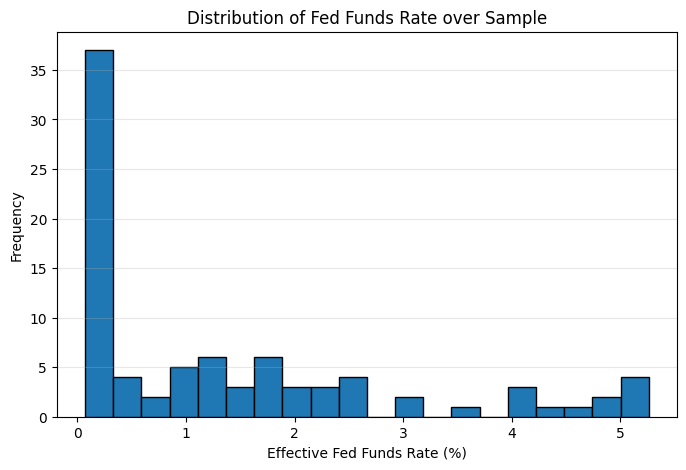

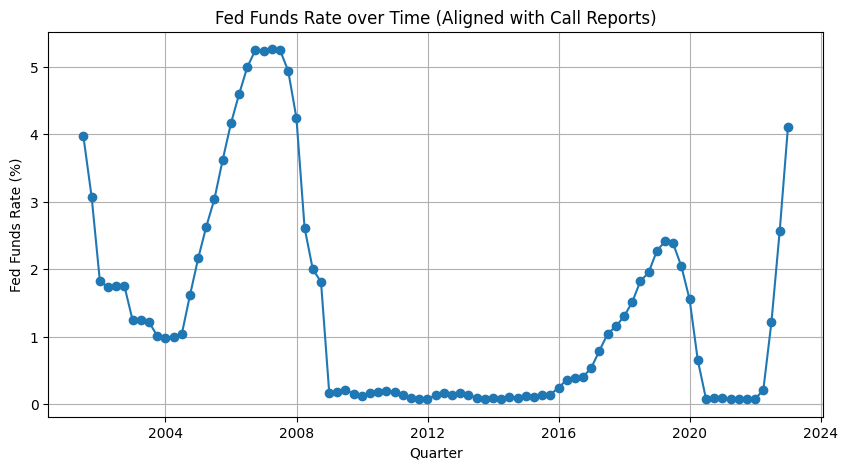

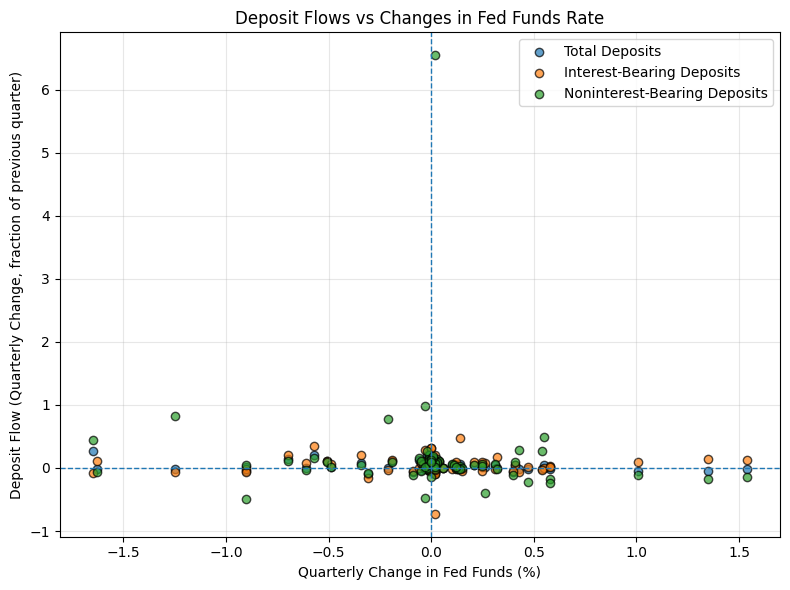

In [42]:
# ----------------------------------------------------
# 1. Deposit flows and outflows
# ----------------------------------------------------
panel = panel.sort_values("report_date").reset_index(drop=True)

# ----- FLOWS (symmetric) -----
panel["flow_total"] = panel["total_deposits_domestic"].pct_change()
panel["flow_int"]   = panel["intbearing_deposits_domestic"].pct_change()
panel["flow_nonint"] = panel["nonint_deposits_domestic"].pct_change()

# ----- OUTFLOWS (one-sided) -----
panel["outflow_total"] = -panel["flow_total"].clip(upper=0)
panel["outflow_int"]   = -panel["flow_int"].clip(upper=0)
panel["outflow_nonint"] = -panel["flow_nonint"].clip(upper=0)

# ----------------------------------------------------
# 2. Pull Fed funds, quarterly, aligned to Call dates
# ----------------------------------------------------
import datetime as dt
from pandas_datareader import data as pdr

start_date = panel["report_date"].min()
end_date   = panel["report_date"].max()

fed = pdr.DataReader("FEDFUNDS", "fred", start_date, end_date)

fed_q = (
    fed
    .resample("Q")
    .last()
)
fed_q.index = fed_q.index.to_period("Q").to_timestamp("Q")  # quarter-end dates

# Rename BEFORE merge so we only ever create 'fed_funds' once
fed_q = fed_q.rename(columns={"FEDFUNDS": "fed_funds"})

panel = panel.merge(
    fed_q,
    left_on="report_date",
    right_index=True,
    how="left"
)
panel = panel.loc[:, ~panel.columns.duplicated()]

# Quarterly change in Fed funds
panel["fedfunds_change"] = panel["fed_funds"].diff()

# ----------------------------------------------------
# 3. Fed funds level + changes: histograms and scatter
# ----------------------------------------------------
import matplotlib.pyplot as plt

# Histogram of Fed funds level
plt.figure(figsize=(8, 5))
plt.hist(panel["fed_funds"].dropna(), bins=20, edgecolor="black")
plt.xlabel("Effective Fed Funds Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Fed Funds Rate over Sample")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Time series of Fed funds
plt.figure(figsize=(10, 5))
plt.plot(panel["report_date"], panel["fed_funds"], marker="o")
plt.xlabel("Quarter")
plt.ylabel("Fed Funds Rate (%)")
plt.title("Fed Funds Rate over Time (Aligned with Call Reports)")
plt.grid(True)
plt.show()

# Histogram of quarterly change in Fed funds
plt.figure(figsize=(8, 6))

plt.scatter(
    panel["fedfunds_change"],
    panel["flow_total"],
    alpha=0.7,
    edgecolor="black",
    label="Total Deposits"
)

plt.scatter(
    panel["fedfunds_change"],
    panel["flow_int"],
    alpha=0.7,
    edgecolor="black",
    label="Interest-Bearing Deposits"
)

plt.scatter(
    panel["fedfunds_change"],
    panel["flow_nonint"],
    alpha=0.7,
    edgecolor="black",
    label="Noninterest-Bearing Deposits"
)

# Reference lines
plt.axhline(0, linestyle="--", linewidth=1)
plt.axvline(0, linestyle="--", linewidth=1)

plt.xlabel("Quarterly Change in Fed Funds (%)")
plt.ylabel("Deposit Flow (Quarterly Change, fraction of previous quarter)")
plt.title("Deposit Flows vs Changes in Fed Funds Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Gaussian Copula

Gaussian copula correlation (rho): -0.281715537722412


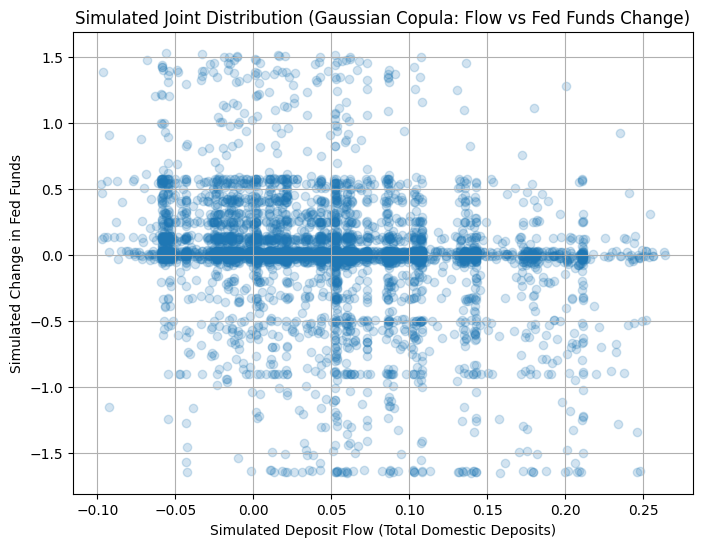

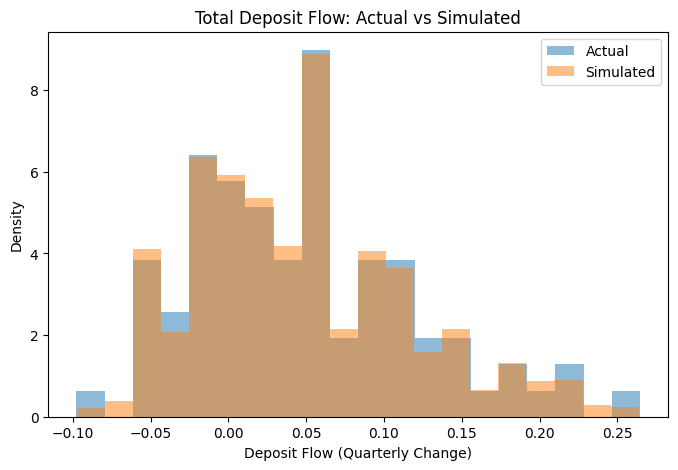

In [43]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. Select variables: total deposit flow vs rate change
#    (assumes panel has 'flow_total' and 'fedfunds_change')
# ----------------------------------------------------
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()

x = df["flow_total"].values        # quarterly deposit flow (∆ deposits / lagged deposits)
y = df["fedfunds_change"].values   # quarterly change in Fed funds (in same units as pulled)

n = len(df)

# ----------------------------------------------------
# 2. Rank-based empirical CDFs -> uniforms
# ----------------------------------------------------
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n

# Avoid exact 0 / 1 for inverse normal
eps = 1e-6
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# Map uniforms to standard normals
z_x = stats.norm.ppf(u_x)
z_y = stats.norm.ppf(u_y)

# ----------------------------------------------------
# 3. Estimate Gaussian copula correlation
# ----------------------------------------------------
rho = np.corrcoef(z_x, z_y)[0, 1]
print("Gaussian copula correlation (rho):", rho)

# ----------------------------------------------------
# 4. Simulate from the fitted Gaussian copula
# ----------------------------------------------------
num_sim = 5000

cov = np.array([[1,    rho],
                [rho,  1  ]])

# Simulated latent normals
z_sim = np.random.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=num_sim)

# Back to uniforms
u_sim = stats.norm.cdf(z_sim)
u_x_sim = u_sim[:, 0]
u_y_sim = u_sim[:, 1]

def empirical_quantile(u, sample):
    return np.quantile(sample, u)

# Map simulated uniforms through empirical marginals
x_sim = empirical_quantile(u_x_sim, x)   # simulated flow_total
y_sim = empirical_quantile(u_y_sim, y)   # simulated fedfunds_change

# ----------------------------------------------------
# 5. Diagnostic plots
# ----------------------------------------------------
# Joint simulated cloud
plt.figure(figsize=(8, 6))
plt.scatter(x_sim, y_sim, alpha=0.2)
plt.xlabel("Simulated Deposit Flow (Total Domestic Deposits)")
plt.ylabel("Simulated Change in Fed Funds")
plt.title("Simulated Joint Distribution (Gaussian Copula: Flow vs Fed Funds Change)")
plt.grid(True)
plt.show()

# Compare marginals: actual vs simulated (deposit flow)
plt.figure(figsize=(8, 5))
plt.hist(x,     bins=20, alpha=0.5, label="Actual",     density=True)
plt.hist(x_sim, bins=20, alpha=0.5, label="Simulated", density=True)
plt.legend()
plt.title("Total Deposit Flow: Actual vs Simulated")
plt.xlabel("Deposit Flow (Quarterly Change)")
plt.ylabel("Density")
plt.show()

Number of observations: 86
Best t-copula df (nu): 4.0
Estimated t-copula correlation (rho): -0.3008
Max log-likelihood: 5.5


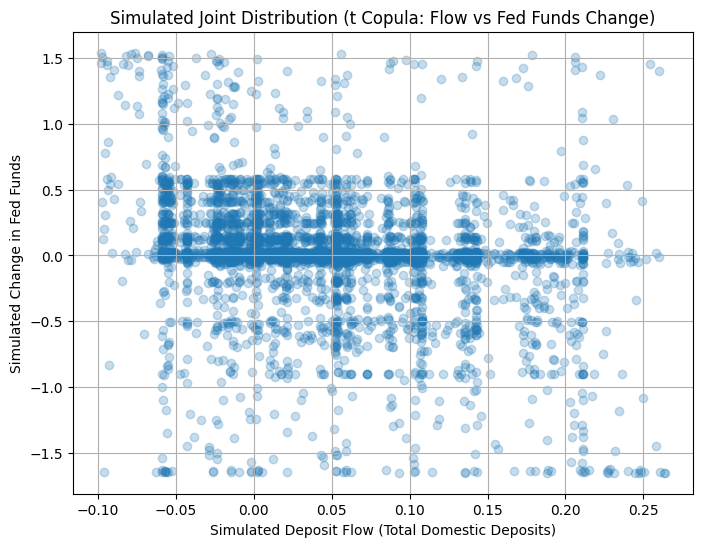

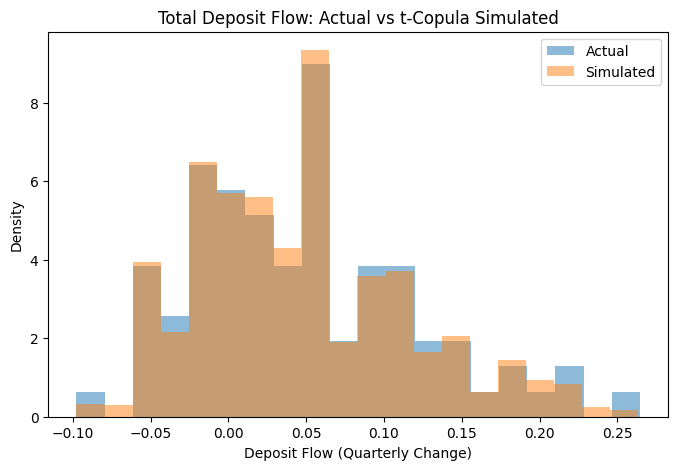

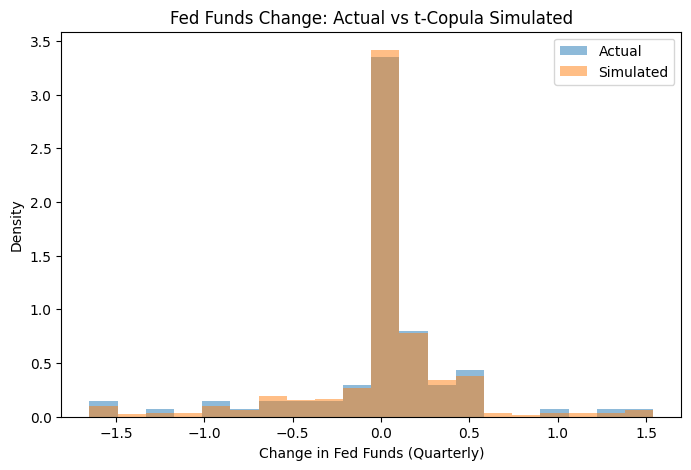

In [44]:
import numpy as np
from scipy import stats
from scipy.special import gammaln
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. Data: total deposit flow vs rate change
# ----------------------------------------------------
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()

x = df["flow_total"].values        # quarterly deposit flow (Δ deposits / lagged deposits)
y = df["fedfunds_change"].values   # quarterly change in Fed funds (in rate points)

n = len(df)
print("Number of observations:", n)

# ----------------------------------------------------
# 2. Rank-based empirical CDFs -> uniforms
# ----------------------------------------------------
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n

eps = 1e-6
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# ----------------------------------------------------
# 3. Pseudo–likelihood fit of a bivariate t copula
#    (estimate df (nu) on a grid and rho given nu)
# ----------------------------------------------------
def t_copula_loglik(u1, u2, nu):
    """
    Pseudo log-likelihood of a bivariate t copula
    at uniforms u1, u2, given degrees of freedom nu.
    Rho is estimated from the implied t-variates.
    """
    # uniforms -> t-variates
    t1 = stats.t.ppf(u1, df=nu)
    t2 = stats.t.ppf(u2, df=nu)
    t_stack = np.column_stack([t1, t2])

    # estimate correlation of latent t-variates
    rho = np.corrcoef(t1, t2)[0, 1]

    # covariance matrix and its inverse
    d = 2
    Sigma = np.array([[1.0, rho],
                      [rho, 1.0]])
    inv_Sigma = np.linalg.inv(Sigma)
    det_Sigma = np.linalg.det(Sigma)

    # quadratic form t' Σ^{-1} t
    quad = np.einsum("ij,jk,ik->i", t_stack, inv_Sigma, t_stack)

    # log density of bivariate t
    # log f_d(t) = Γ((ν+d)/2) - Γ(ν/2) - (d/2) log(νπ) - 0.5 log|Σ|
    #              - ((ν+d)/2) log(1 + quad/ν)
    log_f2 = (
        gammaln((nu + d) / 2.0)
        - gammaln(nu / 2.0)
        - (d / 2.0) * np.log(nu * np.pi)
        - 0.5 * np.log(det_Sigma)
        - (nu + d) / 2.0 * np.log1p(quad / nu)
    )

    # log density of univariate t for each margin
    log_f1_t1 = stats.t.logpdf(t1, df=nu)
    log_f1_t2 = stats.t.logpdf(t2, df=nu)

    # copula log-density: log c(u) = log f2(t) - log f1(t1) - log f1(t2)
    log_c = log_f2 - log_f1_t1 - log_f1_t2

    return log_c.sum(), rho


# grid search for nu
nu_grid = np.arange(2.0, 31.0, 1.0)  # df from 2 to 30
best_ll = -np.inf
best_nu = None
best_rho = None

for nu in nu_grid:
    ll, rho_hat = t_copula_loglik(u_x, u_y, nu)
    if ll > best_ll:
        best_ll = ll
        best_nu = nu
        best_rho = rho_hat

print(f"Best t-copula df (nu): {best_nu:.1f}")
print(f"Estimated t-copula correlation (rho): {best_rho:.4f}")
print(f"Max log-likelihood: {best_ll:.1f}")

nu = best_nu
rho = best_rho

# ----------------------------------------------------
# 4. Simulate from the fitted t copula
# ----------------------------------------------------
num_sim = 5000

# correlation matrix of latent t
Sigma = np.array([[1.0, rho],
                  [rho, 1.0]])

# simulate multivariate t via normal + chi-square
z = np.random.multivariate_normal(mean=[0.0, 0.0], cov=Sigma, size=num_sim)
chi2 = np.random.chisquare(df=nu, size=num_sim)
scale = np.sqrt(chi2 / nu)[:, None]  # shape (num_sim, 1)

t_sim = z / scale  # multivariate t samples

# convert to uniforms using t CDF
u_sim = stats.t.cdf(t_sim, df=nu)
u_x_sim = u_sim[:, 0]
u_y_sim = u_sim[:, 1]

def empirical_quantile(u, sample):
    return np.quantile(sample, u)

# map uniforms through empirical marginals
x_sim = empirical_quantile(u_x_sim, x)  # simulated flow_total
y_sim = empirical_quantile(u_y_sim, y)  # simulated fedfunds_change

# ----------------------------------------------------
# 5. Diagnostic plots
# ----------------------------------------------------
# Joint simulated cloud
plt.figure(figsize=(8, 6))
plt.scatter(x_sim, y_sim, alpha=0.25)
plt.xlabel("Simulated Deposit Flow (Total Domestic Deposits)")
plt.ylabel("Simulated Change in Fed Funds")
plt.title("Simulated Joint Distribution (t Copula: Flow vs Fed Funds Change)")
plt.grid(True)
plt.show()

# Compare marginals: actual vs simulated (deposit flow)
plt.figure(figsize=(8, 5))
plt.hist(x,     bins=20, alpha=0.5, label="Actual",    density=True)
plt.hist(x_sim, bins=20, alpha=0.5, label="Simulated", density=True)
plt.legend()
plt.title("Total Deposit Flow: Actual vs t-Copula Simulated")
plt.xlabel("Deposit Flow (Quarterly Change)")
plt.ylabel("Density")
plt.show()

# Compare marginals: actual vs simulated (Fed funds change)
plt.figure(figsize=(8, 5))
plt.hist(y,     bins=20, alpha=0.5, label="Actual",    density=True)
plt.hist(y_sim, bins=20, alpha=0.5, label="Simulated", density=True)
plt.legend()
plt.title("Fed Funds Change: Actual vs t-Copula Simulated")
plt.xlabel("Change in Fed Funds (Quarterly)")
plt.ylabel("Density")
plt.show()

Number of quarterly observations used: 86
t-copula correlation (rho_t): -0.28728727687067757
Latest quarter deposits (domestic): 161.5 bn
Approximate HQLA stock:            127.5 bn
95% LaR (one quarter): 8.87 bn
99% LaR (one quarter): 10.69 bn
HQLA / LaR95 coverage: 14.38x
HQLA / LaR99 coverage: 11.93x


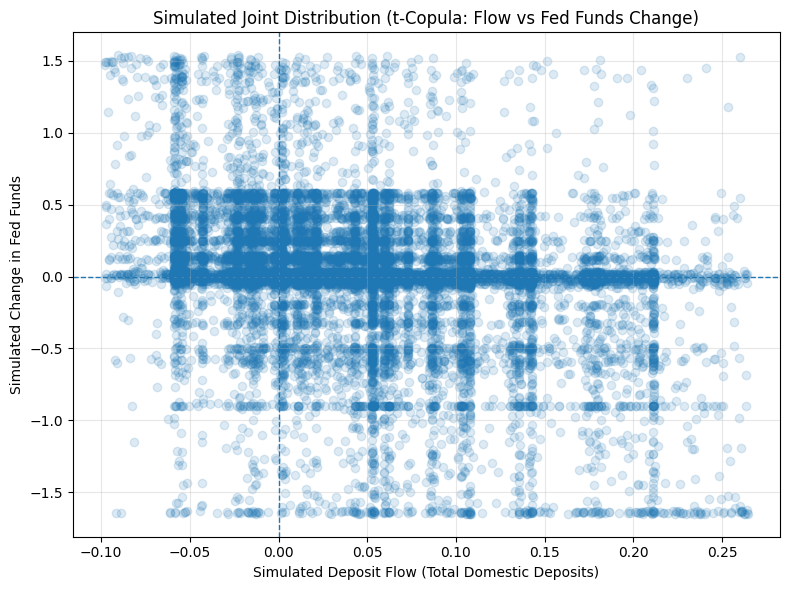

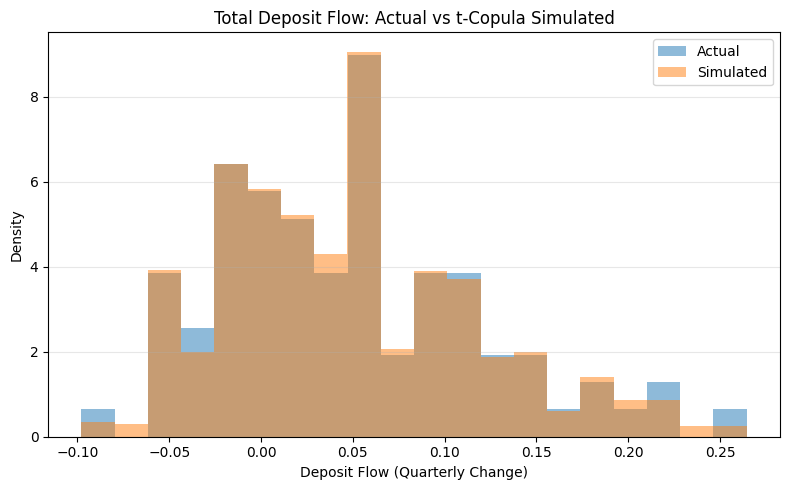

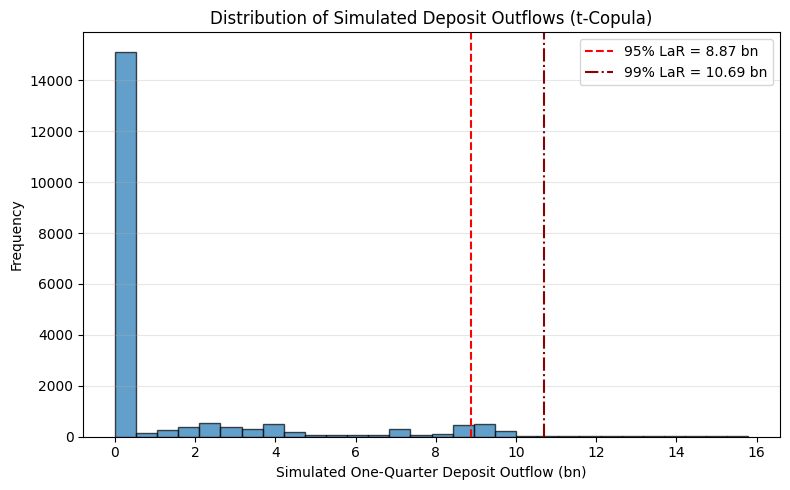

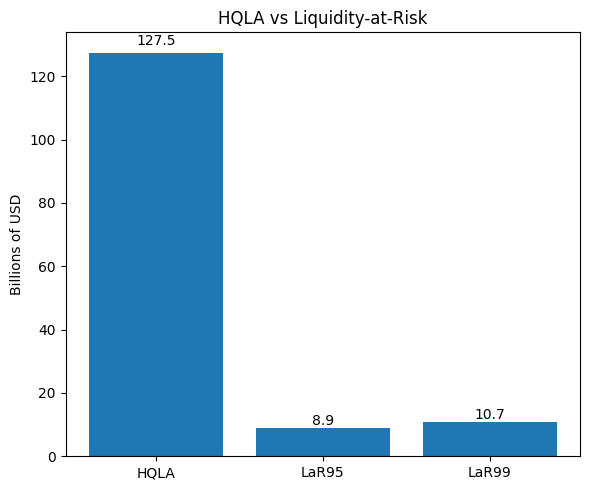

In [45]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ====================================================
# 0. Data prep: use only rows with both vars present
# ====================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()

x = df["flow_total"].values        # quarterly deposit flow (ratio)
y = df["fedfunds_change"].values   # quarterly change in Fed funds (level units)

n = len(df)
print(f"Number of quarterly observations used: {n}")

# ====================================================
# 1. t-copula fit (rank -> uniforms -> t-variates)
# ====================================================

# Rank-based empirical CDF -> uniforms in (0,1)
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n

eps = 1e-6
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# Choose degrees of freedom for t-copula (low df = heavier tails)
nu = 10

# Map uniforms to t_nu margins
t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)

# Estimate correlation matrix of latent t-variates
rho_t = np.corrcoef(t_x, t_y)[0, 1]
print("t-copula correlation (rho_t):", rho_t)

Sigma = np.array([[1.0,    rho_t],
                  [rho_t,  1.0 ]])

# ====================================================
# 2. Simulate from the fitted t-copula
# ====================================================

def sample_multivariate_t(mu, Sigma, df, size):
    """
    Draw samples from multivariate t with location mu, scale Sigma, df degrees.
    For copula purposes we only care about dependence, not scale.
    """
    dim = len(mu)
    g = np.random.standard_normal(size=(size, dim))
    L = np.linalg.cholesky(Sigma)
    z = g @ L.T                  # correlated normals
    w = np.random.chisquare(df, size=size)
    return mu + z / np.sqrt(w / df)[:, None]

num_sim = 20_000

t_sim = sample_multivariate_t(
    mu=np.zeros(2),
    Sigma=Sigma,
    df=nu,
    size=num_sim
)

# Back to uniforms via t CDF
u_sim = stats.t.cdf(t_sim, df=nu)
u_x_sim = u_sim[:, 0]
u_y_sim = u_sim[:, 1]

def empirical_quantile(u, sample):
    return np.quantile(sample, u)

# Map simulated uniforms through empirical marginals
flow_sim = empirical_quantile(u_x_sim, x)   # simulated total deposit flow
rate_sim = empirical_quantile(u_y_sim, y)   # simulated change in fed funds

# ====================================================
# 3. One-step Liquidity-at-Risk from latest balance sheet
# ====================================================

# --- Current balance sheet snapshot (latest report) ---
latest = panel.sort_values("report_date").iloc[-1]

# Call Report amounts are in $ thousands; convert to billions when reporting
D0_thousands = latest["total_deposits_domestic"]
D0_bn = D0_thousands / 1e6

# Approximate HQLA stock (very stylized haircuts)
HQLA_thousands = (
    latest["cash_and_balances"]                    # Level 1
    + latest["interest_bearing_balances"]          # Level 1-ish
    + latest["securities_afs_total"]               # treat as Level 1/2A
    + 0.85 * latest["securities_htm_total"]        # haircut HTM
    + 0.50 * latest["trading_assets_total"]        # haircut trading
)
HQLA_bn = HQLA_thousands / 1e6

print(f"Latest quarter deposits (domestic): {D0_bn:.1f} bn")
print(f"Approximate HQLA stock:            {HQLA_bn:.1f} bn")

# --- From simulated flows to simulated outflows ---
# New deposit level next quarter for each simulation
D1_thousands = D0_thousands * (1.0 + flow_sim)

# Outflow amount = max(D0 - D1, 0)
outflow_thousands = np.maximum(D0_thousands - D1_thousands, 0.0)
outflow_bn = outflow_thousands / 1e6

# LaR at chosen confidence levels
alpha_95 = 0.95
alpha_99 = 0.99

LaR_95 = np.quantile(outflow_bn, alpha_95)
LaR_99 = np.quantile(outflow_bn, alpha_99)

print(f"95% LaR (one quarter): {LaR_95:.2f} bn")
print(f"99% LaR (one quarter): {LaR_99:.2f} bn")

# Coverage ratios: HQLA / LaR
cov_95 = HQLA_bn / LaR_95 if LaR_95 > 0 else np.inf
cov_99 = HQLA_bn / LaR_99 if LaR_99 > 0 else np.inf

print(f"HQLA / LaR95 coverage: {cov_95:.2f}x")
print(f"HQLA / LaR99 coverage: {cov_99:.2f}x")

# ====================================================
# 4. Plots
# ====================================================

# (A) Joint simulated cloud (flow vs rate change)
plt.figure(figsize=(8, 6))
plt.scatter(flow_sim, rate_sim, alpha=0.15)
plt.axvline(0, linestyle="--", linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Simulated Deposit Flow (Total Domestic Deposits)")
plt.ylabel("Simulated Change in Fed Funds")
plt.title("Simulated Joint Distribution (t-Copula: Flow vs Fed Funds Change)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (B) Marginal check: actual vs simulated flows
plt.figure(figsize=(8, 5))
plt.hist(x,        bins=20, alpha=0.5, label="Actual",    density=True)
plt.hist(flow_sim, bins=20, alpha=0.5, label="Simulated", density=True)
plt.xlabel("Deposit Flow (Quarterly Change)")
plt.ylabel("Density")
plt.title("Total Deposit Flow: Actual vs t-Copula Simulated")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# (C) Distribution of simulated outflows with LaR lines
plt.figure(figsize=(8, 5))
plt.hist(outflow_bn, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(LaR_95, color="red",  linestyle="--", label=f"95% LaR = {LaR_95:.2f} bn")
plt.axvline(LaR_99, color="darkred", linestyle="-.", label=f"99% LaR = {LaR_99:.2f} bn")
plt.xlabel("Simulated One-Quarter Deposit Outflow (bn)")
plt.ylabel("Frequency")
plt.title("Distribution of Simulated Deposit Outflows (t-Copula)")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# (D) Simple bar chart: HQLA vs LaR
# (D) Simple bar chart: HQLA vs LaR
plt.figure(figsize=(6, 5))
bars = ["HQLA", "LaR95", "LaR99"]
values = [HQLA_bn, LaR_95, LaR_99]
plt.bar(bars, values)
plt.ylabel("Billions of USD")
plt.title("HQLA vs Liquidity-at-Risk")
for i, v in enumerate(values):
    plt.text(i, v * 1.01, f"{v:.1f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

### Parametric Interest Rate Model + Empirical Deposit Outflow Model

AR(1) regression parameters:
 alpha = 0.000023
 beta  = 0.999667
 s2    = 2.470984e-07
 R²    = 0.9994

Vasicek parameters:
a     (speed)      = 0.0839
b     (mean level) = 7.0389%
sigma (volatility) = 12.5288%

Last observed rate r0 = 3.6800%

Predictive distribution at horizon T:
 Mean r_T = 3.9504%
 Std r_T  = 12.0209%


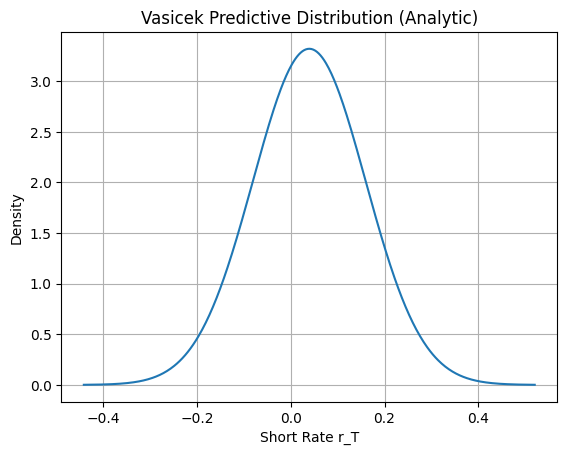

In [46]:
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 10)
FRED_API_KEY = "a8837523b7c200b627e6e1f1a7275566"
SERIES_ID = "DGS1"
START_DATE = "2020-01-01"
END_DATE   = "2025-09-30"

def fetch_fred_series(series_id, start_date, end_date, api_key):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    
    obs = data["observations"]
    dates = [o["date"] for o in obs]
    values = []
    for o in obs:
        v = o["value"]
        # FRED uses "." to denote missing values
        if v == ".":
            values.append(np.nan)
        else:
            values.append(float(v))
    
    df = pd.DataFrame({"date": pd.to_datetime(dates), "rate_pct": values})
    df.set_index("date", inplace=True)
    return df

rates_raw = fetch_fred_series(SERIES_ID, START_DATE, END_DATE, FRED_API_KEY)

rates_raw.head(), rates_raw.tail()


# ------------------------------------------------------------
# 1. Load + preprocess rate series (daily or business-day)
# ------------------------------------------------------------
rates = rates_raw.copy()
rates["rate_pct"] = rates["rate_pct"].astype(float)
rates["rate_pct"] = rates["rate_pct"].interpolate(limit_direction="both")

# Convert % → decimal
rates["r"] = rates["rate_pct"] / 100.0
rates = rates[["r"]]

# ------------------------------------------------------------
# 2. Build AR(1) regression r_{t+1} = alpha + beta * r_t + eps
# ------------------------------------------------------------
r_series = rates["r"].dropna()
r_t   = r_series.shift(1).dropna()
r_tp1 = r_series.loc[r_t.index]      # aligned next-day rate

df_reg = pd.DataFrame({"r_t": r_t, "r_tp1": r_tp1})

# Daily step (business-day)
delta = 1.0 / 252.0

# OLS regression
X = sm.add_constant(df_reg["r_t"])
y = df_reg["r_tp1"]
ols_model = sm.OLS(y, X).fit()

alpha = ols_model.params["const"]
beta  = ols_model.params["r_t"]
s2    = ols_model.mse_resid   # residual variance

print("AR(1) regression parameters:")
print(f" alpha = {alpha:.6f}")
print(f" beta  = {beta:.6f}")
print(f" s2    = {s2:.6e}")
print(f" R²    = {ols_model.rsquared:.4f}")

# ------------------------------------------------------------
# 3. Convert AR(1) → Vasicek parameters
# ------------------------------------------------------------
phi = beta

# Speed of mean reversion
a = -np.log(phi) / delta

# Long-run mean level
b = alpha / (1 - phi)

# Short-rate volatility under Vasicek
sigma2 = s2 * 2 * a / ((1 - phi**2) * delta)
sigma  = np.sqrt(sigma2)

print("\nVasicek parameters:")
print(f"a     (speed)      = {a:.4f}")
print(f"b     (mean level) = {b:.4%}")
print(f"sigma (volatility) = {sigma:.4%}")

# ------------------------------------------------------------
# 4. Last observed rate r0 + forecast horizon T
# ------------------------------------------------------------
r0 = r_series.iloc[-1]  # end-of-sample short rate
T  = 1.0                # 1-year horizon (can change)

print(f"\nLast observed rate r0 = {r0:.4%}")

# ------------------------------------------------------------
# 5. Vasicek analytic mean and variance at horizon T
# ------------------------------------------------------------
m_T = b + (r0 - b) * np.exp(-a * T)
v_T = sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T))
std_T = np.sqrt(v_T)

print("\nPredictive distribution at horizon T:")
print(f" Mean r_T = {m_T:.4%}")
print(f" Std r_T  = {std_T:.4%}")

# Optional: visualize
x_grid = np.linspace(m_T - 4*std_T, m_T + 4*std_T, 500)
from scipy.stats import norm
pdf_grid = norm.pdf(x_grid, m_T, std_T)

plt.plot(x_grid, pdf_grid)
plt.title("Vasicek Predictive Distribution (Analytic)")
plt.xlabel("Short Rate r_T")
plt.ylabel("Density")
plt.grid(True)
plt.show()

Number of quarterly observations used: 86
t-copula correlation (rho_t): -0.28728727687067757
Latest quarter deposits (domestic): 161.5 bn
Approximate HQLA stock:            49.8 bn
95% LaR (one quarter): 8.85 bn
99% LaR (one quarter): 10.06 bn
HQLA / LaR95 coverage: 5.63x
HQLA / LaR99 coverage: 4.95x


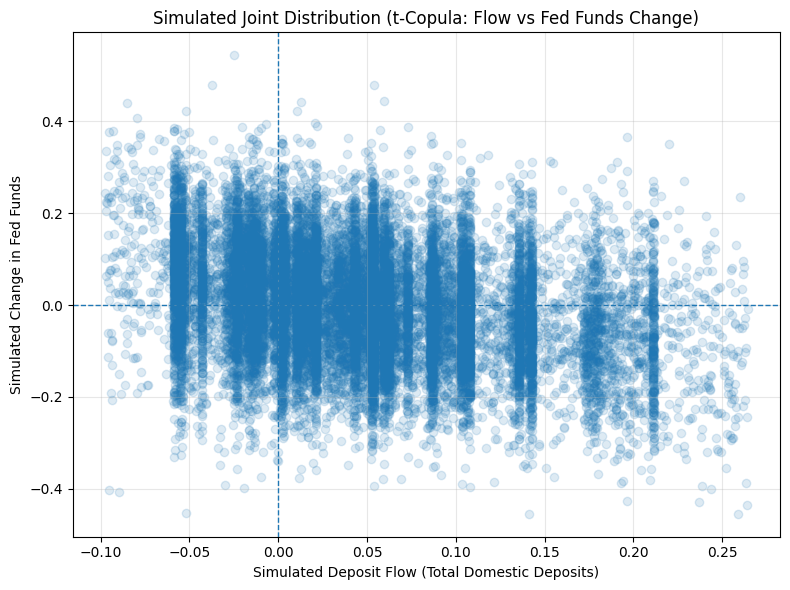

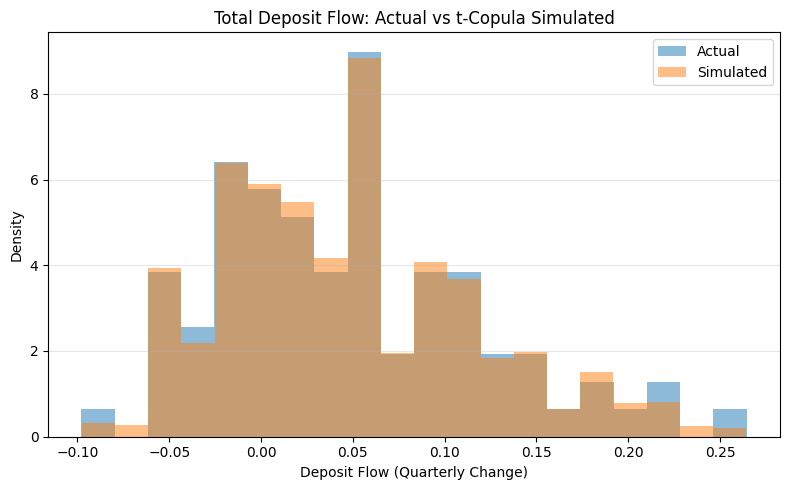

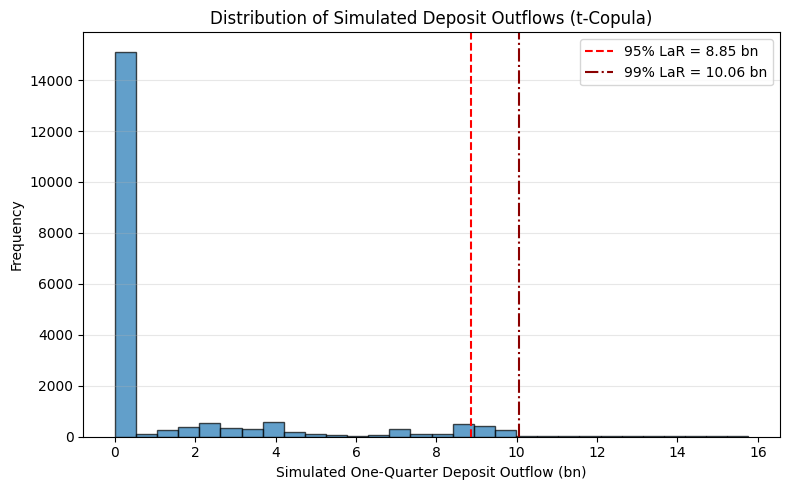

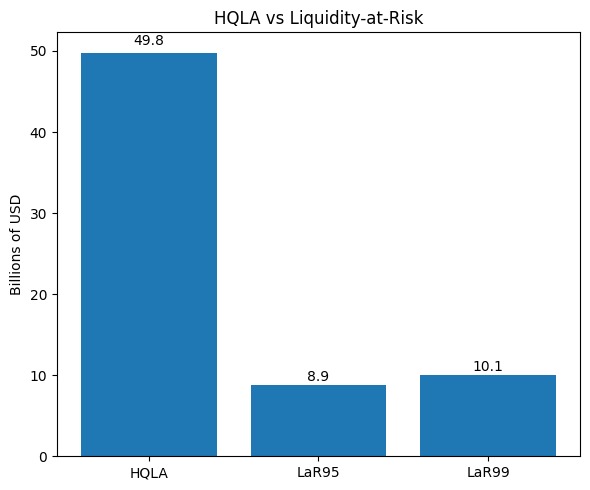

In [47]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ====================================================
# 0. Data prep: use only rows with both vars present
# ====================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()

x = df["flow_total"].values        # quarterly deposit flow (ratio)
y = df["fedfunds_change"].values   # quarterly change in Fed funds (level units)

n = len(df)
print(f"Number of quarterly observations used: {n}")

# ====================================================
# 1. t-copula fit (rank -> uniforms -> t-variates)
# ====================================================

# Rank-based empirical CDF -> uniforms in (0,1)
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n

eps = 1e-6
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# Choose degrees of freedom for t-copula (low df = heavier tails)
nu = 10

# Map uniforms to t_nu margins
t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)

# Estimate correlation matrix of latent t-variates
rho_t = np.corrcoef(t_x, t_y)[0, 1]
print("t-copula correlation (rho_t):", rho_t)

Sigma = np.array([[1.0,    rho_t],
                  [rho_t,  1.0 ]])

# ====================================================
# 2. Simulate from the fitted t-copula
# ====================================================

# After you have estimated a, b, sigma and have r0 and T_horizon
def vasicek_marginal_params(r0, a, b, sigma, T):
    """Return mean and std of r_T under Vasicek over horizon T (in years)."""
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return m_T, np.sqrt(v_T)

T_horizon = 1.0   # or 0.25 if you want a 1-quarter horizon
m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

def sample_multivariate_t(mu, Sigma, df, size):
    """
    Draw samples from multivariate t with location mu, scale Sigma, df degrees.
    For copula purposes we only care about dependence, not scale.
    """
    dim = len(mu)
    g = np.random.standard_normal(size=(size, dim))
    L = np.linalg.cholesky(Sigma)
    z = g @ L.T                  # correlated normals
    w = np.random.chisquare(df, size=size)
    return mu + z / np.sqrt(w / df)[:, None]

num_sim = 20_000

t_sim = sample_multivariate_t(
    mu=np.zeros(2),
    Sigma=Sigma,
    df=nu,
    size=num_sim
)

# Back to uniforms via t CDF
u_sim = stats.t.cdf(t_sim, df=nu)
u_x_sim = u_sim[:, 0]
u_y_sim = u_sim[:, 1]

def empirical_quantile(u, sample):
    return np.quantile(sample, u)

# Map simulated uniforms through empirical marginals
flow_sim = empirical_quantile(u_x_sim, x)   # simulated total deposit flow

# Rates: Vasicek marginal instead of empirical
r_T_sim = stats.norm.ppf(u_y_sim, loc=m_T, scale=std_T)
rate_sim = r_T_sim - r0   # simulated change in fed funds

# ====================================================
# 3. One-step Liquidity-at-Risk from latest balance sheet
# ====================================================

# --- Current balance sheet snapshot (latest report) ---
latest = panel.sort_values("report_date").iloc[-1]

# Call Report amounts are in $ thousands; convert to billions when reporting
D0_thousands = latest["total_deposits_domestic"]
D0_bn = D0_thousands / 1e6

# Approximate HQLA stock (very stylized haircuts)
HQLA_thousands = (
    latest["cash_and_balances"]                    # Level 1
    + latest["interest_bearing_balances"]          # Level 1-ish
    + latest["securities_afs_total"]               # treat as Level 1/2A
)
HQLA_bn = HQLA_thousands / 1e6

print(f"Latest quarter deposits (domestic): {D0_bn:.1f} bn")
print(f"Approximate HQLA stock:            {HQLA_bn:.1f} bn")

# --- From simulated flows to simulated outflows ---
# New deposit level next quarter for each simulation
D1_thousands = D0_thousands * (1.0 + flow_sim)

# Outflow amount = max(D0 - D1, 0)
outflow_thousands = np.maximum(D0_thousands - D1_thousands, 0.0)
outflow_bn = outflow_thousands / 1e6

# LaR at chosen confidence levels
alpha_95 = 0.95
alpha_99 = 0.99

LaR_95 = np.quantile(outflow_bn, alpha_95)
LaR_99 = np.quantile(outflow_bn, alpha_99)

print(f"95% LaR (one quarter): {LaR_95:.2f} bn")
print(f"99% LaR (one quarter): {LaR_99:.2f} bn")

# Coverage ratios: HQLA / LaR
cov_95 = HQLA_bn / LaR_95 if LaR_95 > 0 else np.inf
cov_99 = HQLA_bn / LaR_99 if LaR_99 > 0 else np.inf

print(f"HQLA / LaR95 coverage: {cov_95:.2f}x")
print(f"HQLA / LaR99 coverage: {cov_99:.2f}x")

# ====================================================
# 4. Plots
# ====================================================

# (A) Joint simulated cloud (flow vs rate change)
plt.figure(figsize=(8, 6))
plt.scatter(flow_sim, rate_sim, alpha=0.15)
plt.axvline(0, linestyle="--", linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Simulated Deposit Flow (Total Domestic Deposits)")
plt.ylabel("Simulated Change in Fed Funds")
plt.title("Simulated Joint Distribution (t-Copula: Flow vs Fed Funds Change)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (B) Marginal check: actual vs simulated flows
plt.figure(figsize=(8, 5))
plt.hist(x,        bins=20, alpha=0.5, label="Actual",    density=True)
plt.hist(flow_sim, bins=20, alpha=0.5, label="Simulated", density=True)
plt.xlabel("Deposit Flow (Quarterly Change)")
plt.ylabel("Density")
plt.title("Total Deposit Flow: Actual vs t-Copula Simulated")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# (C) Distribution of simulated outflows with LaR lines
plt.figure(figsize=(8, 5))
plt.hist(outflow_bn, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(LaR_95, color="red",  linestyle="--", label=f"95% LaR = {LaR_95:.2f} bn")
plt.axvline(LaR_99, color="darkred", linestyle="-.", label=f"99% LaR = {LaR_99:.2f} bn")
plt.xlabel("Simulated One-Quarter Deposit Outflow (bn)")
plt.ylabel("Frequency")
plt.title("Distribution of Simulated Deposit Outflows (t-Copula)")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# (D) Simple bar chart: HQLA vs LaR
# (D) Simple bar chart: HQLA vs LaR
plt.figure(figsize=(6, 5))
bars = ["HQLA", "LaR95", "LaR99"]
values = [HQLA_bn, LaR_95, LaR_99]
plt.bar(bars, values)
plt.ylabel("Billions of USD")
plt.title("HQLA vs Liquidity-at-Risk")
for i, v in enumerate(values):
    plt.text(i, v * 1.01, f"{v:.1f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

Last-period LCR (approx): 1.59


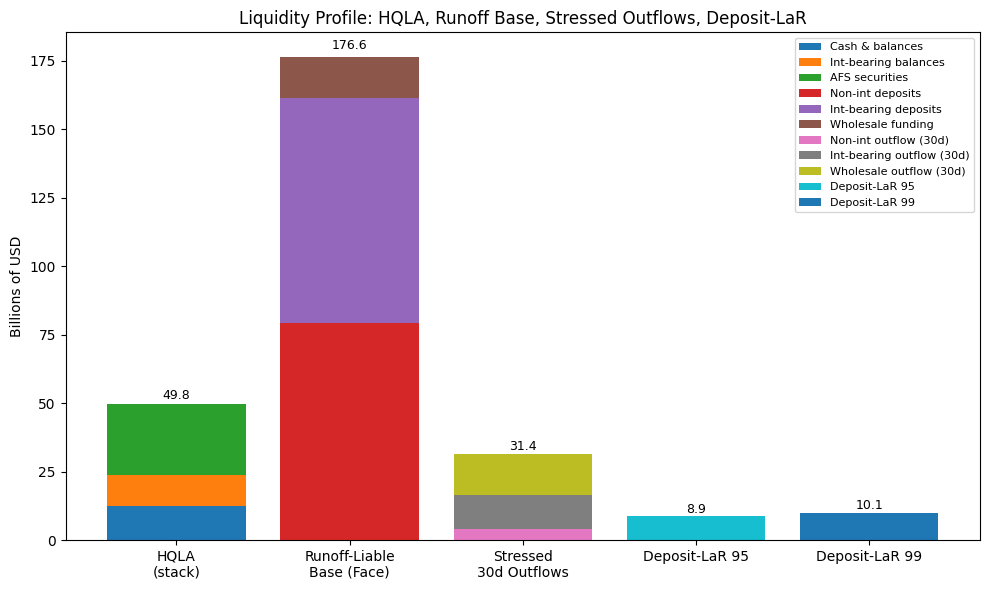

In [48]:
# ---------------------------------------------
# Last available quarter snapshot
# ---------------------------------------------
latest = panel.sort_values("report_date").iloc[-1]

# ========== HQLA COMPONENTS (in billions) ==========
cash_bn        = latest["cash_and_balances"]         / 1e6
ib_bal_bn      = latest["interest_bearing_balances"] / 1e6
afs_bn         = latest["securities_afs_total"]      / 1e6

HQLA_bn = cash_bn + ib_bal_bn + afs_bn

# Total domestic deposits (billions)
total_deposits_bn = latest["total_deposits_domestic"] / 1e6

# ========== RUNOFF-LIABLE BASE (face values, in billions) ==========
nonint_dep_thousands = latest["nonint_deposits_domestic"]
int_dep_thousands    = latest["intbearing_deposits_domestic"]

# Wholesale base (you may only have some of these; default to 0 if missing)
fedfunds_purchased_thousands = latest.get("fedfunds_purchased_domestic", 0.0)
repos_sold_thousands         = latest.get("repos_sold_domestic", 0.0)
other_borr_thousands         = latest.get("other_borrowed_money_domestic", 0.0)

wholesale_base_thousands = (
    fedfunds_purchased_thousands
    + repos_sold_thousands
    + other_borr_thousands
)

nonint_dep_bn    = nonint_dep_thousands / 1e6
int_dep_bn       = int_dep_thousands    / 1e6
wholesale_base_bn = wholesale_base_thousands / 1e6

runoff_base_total_bn = nonint_dep_bn + int_dep_bn + wholesale_base_bn

# ========== STRESSED 30-DAY OUTFLOWS (in billions) ==========
# You can refine these runoff factors to be closer to regulatory LCR if desired
runoff_nonint      = 0.05   # 5% on "stable" noninterest-bearing
runoff_int         = 0.15   # 15% on interest-bearing
runoff_wholesale   = 1.00   # 100% on wholesale (very conservative)

outflow_nonint_thousands = runoff_nonint    * nonint_dep_thousands
outflow_int_thousands    = runoff_int       * int_dep_thousands
outflow_wholesale_thousands = runoff_wholesale * wholesale_base_thousands

outflow_nonint_bn    = outflow_nonint_thousands    / 1e6
outflow_int_bn       = outflow_int_thousands       / 1e6
outflow_wholesale_bn = outflow_wholesale_thousands / 1e6

net_30d_outflow_bn = outflow_nonint_bn + outflow_int_bn + outflow_wholesale_bn

# Approximate LCR
LCR_last = HQLA_bn / net_30d_outflow_bn
print(f"Last-period LCR (approx): {LCR_last:.2f}")

# ---------------------------------------------
# Stacked bar chart: HQLA, runoff base, stressed outflows,
# plus Deposit-LaR 95 / 99
# ---------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# X positions
labels = [
    "HQLA\n(stack)",
    "Runoff-Liable\nBase (Face)",
    "Stressed\n30d Outflows",
    "Deposit-LaR 95",
    "Deposit-LaR 99",
]
x = np.arange(len(labels))

# Prepare stacked components for the first three bars
# Bar 0: HQLA components
h_q0 = np.array([cash_bn, ib_bal_bn, afs_bn])

# Bar 1: runoff-liable base (face)
h_q1 = np.array([nonint_dep_bn, int_dep_bn, wholesale_base_bn])

# Bar 2: stressed 30d outflows
h_q2 = np.array([outflow_nonint_bn, outflow_int_bn, outflow_wholesale_bn])

fig, ax = plt.subplots(figsize=(10, 6))

# ---- Bar 0: HQLA stack ----
bottom = 0.0
ax.bar(x[0], cash_bn,           bottom=bottom, label="Cash & balances")
bottom += cash_bn
ax.bar(x[0], ib_bal_bn,         bottom=bottom, label="Int-bearing balances")
bottom += ib_bal_bn
ax.bar(x[0], afs_bn,            bottom=bottom, label="AFS securities")
bottom += afs_bn

# ---- Bar 1: runoff-liable base (face) ----
bottom = 0.0
ax.bar(x[1], nonint_dep_bn,     bottom=bottom, label="Non-int deposits")
bottom += nonint_dep_bn
ax.bar(x[1], int_dep_bn,        bottom=bottom, label="Int-bearing deposits")
bottom += int_dep_bn
ax.bar(x[1], wholesale_base_bn, bottom=bottom, label="Wholesale funding")
bottom += wholesale_base_bn

# ---- Bar 2: stressed 30d outflows ----
bottom = 0.0
ax.bar(x[2], outflow_nonint_bn,    bottom=bottom, label="Non-int outflow (30d)")
bottom += outflow_nonint_bn
ax.bar(x[2], outflow_int_bn,       bottom=bottom, label="Int-bearing outflow (30d)")
bottom += outflow_int_bn
ax.bar(x[2], outflow_wholesale_bn, bottom=bottom, label="Wholesale outflow (30d)")
bottom += outflow_wholesale_bn

# ---- Bars 3 & 4: Deposit-LaR 95 / 99 (not stacked) ----
ax.bar(x[3], LaR_95, label="Deposit-LaR 95")
ax.bar(x[4], LaR_99, label="Deposit-LaR 99")

# Label values on top of each bar
heights = [
    HQLA_bn,
    runoff_base_total_bn,
    net_30d_outflow_bn,
    LaR_95,
    LaR_99,
]
for i, v in enumerate(heights):
    ax.text(x[i], v * 1.01, f"{v:.1f}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Billions of USD")
ax.set_title("Liquidity Profile: HQLA, Runoff Base, Stressed Outflows, Deposit-LaR")

# Build a compact legend by grabbing unique labels
handles, leg_labels = ax.get_legend_handles_labels()
# Remove duplicates but preserve order
seen = set()
unique_handles = []
unique_labels = []
for h, lab in zip(handles, leg_labels):
    if lab not in seen:
        unique_handles.append(h)
        unique_labels.append(lab)
        seen.add(lab)

ax.legend(unique_handles, unique_labels, loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

## Liquidity Coverage Ratio

=== Latest snapshot ===
Report date: 2022-12-31
Total domestic deposits (bn): 161.5
HQLA proxy (bn):              49.8

=== Basel-style LCR (proxy) ===
30d net outflow (bn): 31.4
LCR_basel_proxy:      1.59x

=== Deposit-LaR (quarter horizon from FLOW) ===
Deposit-LaR 99%  (bn):  10.06
Deposit-LaR 99.9% (bn): 15.29

=== Implied LCR from Deposit-LaR (sqrt time to 30d) ===
30d LaR99  (bn):  5.81  -> Implied LCR99:  8.58x
30d LaR99.9(bn):  8.82 -> Implied LCR99.9:5.64x


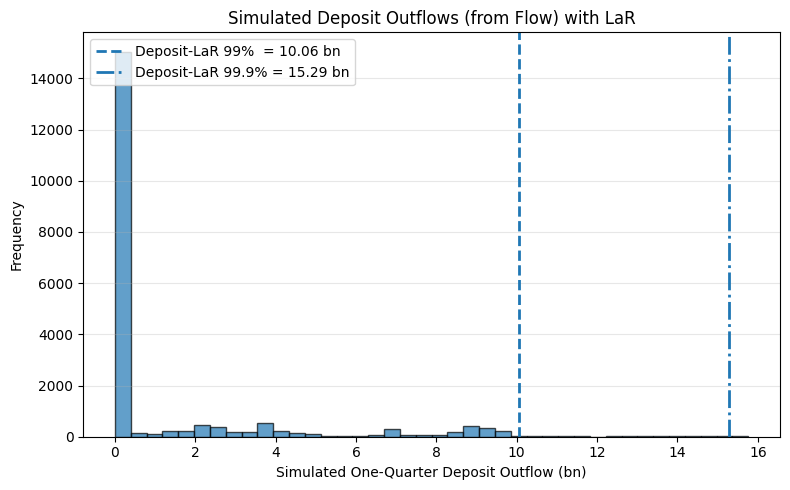

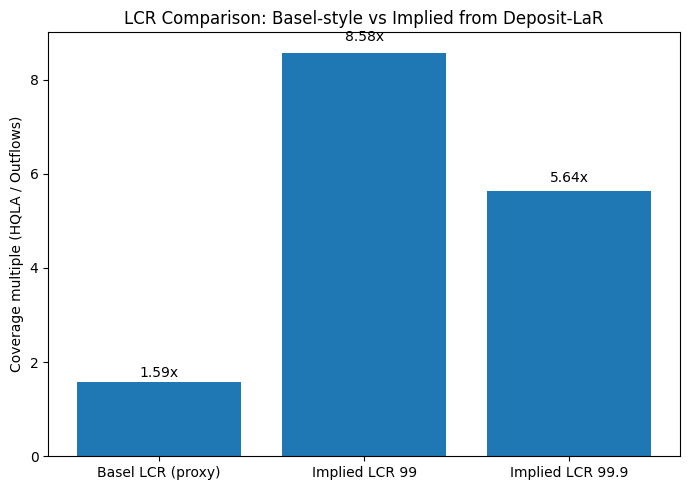

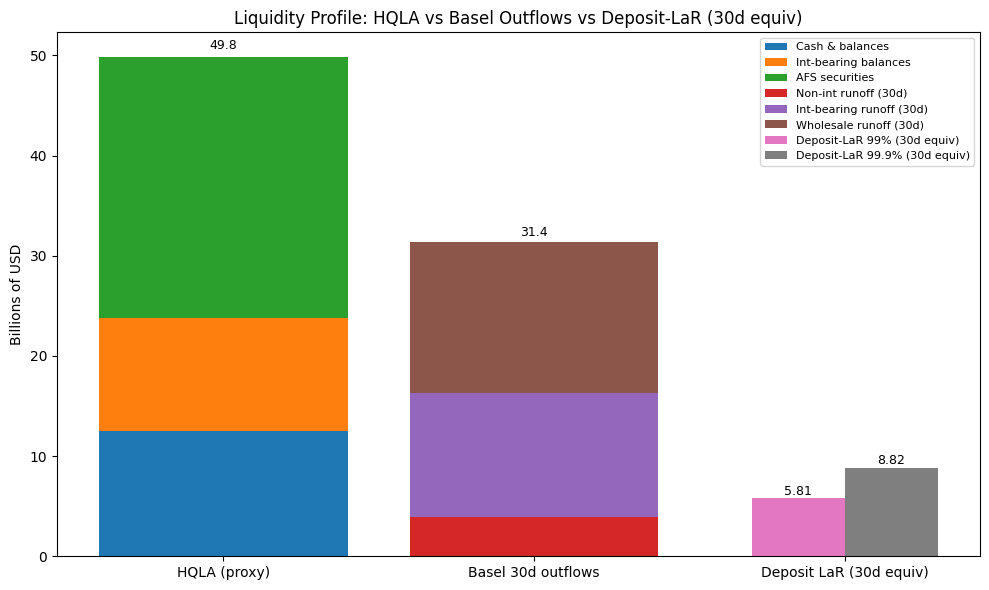

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Assumptions:
# - panel already contains (at least):
#   report_date, flow_total,
#   cash_and_balances, interest_bearing_balances, securities_afs_total,
#   total_deposits_domestic, nonint_deposits_domestic, intbearing_deposits_domestic,
#   fedfunds_purchased_domestic (optional), repos_sold_domestic (optional),
#   other_borrowed_money_domestic (optional)
# - flow_sim already exists from your copula simulation (same horizon as flow_total)
#   (If not, set flow_sim = df["flow_total"].values to use historical-only)
# ============================================================

# -----------------------------
# 0) Pick latest balance sheet
# -----------------------------
panel = panel.sort_values("report_date").reset_index(drop=True)
latest = panel.iloc[-1]

# -----------------------------
# 1) HQLA (simple proxy; billions)
#    (you said: Cash + Int-bearing balances + AFS)
# -----------------------------
cash_bn   = float(latest["cash_and_balances"]) / 1e6
ibbal_bn  = float(latest["interest_bearing_balances"]) / 1e6
afs_bn    = float(latest["securities_afs_total"]) / 1e6

HQLA_bn = cash_bn + ibbal_bn + afs_bn

# -----------------------------
# 2) Basel-style 30d net outflows (proxy)
# -----------------------------
nonint_dep_th = float(latest["nonint_deposits_domestic"])
int_dep_th    = float(latest["intbearing_deposits_domestic"])

fedfunds_th = float(latest.get("fedfunds_purchased_domestic", 0.0) or 0.0)
repos_th    = float(latest.get("repos_sold_domestic", 0.0) or 0.0)
other_borr_th = float(latest.get("other_borrowed_money_domestic", 0.0) or 0.0)

wholesale_base_th = fedfunds_th + repos_th + other_borr_th

# runoff factors (tune as you like)
runoff_nonint    = 0.05
runoff_int       = 0.15
runoff_wholesale = 1.00

outflow_nonint_bn    = (runoff_nonint * nonint_dep_th) / 1e6
outflow_int_bn       = (runoff_int * int_dep_th) / 1e6
outflow_wholesale_bn = (runoff_wholesale * wholesale_base_th) / 1e6

net_30d_outflow_bn = outflow_nonint_bn + outflow_int_bn + outflow_wholesale_bn
LCR_basel_proxy = HQLA_bn / net_30d_outflow_bn if net_30d_outflow_bn > 0 else np.inf

# -----------------------------
# 3) Deposit-LaR from your simulated FLOW
#    Convert 1-quarter flow -> outflow amount at t=0 deposits
# -----------------------------
D0_th = float(latest["total_deposits_domestic"])
D0_bn = D0_th / 1e6

# If flow_sim isn't defined, fall back to historical flow_total
if "flow_sim" not in globals():
    df_tmp = panel[["flow_total"]].dropna()
    flow_sim = df_tmp["flow_total"].values.astype(float)

# implied deposit outflow at horizon of flow_sim (quarterly)
D1_th = D0_th * (1.0 + np.asarray(flow_sim))
dep_outflow_th = np.maximum(D0_th - D1_th, 0.0)
dep_outflow_bn = dep_outflow_th / 1e6

LaR_99  = float(np.quantile(dep_outflow_bn, 0.99))
LaR_999 = float(np.quantile(dep_outflow_bn, 0.999))

# -----------------------------
# 4) “Implied LCR” from Deposit-LaR
#    Map quarter-horizon LaR -> 30d equivalent via sqrt(time)
#    30/90 ≈ 1/3 of a quarter
# -----------------------------
scale_30d_from_q = np.sqrt(30.0 / 90.0)

LaR99_30d_bn  = LaR_99  * scale_30d_from_q
LaR999_30d_bn = LaR_999 * scale_30d_from_q

LCR_implied_99  = HQLA_bn / LaR99_30d_bn  if LaR99_30d_bn  > 0 else np.inf
LCR_implied_999 = HQLA_bn / LaR999_30d_bn if LaR999_30d_bn > 0 else np.inf

# -----------------------------
# 5) Print key outputs
# -----------------------------
print("=== Latest snapshot ===")
print(f"Report date: {pd.to_datetime(latest['report_date']).date()}")
print(f"Total domestic deposits (bn): {D0_bn:.1f}")
print(f"HQLA proxy (bn):              {HQLA_bn:.1f}")
print("")
print("=== Basel-style LCR (proxy) ===")
print(f"30d net outflow (bn): {net_30d_outflow_bn:.1f}")
print(f"LCR_basel_proxy:      {LCR_basel_proxy:.2f}x")
print("")
print("=== Deposit-LaR (quarter horizon from FLOW) ===")
print(f"Deposit-LaR 99%  (bn):  {LaR_99:.2f}")
print(f"Deposit-LaR 99.9% (bn): {LaR_999:.2f}")
print("")
print("=== Implied LCR from Deposit-LaR (sqrt time to 30d) ===")
print(f"30d LaR99  (bn):  {LaR99_30d_bn:.2f}  -> Implied LCR99:  {LCR_implied_99:.2f}x")
print(f"30d LaR99.9(bn):  {LaR999_30d_bn:.2f} -> Implied LCR99.9:{LCR_implied_999:.2f}x")

# -----------------------------
# 6) Plots
# -----------------------------

# (A) Deposit outflow distribution with LaR lines (quarter horizon)
plt.figure(figsize=(8, 5))
plt.hist(dep_outflow_bn, bins=40, edgecolor="black", alpha=0.7)
plt.axvline(LaR_99,  linestyle="--", linewidth=2, label=f"Deposit-LaR 99%  = {LaR_99:.2f} bn")
plt.axvline(LaR_999, linestyle="-.", linewidth=2, label=f"Deposit-LaR 99.9% = {LaR_999:.2f} bn")
plt.xlabel("Simulated One-Quarter Deposit Outflow (bn)")
plt.ylabel("Frequency")
plt.title("Simulated Deposit Outflows (from Flow) with LaR")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# (B) LCR comparison bars (Basel proxy vs implied)
plt.figure(figsize=(7, 5))
bars = ["Basel LCR (proxy)", "Implied LCR 99", "Implied LCR 99.9"]
vals = [LCR_basel_proxy, LCR_implied_99, LCR_implied_999]
plt.bar(bars, vals)
plt.ylabel("Coverage multiple (HQLA / Outflows)")
plt.title("LCR Comparison: Basel-style vs Implied from Deposit-LaR")
for i, v in enumerate(vals):
    plt.text(i, v * 1.02, f"{v:.2f}x", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# (C) Stacked bars: HQLA components vs Basel outflows vs Deposit-LaR(30d)
labels = ["HQLA (proxy)", "Basel 30d outflows", "Deposit LaR (30d equiv)"]
xpos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 6))

# HQLA stack
ax.bar(xpos[0], cash_bn,  label="Cash & balances")
ax.bar(xpos[0], ibbal_bn, bottom=cash_bn, label="Int-bearing balances")
ax.bar(xpos[0], afs_bn,   bottom=cash_bn + ibbal_bn, label="AFS securities")

# Basel outflows stack
ax.bar(xpos[1], outflow_nonint_bn, label="Non-int runoff (30d)")
ax.bar(xpos[1], outflow_int_bn, bottom=outflow_nonint_bn, label="Int-bearing runoff (30d)")
ax.bar(xpos[1], outflow_wholesale_bn, bottom=outflow_nonint_bn + outflow_int_bn, label="Wholesale runoff (30d)")

# Deposit-LaR (30d equiv) bars (two lines shown as separate overlays)
ax.bar(xpos[2] - 0.15, LaR99_30d_bn,  width=0.3, label="Deposit-LaR 99% (30d equiv)")
ax.bar(xpos[2] + 0.15, LaR999_30d_bn, width=0.3, label="Deposit-LaR 99.9% (30d equiv)")

ax.set_xticks(xpos)
ax.set_xticklabels(labels)
ax.set_ylabel("Billions of USD")
ax.set_title("Liquidity Profile: HQLA vs Basel Outflows vs Deposit-LaR (30d equiv)")

# annotate totals
ax.text(xpos[0], HQLA_bn * 1.01, f"{HQLA_bn:.1f}", ha="center", va="bottom", fontsize=9)
ax.text(xpos[1], net_30d_outflow_bn * 1.01, f"{net_30d_outflow_bn:.1f}", ha="center", va="bottom", fontsize=9)
ax.text(xpos[2] - 0.15, LaR99_30d_bn * 1.01, f"{LaR99_30d_bn:.2f}", ha="center", va="bottom", fontsize=9)
ax.text(xpos[2] + 0.15, LaR999_30d_bn * 1.01, f"{LaR999_30d_bn:.2f}", ha="center", va="bottom", fontsize=9)

# de-dup legend entries
handles, labs = ax.get_legend_handles_labels()
seen = set()
uh, ul = [], []
for h, l in zip(handles, labs):
    if l not in seen:
        uh.append(h); ul.append(l); seen.add(l)
ax.legend(uh, ul, fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

## Deposit LaR/Deposit ILCR for different scenarios

n obs: 86
rho_t: -0.28728727687067757
D0 (domestic deposits): 161.5 bn, HQLA: 49.8 bn


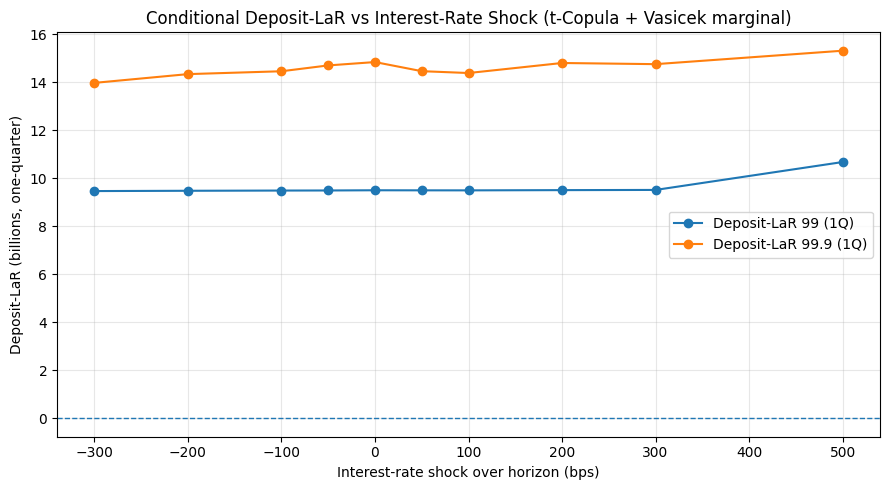

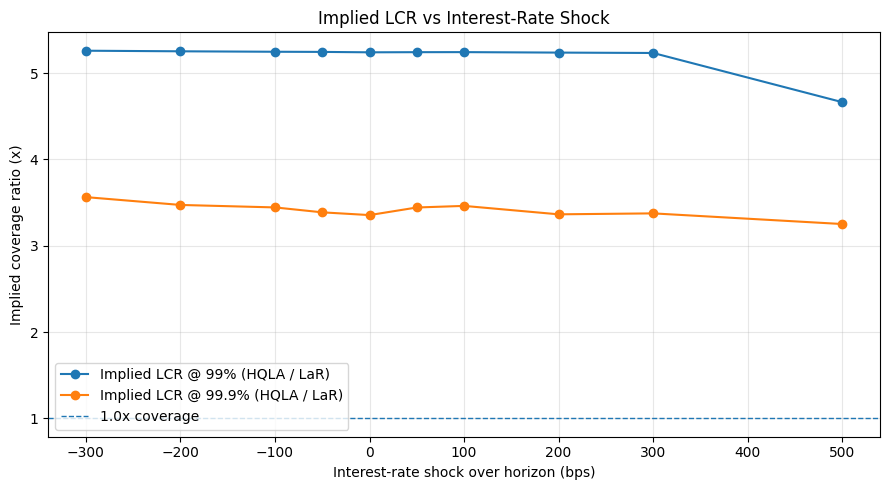

In [52]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# 0) Inputs / knobs
# =========================================================
num_sim = 50_000
shock_grid_bps = np.array([-300, -200, -100, -50, 0, 50, 100, 200, 300, 500])
alpha_99 = 0.99
alpha_999 = 0.999  # "99.9"

# IMPORTANT: make Vasicek horizon consistent with your flow horizon.
# If flow_total is quarterly pct_change, use T_horizon = 0.25 (1 quarter)
# If you purposely want 1-year horizon, then your flow should also be annualized.
T_horizon = 0.25

rng = np.random.default_rng(42)

# =========================================================
# 1) Refit / confirm t-copula parameters from (flow_total, fedfunds_change)
#     (using rank -> t-ppf latent)
# =========================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()
x = df["flow_total"].to_numpy()
y = df["fedfunds_change"].to_numpy()
n = len(df)
print("n obs:", n)

# rank uniforms
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n
eps = 1e-6
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# choose/keep df
nu = 10  # your choice; can sensitivity-check

t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)
rho_t = np.corrcoef(t_x, t_y)[0, 1]
print("rho_t:", rho_t)

# =========================================================
# 2) Vasicek marginal for the rate change over horizon T_horizon
#     r_T ~ Normal(m_T, std_T); shock is imposed as delta_r (bps)
# =========================================================
def vasicek_marginal_params(r0, a, b, sigma, T):
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return m_T, np.sqrt(v_T)

m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

# =========================================================
# 3) Balance sheet snapshot + HQLA (billions) for implied LCR
# =========================================================
latest = panel.sort_values("report_date").iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands

HQLA_th = (
    float(latest["cash_and_balances"])
    + float(latest["interest_bearing_balances"])
    + float(latest["securities_afs_total"])
)
HQLA_bn = HQLA_th / 1e6
D0_bn = D0_th / 1e6

print(f"D0 (domestic deposits): {D0_bn:.1f} bn, HQLA: {HQLA_bn:.1f} bn")

# =========================================================
# 4) Conditional sampler for bivariate t:
#     If (Tx,Ty) ~ t_nu(0, [[1,rho],[rho,1]]),
#     then Tx | Ty=ty is t_{nu+1} with:
#       mean = rho*ty
#       scale^2 = ( (nu + ty^2)/(nu+1) ) * (1 - rho^2)
# =========================================================
def sample_t_conditional_x_given_y(ty, rho, nu, size, rng):
    df_cond = nu + 1
    mu_cond = rho * ty
    scale2_cond = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale_cond = np.sqrt(scale2_cond)
    # sample from location-scale t_{nu+1}
    return mu_cond + scale_cond * stats.t.rvs(df=df_cond, size=size, random_state=rng)

def empirical_quantile(u, sample):
    return np.quantile(sample, u)

# =========================================================
# 5) Scenario loop: fix IR shock -> map to Ty* -> sample Tx|Ty*
#    -> map Tx -> Ux -> flow -> outflow -> LaR -> implied LCR
# =========================================================
LaR_99 = []
LaR_999 = []
LCR_99 = []
LCR_999 = []

for shock_bps in shock_grid_bps:
    shock = shock_bps / 10_000.0  # bps -> decimal
    
    # interpret "shock" as forcing r_T = r0 + shock over the horizon
    rT_star = r0 + shock
    
    # convert to copula-uniform using Vasicek marginal CDF for r_T
    u_y_star = stats.norm.cdf(rT_star, loc=m_T, scale=std_T)
    u_y_star = float(np.clip(u_y_star, eps, 1 - eps))
    
    # convert to latent Ty* in t-copula space
    t_y_star = float(stats.t.ppf(u_y_star, df=nu))
    
    # sample latent Tx conditional on Ty*
    t_x_cond = sample_t_conditional_x_given_y(t_y_star, rho_t, nu, num_sim, rng)
    
    # map latent Tx -> uniform via *marginal* t CDF with df=nu (copula margin)
    u_x_cond = stats.t.cdf(t_x_cond, df=nu)
    u_x_cond = np.clip(u_x_cond, eps, 1 - eps)
    
    # map to deposit flows via empirical marginal of historical flows
    flow_sim = empirical_quantile(u_x_cond, x)
    
    # compute outflows (one-quarter)
    D1_th = D0_th * (1.0 + flow_sim)
    outflow_th = np.maximum(D0_th - D1_th, 0.0)
    outflow_bn = outflow_th / 1e6
    
    lar99 = float(np.quantile(outflow_bn, alpha_99))
    lar999 = float(np.quantile(outflow_bn, alpha_999))
    
    LaR_99.append(lar99)
    LaR_999.append(lar999)
    
    # "Implied LCR" using LaR as the stressed outflow denominator
    # (This is NOT Basel LCR; it's your model-implied coverage at a chosen tail level.)
    LCR_99.append(HQLA_bn / lar99 if lar99 > 0 else np.inf)
    LCR_999.append(HQLA_bn / lar999 if lar999 > 0 else np.inf)

LaR_99 = np.array(LaR_99)
LaR_999 = np.array(LaR_999)
LCR_99 = np.array(LCR_99)
LCR_999 = np.array(LCR_999)

# =========================================================
# 6) Plots
# =========================================================
# (A) LaR vs shock
plt.figure(figsize=(9, 5))
plt.plot(shock_grid_bps, LaR_99, marker="o", label="Deposit-LaR 99 (1Q)")
plt.plot(shock_grid_bps, LaR_999, marker="o", label="Deposit-LaR 99.9 (1Q)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Deposit-LaR (billions, one-quarter)")
plt.title("Conditional Deposit-LaR vs Interest-Rate Shock (t-Copula + Vasicek marginal)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (B) Implied LCR vs shock
plt.figure(figsize=(9, 5))
plt.plot(shock_grid_bps, LCR_99, marker="o", label="Implied LCR @ 99% (HQLA / LaR)")
plt.plot(shock_grid_bps, LCR_999, marker="o", label="Implied LCR @ 99.9% (HQLA / LaR)")
plt.axhline(1.0, linestyle="--", linewidth=1, label="1.0x coverage")
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Implied coverage ratio (x)")
plt.title("Implied LCR vs Interest-Rate Shock")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Parametric Deposit Outflow Model


n flow obs: 87
Left-tail threshold u0 = -0.042855 (p_tail=10.00%), tail n=9
GPD fit on z=u0-x: xi=-0.2673, beta=0.027104


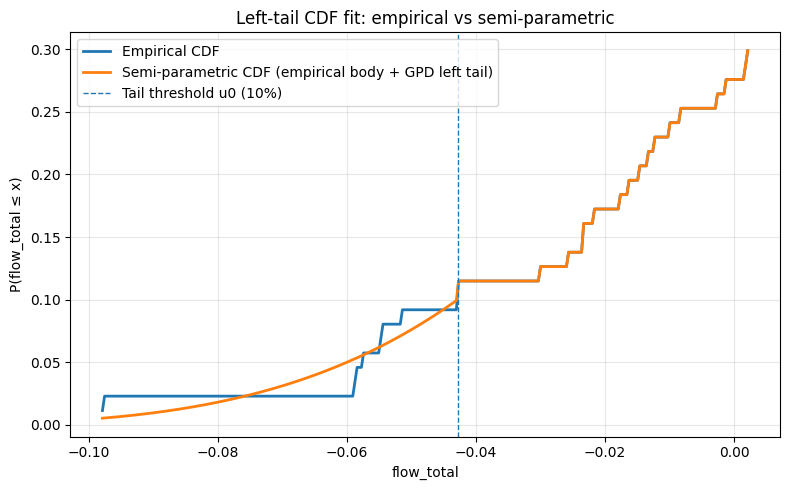

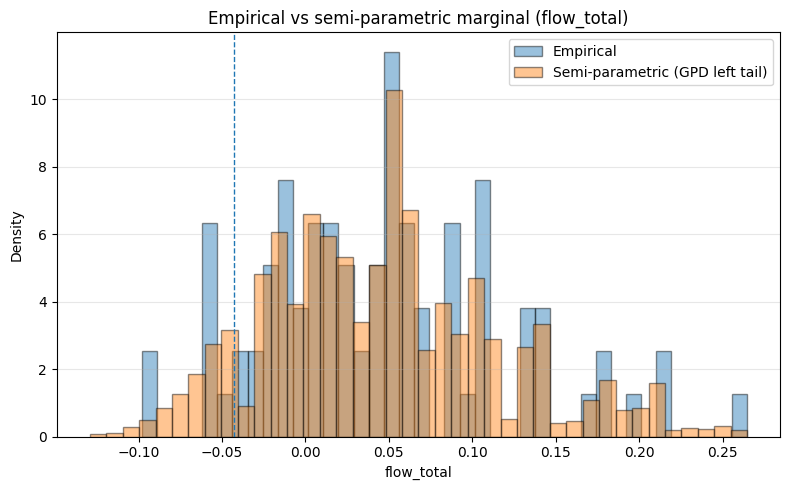

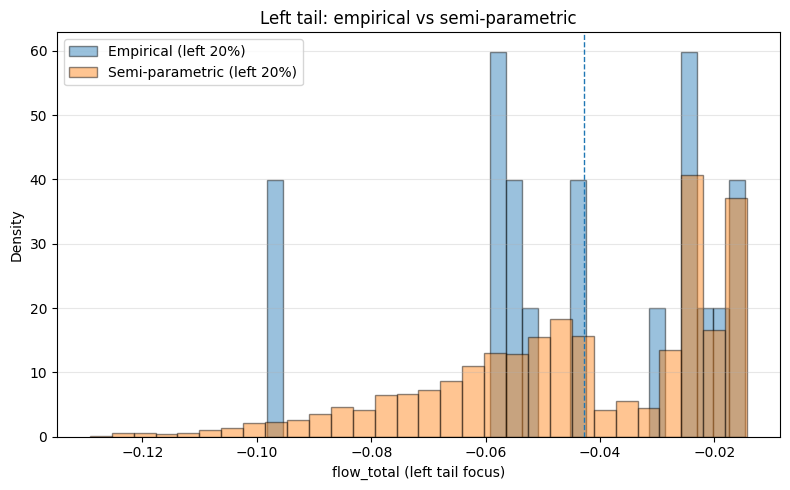

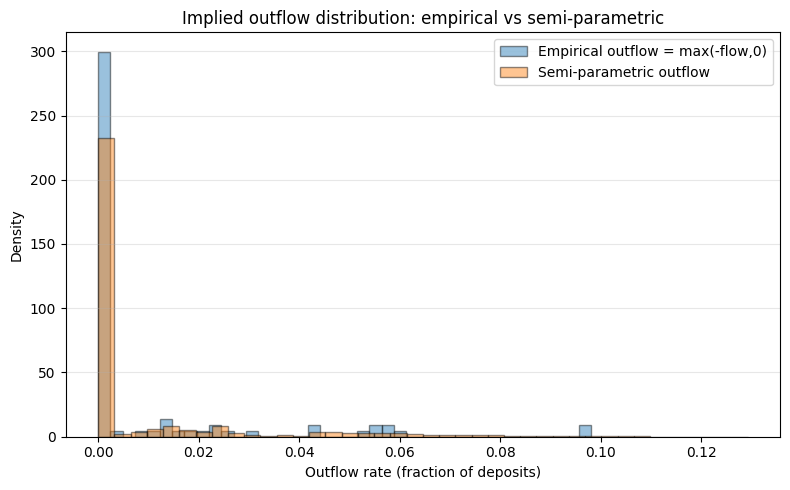

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ============================================
# 0) Data: quarterly total deposit flow
# ============================================
x = panel["flow_total"].astype(float).replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
x = np.sort(x)
n = len(x)
print("n flow obs:", n)

# ============================================
# 1) Choose a left-tail threshold (POT)
#    Example: 10th percentile (tune this; try 5%, 10%, 15%)
# ============================================
p_tail = 0.10
u0 = np.quantile(x, p_tail)           # threshold in flow units (likely negative)
tail_mask = x <= u0
x_tail = x[tail_mask]

# Transform left tail to positive exceedances:
# z = u0 - x  (so bigger z = more negative flow)
z = (u0 - x_tail)
z = z[z > 0]  # should be all >0 except possible ties at threshold

print(f"Left-tail threshold u0 = {u0:.6f} (p_tail={p_tail:.2%}), tail n={len(z)}")

# ============================================
# 2) Fit GPD to exceedances z (support z>0)
#    GPD parameters: shape xi, scale beta
# ============================================
# Force loc=0 so z ~ GPD(xi, scale=beta) on [0,∞)
xi_hat, loc_hat, beta_hat = stats.genpareto.fit(z, floc=0)
print(f"GPD fit on z=u0-x: xi={xi_hat:.4f}, beta={beta_hat:.6f}")

# Tail probability mass
p0 = p_tail

# ============================================
# 3) Define semi-parametric CDF F_hat(x)
#    - For x > u0: empirical CDF on full sample
#    - For x <= u0: p0 * (1 - GPD_CDF(u0-x))
# ============================================
def F_emp(val):
    # empirical CDF with plotting-position smoothing
    # returns P(X <= val)
    return (np.searchsorted(x, val, side="right")) / n

def F_hat(val):
    val = np.asarray(val)
    out = np.empty_like(val, dtype=float)

    # body region
    body = val > u0
    out[body] = np.array([F_emp(v) for v in val[body]])

    # left tail region
    tail = ~body
    z_val = (u0 - val[tail])
    # GPD CDF on z>=0
    G = stats.genpareto.cdf(z_val, c=xi_hat, loc=0, scale=beta_hat)
    out[tail] = p0 * (1.0 - G)

    # clip for numerical safety
    eps = 1e-12
    return np.clip(out, eps, 1 - eps)

# ============================================
# 4) Define semi-parametric quantile Q_hat(u)
#    - For u > p0: empirical quantile on full sample
#    - For u <= p0: invert tail: z = GPD_PPF(1 - u/p0); x = u0 - z
# ============================================
def Q_emp(u):
    return np.quantile(x, u)

def Q_hat(u):
    u = np.asarray(u, dtype=float)
    out = np.empty_like(u, dtype=float)

    body = u > p0
    out[body] = np.array([Q_emp(ui) for ui in u[body]])

    tail = ~body
    # u = p0*(1-G)  => G = 1 - u/p0
    G_level = 1.0 - (u[tail] / p0)
    # invert GPD CDF for z
    z_q = stats.genpareto.ppf(G_level, c=xi_hat, loc=0, scale=beta_hat)
    out[tail] = u0 - z_q

    return out

# ============================================
# 5) Visual diagnostics
#    (A) Left-tail CDF: empirical vs semi-parametric
# ============================================
grid = np.linspace(np.quantile(x, 0.01), np.quantile(x, 0.30), 300)
F_emp_grid = np.array([F_emp(g) for g in grid])
F_hat_grid = F_hat(grid)

plt.figure(figsize=(8, 5))
plt.plot(grid, F_emp_grid, label="Empirical CDF", linewidth=2)
plt.plot(grid, F_hat_grid, label="Semi-parametric CDF (empirical body + GPD left tail)", linewidth=2)
plt.axvline(u0, linestyle="--", linewidth=1, label=f"Tail threshold u0 ({p_tail:.0%})")
plt.xlabel("flow_total")
plt.ylabel("P(flow_total ≤ x)")
plt.title("Left-tail CDF fit: empirical vs semi-parametric")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# 6) Compare empirical vs semi-parametric simulated flows
# ============================================
m = 20000
u_sim = np.random.default_rng(0).uniform(size=m)
x_semi = Q_hat(u_sim)

plt.figure(figsize=(8, 5))
plt.hist(x, bins=40, density=True, alpha=0.45, edgecolor="black", label="Empirical")
plt.hist(x_semi, bins=40, density=True, alpha=0.45, edgecolor="black", label="Semi-parametric (GPD left tail)")
plt.axvline(u0, linestyle="--", linewidth=1)
plt.xlabel("flow_total")
plt.ylabel("Density")
plt.title("Empirical vs semi-parametric marginal (flow_total)")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# 7) Tail-focused comparison (more readable)
# ============================================
plt.figure(figsize=(8, 5))
plt.hist(x[x <= np.quantile(x, 0.20)], bins=30, density=True, alpha=0.45, edgecolor="black", label="Empirical (left 20%)")
plt.hist(x_semi[x_semi <= np.quantile(x_semi, 0.20)], bins=30, density=True, alpha=0.45, edgecolor="black", label="Semi-parametric (left 20%)")
plt.axvline(u0, linestyle="--", linewidth=1)
plt.xlabel("flow_total (left tail focus)")
plt.ylabel("Density")
plt.title("Left tail: empirical vs semi-parametric")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: translate to outflows (one-sided) and view tail
out_emp = np.maximum(-x, 0.0)
out_semi = np.maximum(-x_semi, 0.0)

plt.figure(figsize=(8, 5))
plt.hist(out_emp, bins=40, density=True, alpha=0.45, edgecolor="black", label="Empirical outflow = max(-flow,0)")
plt.hist(out_semi, bins=40, density=True, alpha=0.45, edgecolor="black", label="Semi-parametric outflow")
plt.xlabel("Outflow rate (fraction of deposits)")
plt.ylabel("Density")
plt.title("Implied outflow distribution: empirical vs semi-parametric")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

n obs: 86
t-copula correlation (rho_t): -0.28728727687067757
Semi-parametric left-tail fit:
  p_tail (threshold prob) = 0.100
  q_tail (flow threshold) = -0.036451
  GPD shape c             = -0.3191
  GPD scale               = 0.027990


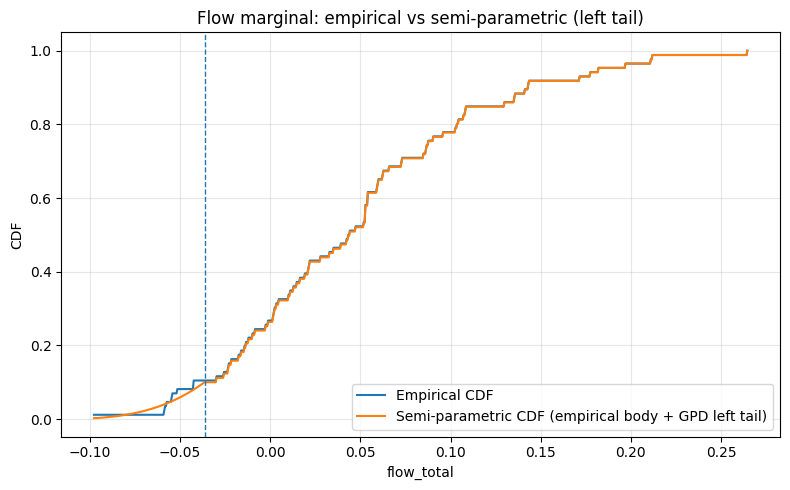

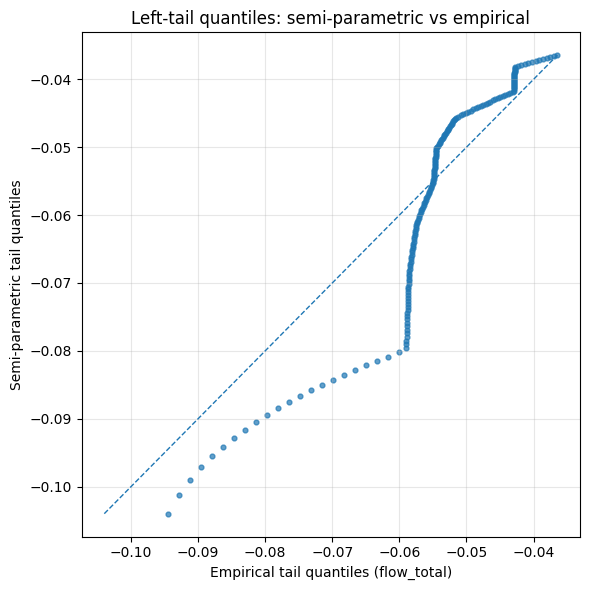

D0 (domestic deposits): 161.5 bn, HQLA: 49.8 bn


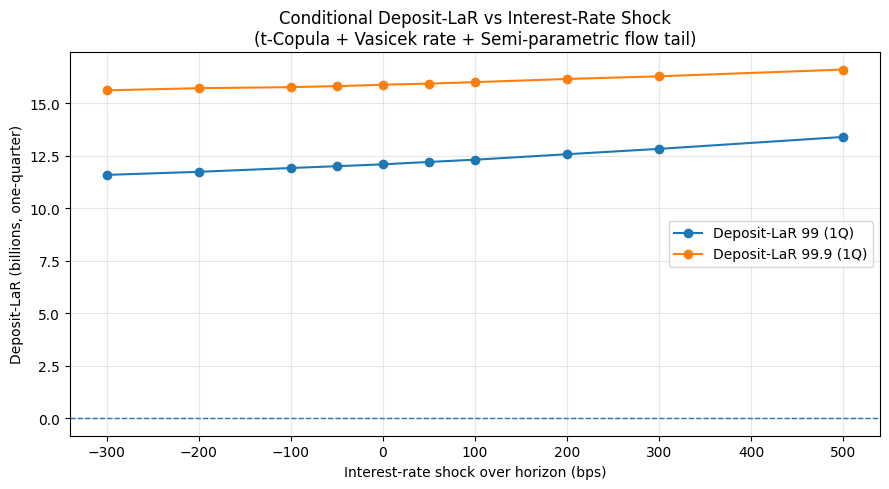

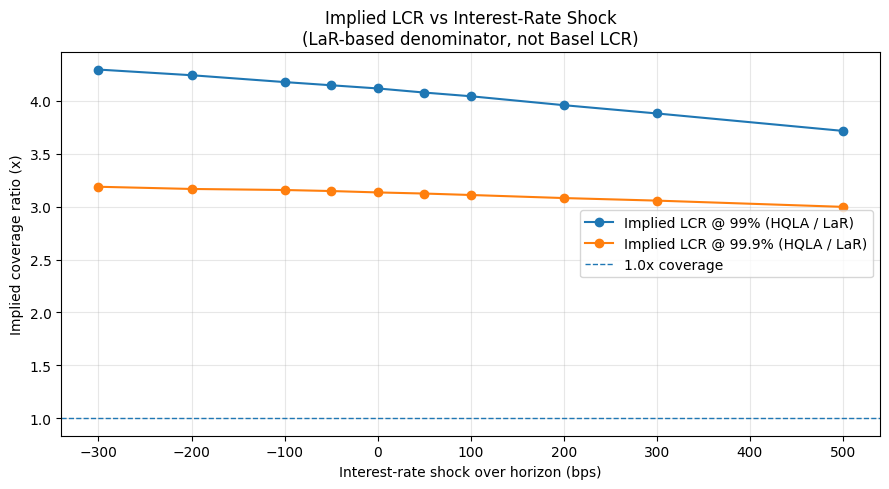

In [58]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# 0) Inputs / knobs
# =========================================================
num_sim = 5_000_000
shock_grid_bps = np.array([-300, -200, -100, -50, 0, 50, 100, 200, 300, 500])

alpha_99  = 0.99
alpha_999 = 0.999  # 99.9%

# IMPORTANT: if flow_total is quarterly pct_change, use T_horizon = 0.25 (1 quarter)
T_horizon = 0.25

# t-copula df
nu = 10

# Semi-parametric (left-tail) settings for deposit FLOW:
# model the *negative* tail (large outflows) with a GPD, keep the center empirical.
p_tail = 0.10  # tail probability for left tail threshold (e.g., 10% quantile)

eps = 1e-6
rng = np.random.default_rng(42)

# =========================================================
# 1) Data + t-copula fit from (flow_total, fedfunds_change)
# =========================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()
x = df["flow_total"].to_numpy()        # deposit flow (ratio)
y = df["fedfunds_change"].to_numpy()   # quarterly change in fed funds (% points or level units)

n = len(df)
print("n obs:", n)

# rank uniforms
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# latent t-variates
t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)

rho_t = np.corrcoef(t_x, t_y)[0, 1]
print("t-copula correlation (rho_t):", rho_t)

# =========================================================
# 2) Vasicek marginal for the rate level over horizon T_horizon
#     r_T ~ Normal(m_T, std_T); impose shocks via rT_star = r0 + shock
# =========================================================
def vasicek_marginal_params(r0, a, b, sigma, T):
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return m_T, np.sqrt(v_T)

m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

# =========================================================
# 3) Semi-parametric FLOW marginal: empirical body + GPD left tail
#     Left tail is X <= q_tail (negative/low flows). Define loss L = q_tail - X >= 0.
#     Fit GPD to L on tail observations; use it to define a smooth quantile function.
# =========================================================
q_tail = np.quantile(x, p_tail)
x_tail = x[x <= q_tail]
x_body = x[x >  q_tail]

if len(x_tail) < 20:
    print("Warning: very few tail observations; consider increasing sample or increasing p_tail.")
if len(x_body) < 20:
    print("Warning: very few body observations; consider decreasing p_tail.")

# Losses for left tail
loss = (q_tail - x_tail).astype(float)
loss = loss[loss >= 0]

# Fit GPD to losses with loc fixed at 0
# genpareto params: shape(c), loc, scale
c_hat, loc_hat, scale_hat = stats.genpareto.fit(loss, floc=0.0)

print("Semi-parametric left-tail fit:")
print(f"  p_tail (threshold prob) = {p_tail:.3f}")
print(f"  q_tail (flow threshold) = {q_tail:.6f}")
print(f"  GPD shape c             = {c_hat:.4f}")
print(f"  GPD scale               = {scale_hat:.6f}")

def semiparam_flow_ppf(u):
    """
    Quantile function for FLOW:
      - for u in [0, p_tail]: left tail via GPD on losses
      - for u in (p_tail, 1]: empirical body quantiles
    Ensures continuity at q_tail.
    """
    u = np.asarray(u, dtype=float)
    u = np.clip(u, eps, 1 - eps)

    out = np.empty_like(u)

    # tail region
    m_tail = (u <= p_tail)
    if np.any(m_tail):
        # c = u/p_tail in [0,1]
        c = u[m_tail] / p_tail
        # For x <= q_tail: F(x)=p_tail*(1 - GPD_CDF(q_tail - x))
        # Invert: x = q_tail - GPD_PPF(1 - c)
        out[m_tail] = q_tail - stats.genpareto.ppf(1.0 - c, c_hat, loc=0.0, scale=scale_hat)

    # body region
    m_body = ~m_tail
    if np.any(m_body):
        c = (u[m_body] - p_tail) / (1.0 - p_tail)  # map to (0,1)
        out[m_body] = np.quantile(x_body, c)

    return out

# ---- Visual check of semi-parametric marginal vs empirical ----
# (A) CDF overlay (empirical vs semi-parametric)
x_grid = np.linspace(np.min(x), np.max(x), 800)

# empirical CDF
x_sorted = np.sort(x)
F_emp = np.searchsorted(x_sorted, x_grid, side="right") / len(x_sorted)

# semi-parametric CDF (piecewise)
def semiparam_flow_cdf(xv):
    xv = np.asarray(xv, dtype=float)
    F = np.empty_like(xv)

    m_tail = (xv <= q_tail)
    if np.any(m_tail):
        # F(x)=p_tail*(1 - GPD_CDF(q_tail - x))
        L = q_tail - xv[m_tail]
        F[m_tail] = p_tail * (1.0 - stats.genpareto.cdf(L, c_hat, loc=0.0, scale=scale_hat))

    m_body = ~m_tail
    if np.any(m_body):
        # body: empirical conditional CDF on x_body
        body_sorted = np.sort(x_body)
        # conditional CDF in body: P(X<=x | X>q_tail)
        F_cond = np.searchsorted(body_sorted, xv[m_body], side="right") / len(body_sorted)
        F[m_body] = p_tail + (1.0 - p_tail) * F_cond

    return np.clip(F, 0.0, 1.0)

F_sp = semiparam_flow_cdf(x_grid)

plt.figure(figsize=(8, 5))
plt.plot(x_grid, F_emp, label="Empirical CDF")
plt.plot(x_grid, F_sp,  label="Semi-parametric CDF (empirical body + GPD left tail)")
plt.axvline(q_tail, linestyle="--", linewidth=1)
plt.xlabel("flow_total")
plt.ylabel("CDF")
plt.title("Flow marginal: empirical vs semi-parametric (left tail)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (B) Tail QQ-ish: compare empirical tail quantiles vs semi-parametric tail quantiles
p_check = np.linspace(0.001, p_tail, 200)
q_emp_tail = np.quantile(x, p_check)
q_sp_tail  = semiparam_flow_ppf(p_check)

plt.figure(figsize=(6, 6))
plt.scatter(q_emp_tail, q_sp_tail, s=12, alpha=0.7)
mn = min(q_emp_tail.min(), q_sp_tail.min())
mx = max(q_emp_tail.max(), q_sp_tail.max())
plt.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)
plt.xlabel("Empirical tail quantiles (flow_total)")
plt.ylabel("Semi-parametric tail quantiles")
plt.title("Left-tail quantiles: semi-parametric vs empirical")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =========================================================
# 4) Balance sheet snapshot + HQLA (billions) for implied LCR
# =========================================================
latest = panel.sort_values("report_date").iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands

HQLA_th = (
    float(latest["cash_and_balances"])
    + float(latest["interest_bearing_balances"])
    + float(latest["securities_afs_total"])
)
HQLA_bn = HQLA_th / 1e6
D0_bn   = D0_th   / 1e6

print(f"D0 (domestic deposits): {D0_bn:.1f} bn, HQLA: {HQLA_bn:.1f} bn")

# =========================================================
# 5) Conditional sampler for bivariate t:
#     If (Tx,Ty) ~ t_nu(0, [[1,rho],[rho,1]]),
#     then Tx | Ty=ty is t_{nu+1} with:
#       mean = rho*ty
#       scale^2 = ( (nu + ty^2)/(nu+1) ) * (1 - rho^2)
# =========================================================
def sample_t_conditional_x_given_y(ty, rho, nu, size, rng):
    df_cond = nu + 1
    mu_cond = rho * ty
    scale2_cond = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale_cond = np.sqrt(scale2_cond)
    return mu_cond + scale_cond * stats.t.rvs(df=df_cond, size=size, random_state=rng)

# =========================================================
# 6) Scenario loop: fix IR shock -> map to Ty* -> sample Tx|Ty*
#    -> map Tx -> Ux -> FLOW via semi-parametric marginal -> outflow -> LaR -> implied LCR
# =========================================================
LaR_99  = []
LaR_999 = []
LCR_99  = []
LCR_999 = []

for shock_bps in shock_grid_bps:
    shock = shock_bps / 10_000.0  # bps -> decimal

    # impose r_T = r0 + shock over horizon
    rT_star = r0 + shock

    # map to copula-uniform via Vasicek marginal CDF for r_T
    u_y_star = stats.norm.cdf(rT_star, loc=m_T, scale=std_T)
    u_y_star = float(np.clip(u_y_star, eps, 1 - eps))

    # latent Ty*
    t_y_star = float(stats.t.ppf(u_y_star, df=nu))

    # sample latent Tx | Ty*
    t_x_cond = sample_t_conditional_x_given_y(t_y_star, rho_t, nu, num_sim, rng)

    # latent Tx -> uniform (copula margin)
    u_x_cond = stats.t.cdf(t_x_cond, df=nu)
    u_x_cond = np.clip(u_x_cond, eps, 1 - eps)

    # FLOW from semi-parametric marginal (empirical body + GPD left tail)
    flow_sim = semiparam_flow_ppf(u_x_cond)

    # one-quarter outflows (bn)
    D1_th = D0_th * (1.0 + flow_sim)
    outflow_th = np.maximum(D0_th - D1_th, 0.0)
    outflow_bn = outflow_th / 1e6

    lar99  = float(np.quantile(outflow_bn, alpha_99))
    lar999 = float(np.quantile(outflow_bn, alpha_999))

    LaR_99.append(lar99)
    LaR_999.append(lar999)

    LCR_99.append(HQLA_bn / lar99 if lar99 > 0 else np.inf)
    LCR_999.append(HQLA_bn / lar999 if lar999 > 0 else np.inf)

LaR_99  = np.array(LaR_99)
LaR_999 = np.array(LaR_999)
LCR_99  = np.array(LCR_99)
LCR_999 = np.array(LCR_999)

# =========================================================
# 7) Plots
# =========================================================
plt.figure(figsize=(9, 5))
plt.plot(shock_grid_bps, LaR_99,  marker="o", label="Deposit-LaR 99 (1Q)")
plt.plot(shock_grid_bps, LaR_999, marker="o", label="Deposit-LaR 99.9 (1Q)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Deposit-LaR (billions, one-quarter)")
plt.title("Conditional Deposit-LaR vs Interest-Rate Shock\n(t-Copula + Vasicek rate + Semi-parametric flow tail)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.plot(shock_grid_bps, LCR_99,  marker="o", label="Implied LCR @ 99% (HQLA / LaR)")
plt.plot(shock_grid_bps, LCR_999, marker="o", label="Implied LCR @ 99.9% (HQLA / LaR)")
plt.axhline(1.0, linestyle="--", linewidth=1, label="1.0x coverage")
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Implied coverage ratio (x)")
plt.title("Implied LCR vs Interest-Rate Shock\n(LaR-based denominator, not Basel LCR)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

n obs: 86
rho_t_hat: -0.28728727687067757
Shock fixed at 300 bps => rT_star=6.6800%, u_y_star=0.681779, t_y_star=0.487
D0 (domestic deposits): 161.5 bn, HQLA: 49.8 bn
Left-tail GPD fit:
  threshold u        = -0.03645
  tail mass p_tail   = 0.105
  xi_hat (shape)     = -0.319
  beta_hat (scale)   = 0.02799


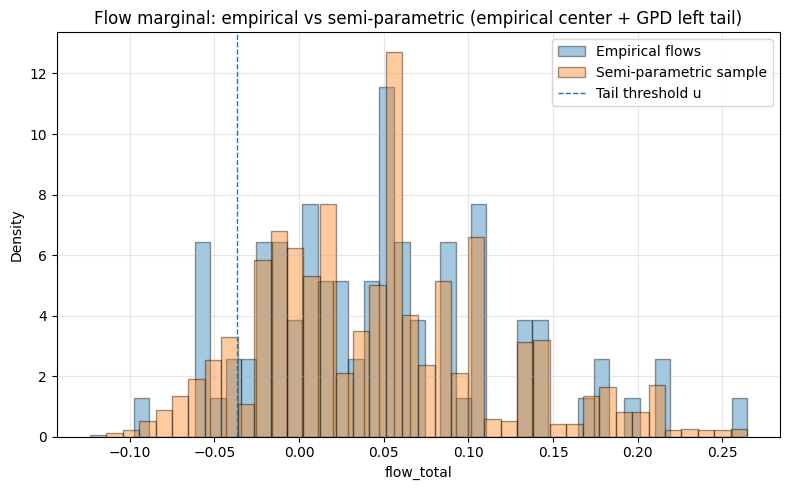

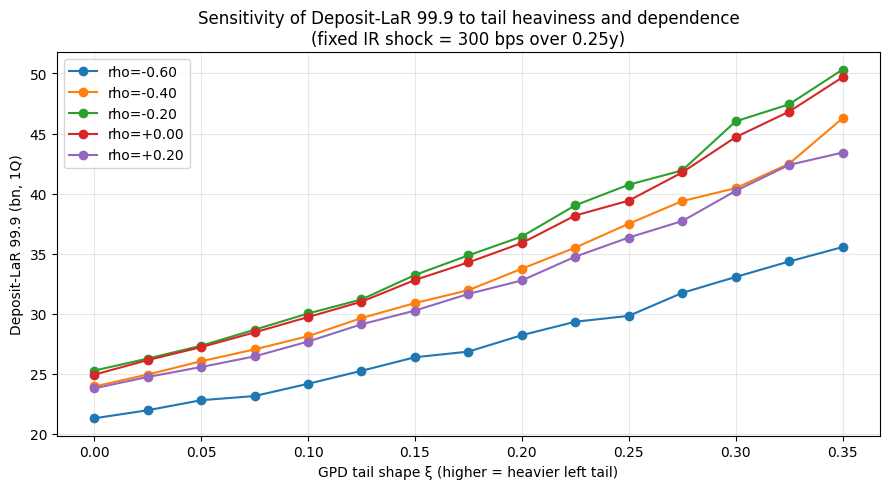

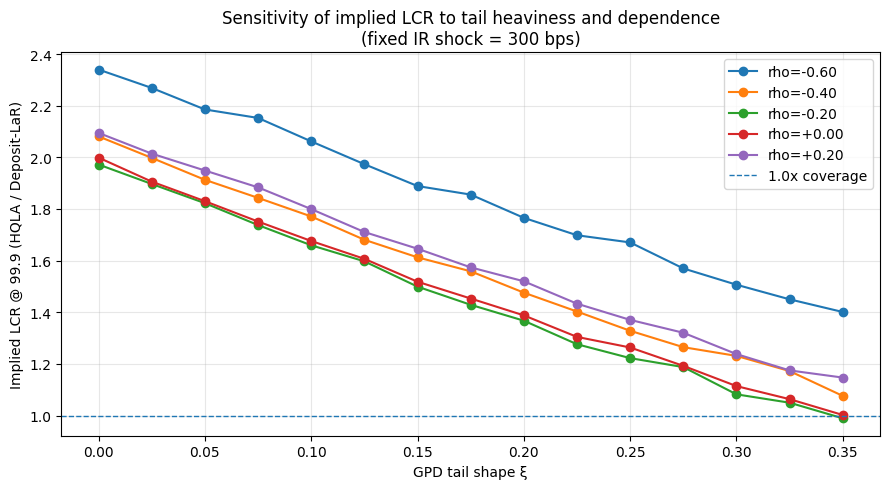

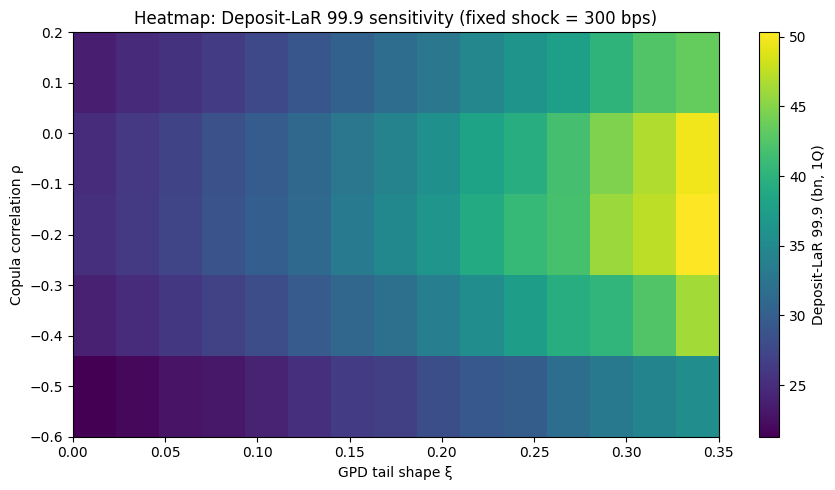

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# 0) USER KNOBS
# =========================================================
num_sim = 1_000_000
nu = 10                         # t-copula df
T_horizon = 0.25                # quarter horizon if flow_total is quarterly pct_change
shock_bps_fixed = 300           # scenario: force r_T = r0 + shock over the horizon

alpha_99  = 0.99
alpha_999 = 0.999

# Sensitivity grids
xi_grid  = np.linspace(0.00, 0.35, 15)                 # tail heaviness (GPD shape)
rho_grid = np.array([-0.60, -0.40, -0.20, 0.00, 0.20])  # dependence sensitivity

rng = np.random.default_rng(42)
eps = 1e-8

# =========================================================
# 1) Data for copula fit
# =========================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()
x_hist = df["flow_total"].to_numpy()
y_hist = df["fedfunds_change"].to_numpy()
n = len(df)
print("n obs:", n)

# Rank uniforms
u_x = (stats.rankdata(x_hist, method="average") - 0.5) / n
u_y = (stats.rankdata(y_hist, method="average") - 0.5) / n
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# Latent t variates and base rho_t estimate
t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)
rho_t_hat = np.corrcoef(t_x, t_y)[0, 1]
print("rho_t_hat:", rho_t_hat)

# =========================================================
# 2) Vasicek marginal for rate over horizon T_horizon
# =========================================================
def vasicek_marginal_params(r0, a, b, sigma, T):
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return m_T, np.sqrt(v_T)

m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

# Fixed shock -> target r_T*
shock = shock_bps_fixed / 10_000.0
rT_star = r0 + shock
u_y_star = stats.norm.cdf(rT_star, loc=m_T, scale=std_T)
u_y_star = float(np.clip(u_y_star, eps, 1 - eps))
t_y_star = float(stats.t.ppf(u_y_star, df=nu))

print(f"Shock fixed at {shock_bps_fixed} bps => rT_star={rT_star:.4%}, u_y_star={u_y_star:.6f}, t_y_star={t_y_star:.3f}")

# =========================================================
# 3) Balance sheet snapshot + HQLA (billions)
# =========================================================
latest = panel.sort_values("report_date").iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands

HQLA_th = (
    float(latest["cash_and_balances"])
    + float(latest["interest_bearing_balances"])
    + float(latest["securities_afs_total"])
)
HQLA_bn = HQLA_th / 1e6
D0_bn = D0_th / 1e6
print(f"D0 (domestic deposits): {D0_bn:.1f} bn, HQLA: {HQLA_bn:.1f} bn")

# =========================================================
# 4) Conditional sampler: Tx | Ty=ty for bivariate t-copula
# =========================================================
def sample_t_conditional_x_given_y(ty, rho, nu, size, rng):
    """
    (Tx,Ty) ~ t_nu(0, [[1,rho],[rho,1]])
    => Tx | Ty=ty is t_{nu+1} with:
       mean = rho*ty
       scale^2 = ((nu + ty^2)/(nu+1)) * (1 - rho^2)
    """
    df_cond = nu + 1
    mu_cond = rho * ty
    scale2  = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale   = np.sqrt(scale2)

    z = rng.standard_t(df_cond, size=size)  # standard t with df_cond
    return mu_cond + scale * z

# =========================================================
# 5) Semi-parametric flow marginal:
#    Empirical center + GPD for LEFT tail (negative flows)
# =========================================================
def fit_left_tail_gpd(x, tail_q=0.10):
    """
    Fit a left-tail GPD to flows x:
      - threshold u = quantile(tail_q)
      - exceedance L = u - x for x<u  (so L>0)
      - fit GPD to L
    Returns: u, p_tail, (xi_hat, scale_hat)
    """
    u = np.quantile(x, tail_q)
    tail = x[x < u]
    p_tail = len(tail) / len(x)

    L = (u - tail)  # exceedances (positive)
    # Fit genpareto: params (c=xi, loc, scale). Force loc=0.
    xi_hat, loc_hat, scale_hat = stats.genpareto.fit(L, floc=0)
    return float(u), float(p_tail), float(xi_hat), float(scale_hat)

u_thresh, p_tail, xi_hat, beta_hat = fit_left_tail_gpd(x_hist, tail_q=0.10)
print(f"Left-tail GPD fit:")
print(f"  threshold u        = {u_thresh:.5f}")
print(f"  tail mass p_tail   = {p_tail:.3f}")
print(f"  xi_hat (shape)     = {xi_hat:.3f}")
print(f"  beta_hat (scale)   = {beta_hat:.5f}")

def semi_parametric_quantile_lefttail(u, x_center_sample, u_thresh, p_tail, xi, beta):
    """
    Map uniforms u in (0,1) to flows:
      - if u <= p_tail: use GPD left-tail (below u_thresh)
      - else: use empirical quantile on full sample (center/right)
    Ensures continuity at u=p_tail (returns u_thresh).
    """
    u = np.asarray(u)
    out = np.empty_like(u, dtype=float)

    # Center (including right tail) via empirical quantile
    mask_center = (u > p_tail)
    out[mask_center] = np.quantile(x_center_sample, u[mask_center])

    # Left tail: x = u_thresh - Q_L(1 - v), where v = u/p_tail, L~GPD(xi,beta)
    mask_tail = ~mask_center
    v = np.clip(u[mask_tail] / max(p_tail, eps), eps, 1 - eps)
    qL = stats.genpareto.ppf(1.0 - v, c=xi, loc=0.0, scale=beta)  # >=0
    out[mask_tail] = u_thresh - qL
    return out

# Quick visual check of the semi-parametric fit (optional)
u_grid = np.linspace(eps, 1 - eps, 2000)
x_sp_base = semi_parametric_quantile_lefttail(u_grid, x_hist, u_thresh, p_tail, xi_hat, beta_hat)

plt.figure(figsize=(8,5))
plt.hist(x_hist, bins=40, density=True, alpha=0.4, edgecolor="black", label="Empirical flows")
plt.hist(x_sp_base, bins=40, density=True, alpha=0.4, edgecolor="black", label="Semi-parametric sample")
plt.axvline(u_thresh, linestyle="--", linewidth=1, label="Tail threshold u")
plt.title("Flow marginal: empirical vs semi-parametric (empirical center + GPD left tail)")
plt.xlabel("flow_total")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =========================================================
# 6) Sensitivity loop over (xi, rho)
# =========================================================
LaR99  = np.zeros((len(rho_grid), len(xi_grid)))
LaR999 = np.zeros((len(rho_grid), len(xi_grid)))
LCR99  = np.zeros((len(rho_grid), len(xi_grid)))
LCR999 = np.zeros((len(rho_grid), len(xi_grid)))

for i_r, rho in enumerate(rho_grid):
    for j_xi, xi in enumerate(xi_grid):

        # 1) Conditional latent Tx | Ty=t_y_star under rho
        t_x_cond = sample_t_conditional_x_given_y(t_y_star, rho, nu, num_sim, rng)

        # 2) Back to uniform via marginal t CDF
        u_x_cond = stats.t.cdf(t_x_cond, df=nu)
        u_x_cond = np.clip(u_x_cond, eps, 1 - eps)

        # 3) Map uniforms to flows via semi-parametric marginal (with xi override)
        flow_sim = semi_parametric_quantile_lefttail(
            u_x_cond, x_hist,
            u_thresh=u_thresh, p_tail=p_tail,
            xi=xi, beta=beta_hat
        )

        # 4) Convert flows -> outflows (one quarter)
        D1_th = D0_th * (1.0 + flow_sim)
        outflow_th = np.maximum(D0_th - D1_th, 0.0)
        outflow_bn = outflow_th / 1e6

        lar99  = float(np.quantile(outflow_bn, alpha_99))
        lar999 = float(np.quantile(outflow_bn, alpha_999))

        LaR99[i_r, j_xi]  = lar99
        LaR999[i_r, j_xi] = lar999
        LCR99[i_r, j_xi]  = HQLA_bn / lar99  if lar99  > 0 else np.inf
        LCR999[i_r, j_xi] = HQLA_bn / lar999 if lar999 > 0 else np.inf

# =========================================================
# 7) Visualizations
# =========================================================

# (A) Lines: LaR99.9 vs xi, separate lines for rho
plt.figure(figsize=(9,5))
for i_r, rho in enumerate(rho_grid):
    plt.plot(xi_grid, LaR999[i_r, :], marker="o", label=f"rho={rho:+.2f}")
plt.xlabel("GPD tail shape ξ (higher = heavier left tail)")
plt.ylabel("Deposit-LaR 99.9 (bn, 1Q)")
plt.title(f"Sensitivity of Deposit-LaR 99.9 to tail heaviness and dependence\n(fixed IR shock = {shock_bps_fixed} bps over {T_horizon}y)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (B) Lines: Implied LCR@99.9 vs xi
plt.figure(figsize=(9,5))
for i_r, rho in enumerate(rho_grid):
    plt.plot(xi_grid, LCR999[i_r, :], marker="o", label=f"rho={rho:+.2f}")
plt.axhline(1.0, linestyle="--", linewidth=1, label="1.0x coverage")
plt.xlabel("GPD tail shape ξ")
plt.ylabel("Implied LCR @ 99.9 (HQLA / Deposit-LaR)")
plt.title(f"Sensitivity of implied LCR to tail heaviness and dependence\n(fixed IR shock = {shock_bps_fixed} bps)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (C) Optional heatmap: LaR99.9
plt.figure(figsize=(9,5))
plt.imshow(
    LaR999,
    aspect="auto",
    origin="lower",
    extent=[xi_grid.min(), xi_grid.max(), rho_grid.min(), rho_grid.max()],
)
plt.colorbar(label="Deposit-LaR 99.9 (bn, 1Q)")
plt.xlabel("GPD tail shape ξ")
plt.ylabel("Copula correlation ρ")
plt.title(f"Heatmap: Deposit-LaR 99.9 sensitivity (fixed shock = {shock_bps_fixed} bps)")
plt.tight_layout()
plt.show()

n obs: 86
rho_t_hat: -0.28728727687067757
D0 (domestic deposits): 161.5 bn, HQLA: 49.8 bn
Left-tail GPD fit: u=-0.03645, p_tail=0.105, xi_hat=-0.319, beta_hat=0.02799

=== Regime: No shock (0 bps) ===


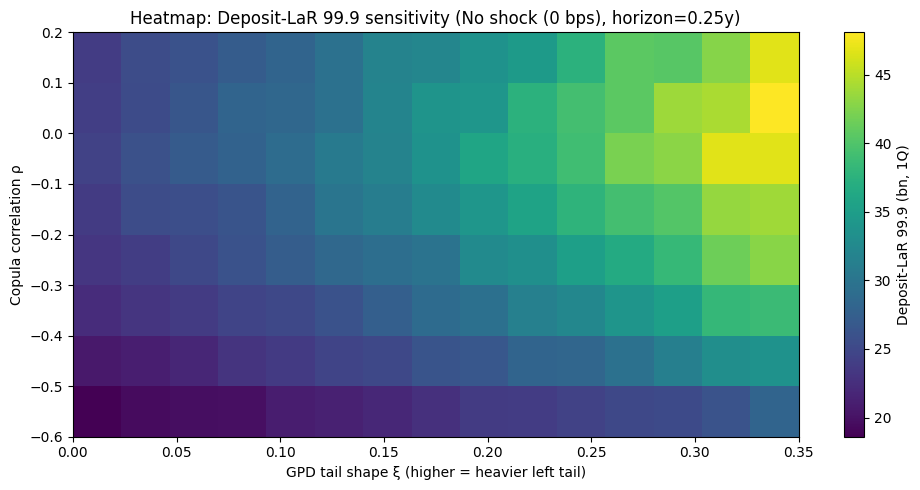

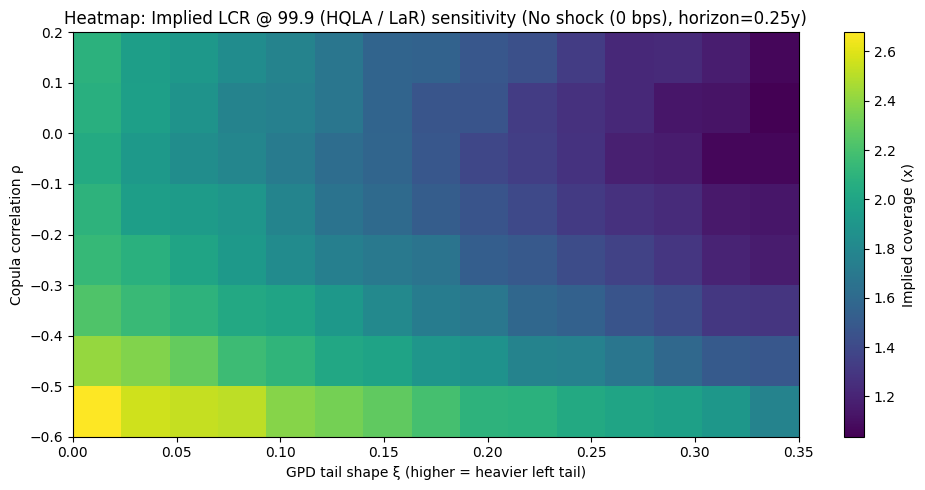


=== Regime: Positive shock (+100 bps) ===


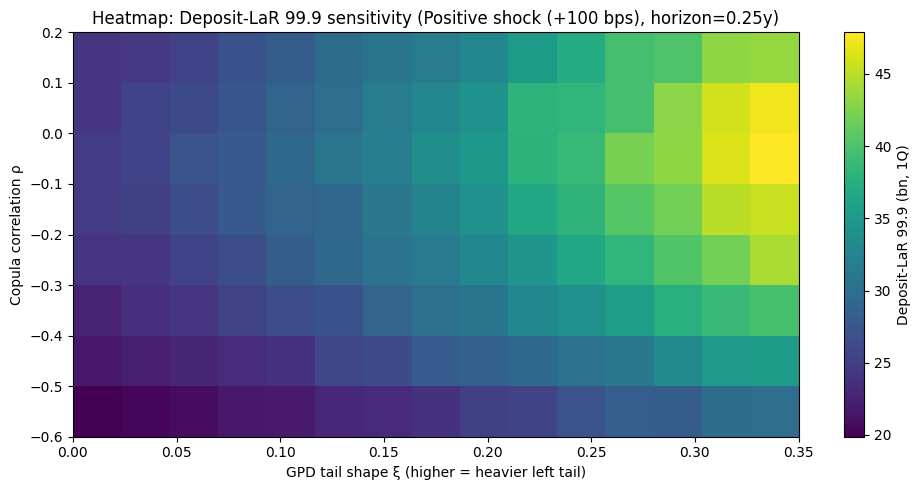

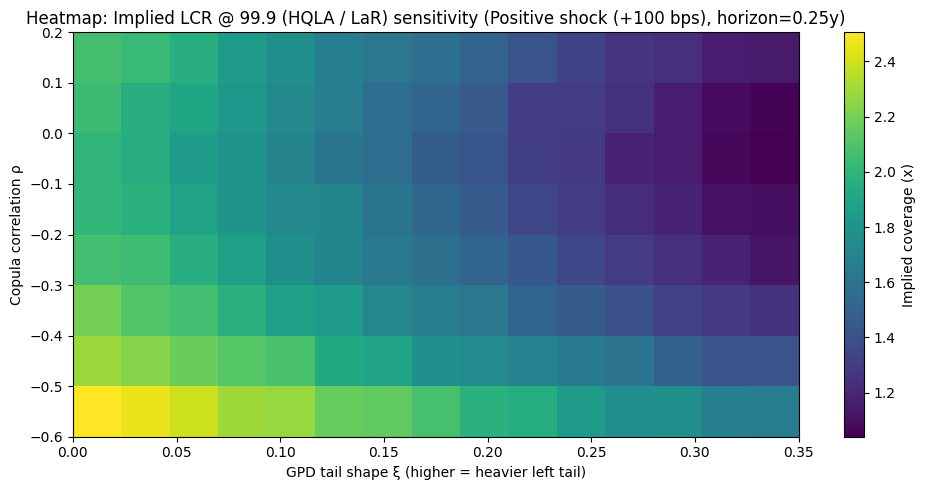


=== Regime: Negative shock (-100 bps) ===


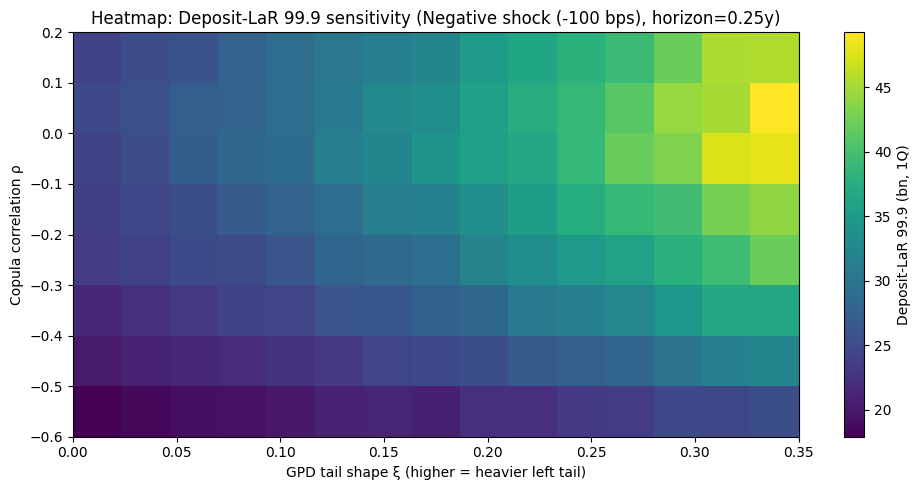

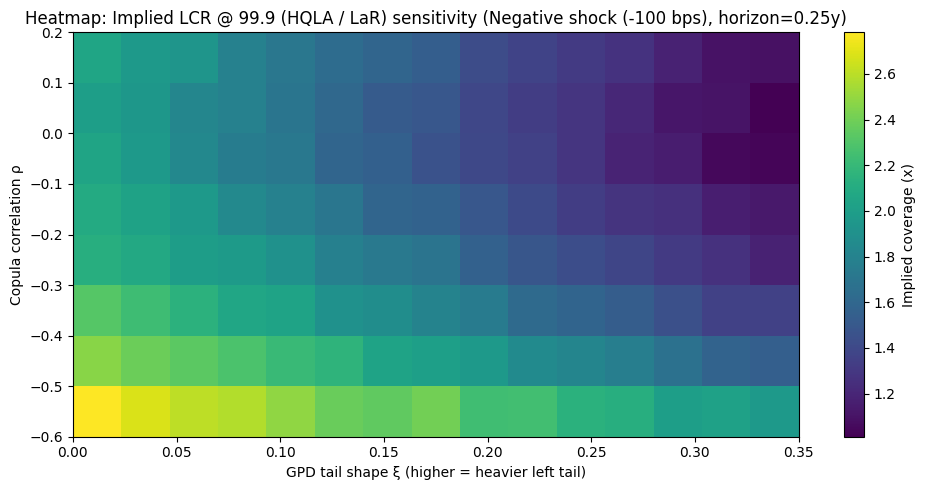

In [64]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# ASSUMES YOU ALREADY HAVE:
#   - panel with columns: flow_total, fedfunds_change, total_deposits_domestic,
#       cash_and_balances, interest_bearing_balances, securities_afs_total
#   - Vasicek params already estimated: r0, a, b, sigma
# =========================================================

# =========================================================
# 0) USER KNOBS
# =========================================================
num_sim   = 300_000            # bump to 1_000_000 if you want (slow)
nu        = 10                 # t-copula df
T_horizon = 0.25               # quarter horizon (consistent with flow_total pct_change)

alpha_999 = 0.999              # 99.9% tail
xi_grid   = np.linspace(0.00, 0.35, 15)
rho_grid  = np.array([-0.60, -0.50, -0.40, -0.30, -0.20, 0.00, 0.10, 0.20])

# Regimes (bps): no shock, positive shock, negative shock
shock_regimes_bps = {
    "No shock (0 bps)": 0,
    "Positive shock (+100 bps)": 100,
    "Negative shock (-100 bps)": -100,
}

eps = 1e-8
rng = np.random.default_rng(42)

# =========================================================
# 1) Fit copula ingredients from (flow_total, fedfunds_change)
# =========================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()
x_hist = df["flow_total"].to_numpy()
y_hist = df["fedfunds_change"].to_numpy()
n = len(df)
print("n obs:", n)

# rank uniforms
u_x = (stats.rankdata(x_hist, method="average") - 0.5) / n
u_y = (stats.rankdata(y_hist, method="average") - 0.5) / n
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# latent t variates
t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)
rho_t_hat = float(np.corrcoef(t_x, t_y)[0, 1])
print("rho_t_hat:", rho_t_hat)

# =========================================================
# 2) Vasicek marginal for r_T over horizon T_horizon
# =========================================================
def vasicek_marginal_params(r0, a, b, sigma, T):
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return float(m_T), float(np.sqrt(v_T))

m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

# =========================================================
# 3) Balance sheet snapshot + HQLA (billions)
# =========================================================
latest = panel.sort_values("report_date").iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands

HQLA_th = (
    float(latest["cash_and_balances"])
    + float(latest["interest_bearing_balances"])
    + float(latest["securities_afs_total"])
)
HQLA_bn = HQLA_th / 1e6
D0_bn   = D0_th / 1e6
print(f"D0 (domestic deposits): {D0_bn:.1f} bn, HQLA: {HQLA_bn:.1f} bn")

# =========================================================
# 4) Conditional sampler: Tx | Ty=ty for bivariate t-copula
#     Use RNG's standard_t for reliability.
# =========================================================
def sample_t_conditional_x_given_y(ty, rho, nu, size, rng):
    """
    (Tx,Ty) ~ t_nu(0, [[1,rho],[rho,1]])
    => Tx | Ty=ty is t_{nu+1} with:
       mean = rho*ty
       scale^2 = ((nu + ty^2)/(nu+1)) * (1 - rho^2)
    """
    df_cond = nu + 1
    mu_cond = rho * ty
    scale2  = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale   = np.sqrt(scale2)
    return mu_cond + scale * rng.standard_t(df_cond, size=size)

# =========================================================
# 5) Semi-parametric marginal: empirical center + GPD LEFT tail (negative flows)
# =========================================================
def fit_left_tail_gpd(x, tail_q=0.10):
    """
    Left-tail GPD:
      u = quantile(tail_q)
      tail points are x < u
      exceedances L = u - x  (so L>0), fit GPD to L with loc=0
    """
    u = float(np.quantile(x, tail_q))
    tail = x[x < u]
    p_tail = float(len(tail) / len(x))
    L = (u - tail)  # positive exceedances

    xi_hat, _, beta_hat = stats.genpareto.fit(L, floc=0)
    return u, p_tail, float(xi_hat), float(beta_hat)

u_thresh, p_tail, xi_hat, beta_hat = fit_left_tail_gpd(x_hist, tail_q=0.10)
print(f"Left-tail GPD fit: u={u_thresh:.5f}, p_tail={p_tail:.3f}, xi_hat={xi_hat:.3f}, beta_hat={beta_hat:.5f}")

def semi_parametric_quantile_lefttail(u, x_sample, u_thresh, p_tail, xi, beta):
    """
    u in (0,1) -> flow:
      - if u <= p_tail: use GPD left-tail below u_thresh
      - else: empirical quantile on the full sample
    """
    u = np.asarray(u)
    out = np.empty_like(u, dtype=float)

    mask_center = (u > p_tail)
    out[mask_center] = np.quantile(x_sample, u[mask_center])

    mask_tail = ~mask_center
    v = np.clip(u[mask_tail] / max(p_tail, eps), eps, 1 - eps)   # v in (0,1)
    # smaller u => smaller v => 1-v close to 1 => large exceedance => more negative flow
    qL = stats.genpareto.ppf(1.0 - v, c=xi, loc=0.0, scale=beta) # >=0
    out[mask_tail] = u_thresh - qL
    return out

# =========================================================
# 6) Compute heatmap for a single shock regime
# =========================================================
def compute_sensitivity_heatmaps(shock_bps_fixed):
    """
    Returns:
      LaR999[rho_i, xi_j], LCR999[rho_i, xi_j]
    """
    shock = shock_bps_fixed / 10_000.0  # bps -> decimal
    rT_star = r0 + shock

    # map rT_star -> copula uniform -> latent t_y_star
    u_y_star = float(np.clip(stats.norm.cdf(rT_star, loc=m_T, scale=std_T), eps, 1 - eps))
    t_y_star = float(stats.t.ppf(u_y_star, df=nu))

    LaR999 = np.zeros((len(rho_grid), len(xi_grid)))
    LCR999 = np.zeros((len(rho_grid), len(xi_grid)))

    for i_r, rho in enumerate(rho_grid):
        for j_xi, xi in enumerate(xi_grid):

            # 1) conditional latent Tx | Ty=t_y_star
            t_x_cond = sample_t_conditional_x_given_y(t_y_star, float(rho), nu, num_sim, rng)

            # 2) latent -> Ux via t CDF (copula marginal)
            u_x_cond = np.clip(stats.t.cdf(t_x_cond, df=nu), eps, 1 - eps)

            # 3) Ux -> flow via semi-parametric marginal (override xi)
            flow_sim = semi_parametric_quantile_lefttail(
                u_x_cond, x_hist,
                u_thresh=u_thresh, p_tail=p_tail,
                xi=float(xi), beta=beta_hat
            )

            # 4) flow -> outflow amount (one quarter)
            D1_th = D0_th * (1.0 + flow_sim)
            outflow_th = np.maximum(D0_th - D1_th, 0.0)
            outflow_bn = outflow_th / 1e6

            lar999 = float(np.quantile(outflow_bn, alpha_999))
            LaR999[i_r, j_xi] = lar999
            LCR999[i_r, j_xi] = (HQLA_bn / lar999) if lar999 > 0 else np.inf

    return LaR999, LCR999

# =========================================================
# 7) Plotting helper (single heatmap figure)
# =========================================================
def plot_heatmap(Z, title, cbar_label):
    plt.figure(figsize=(10, 5))
    im = plt.imshow(
        Z,
        aspect="auto",
        origin="lower",
        extent=[xi_grid.min(), xi_grid.max(), rho_grid.min(), rho_grid.max()],
        interpolation="nearest",
    )
    plt.colorbar(im, label=cbar_label)
    plt.xlabel("GPD tail shape ξ (higher = heavier left tail)")
    plt.ylabel("Copula correlation ρ")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# =========================================================
# 8) Run all regimes + plot
# =========================================================
for regime_name, shock_bps in shock_regimes_bps.items():
    print(f"\n=== Regime: {regime_name} ===")
    LaR999, LCR999 = compute_sensitivity_heatmaps(shock_bps)

    plot_heatmap(
        LaR999,
        title=f"Heatmap: Deposit-LaR 99.9 sensitivity ({regime_name}, horizon={T_horizon}y)",
        cbar_label="Deposit-LaR 99.9 (bn, 1Q)"
    )

    plot_heatmap(
        LCR999,
        title=f"Heatmap: Implied LCR @ 99.9 (HQLA / LaR) sensitivity ({regime_name}, horizon={T_horizon}y)",
        cbar_label="Implied coverage (x)"
    )

n obs: 86
rho_t_hat (from data): -0.28728727687067757
D0 (domestic deposits): 161.5 bn, HQLA: 49.8 bn
GPD left-tail fit: u=-0.03645, p_tail=0.105, xi_hat=-0.319, beta_hat=0.02799

--- Regime: No shock (unconditional rates) ---


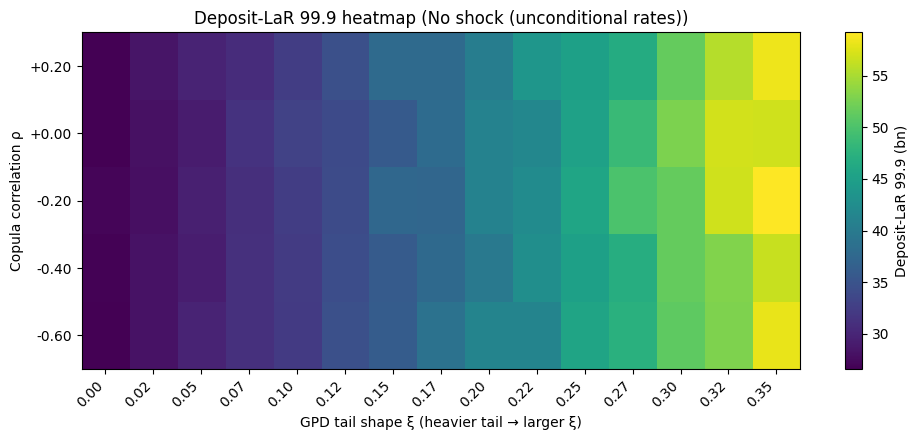

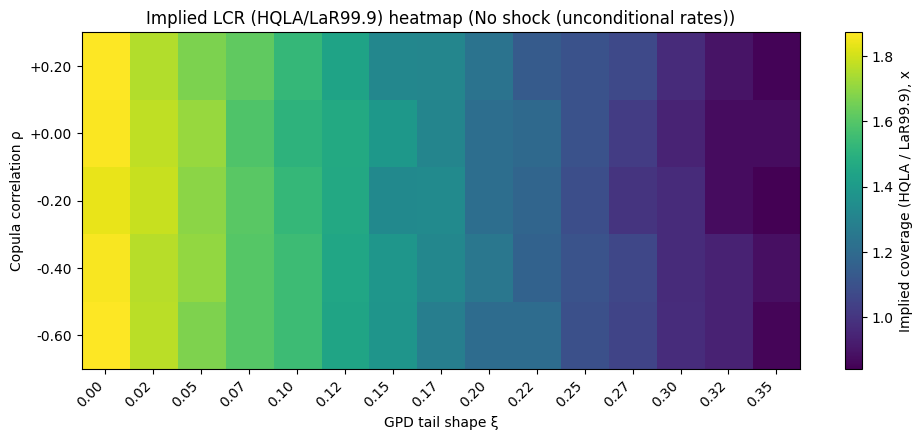


--- Regime: +300 bps shock (conditional) ---


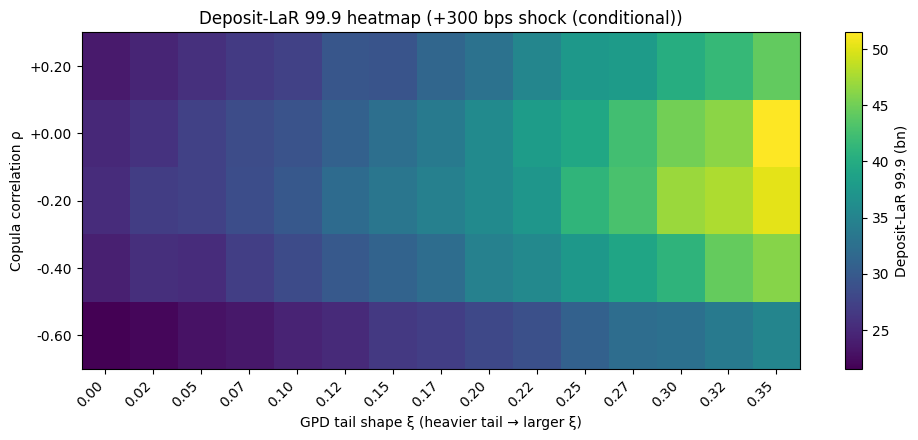

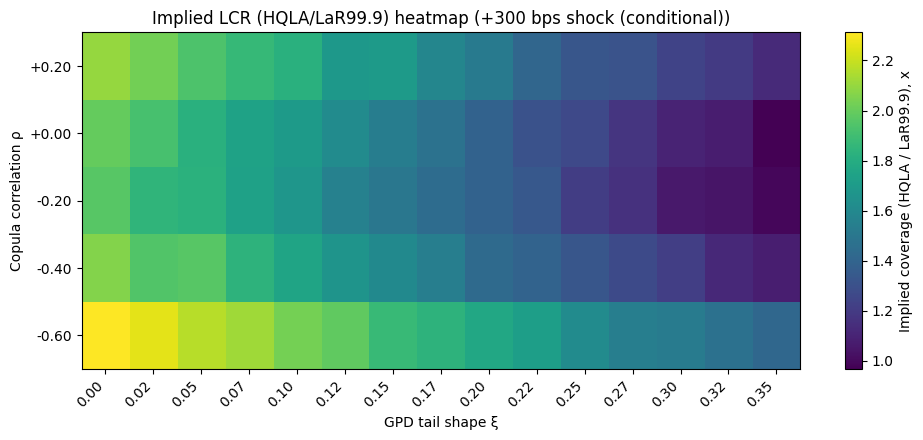


--- Regime: -300 bps shock (conditional) ---


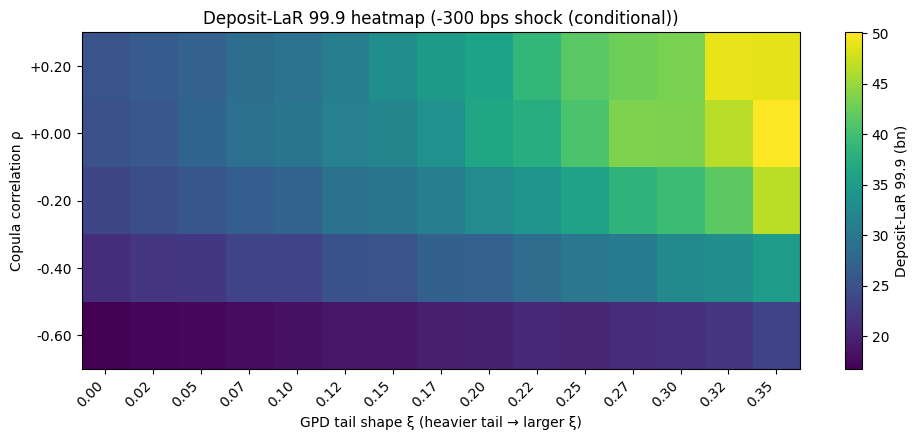

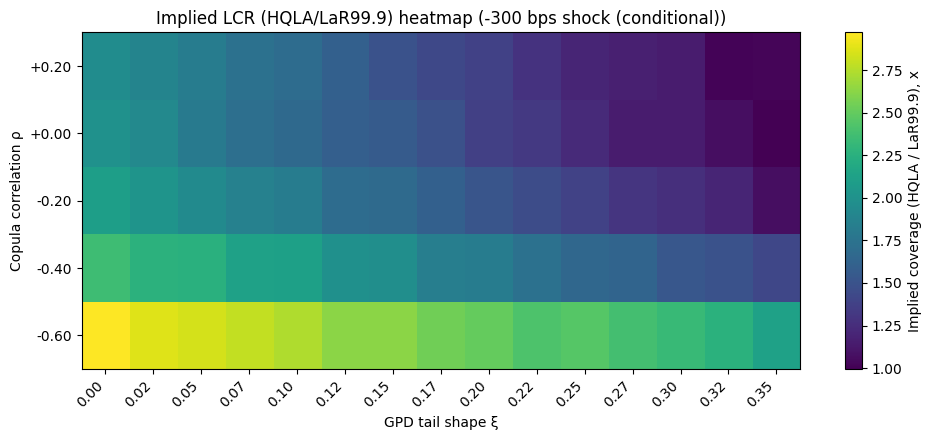

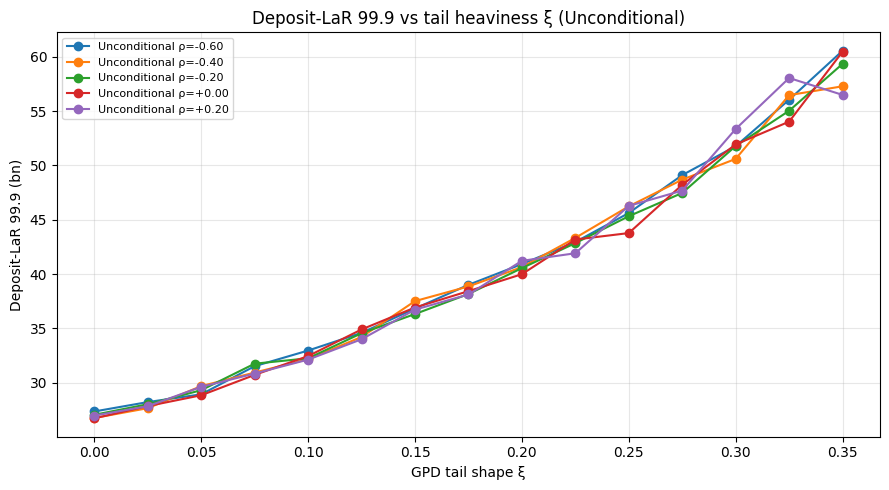

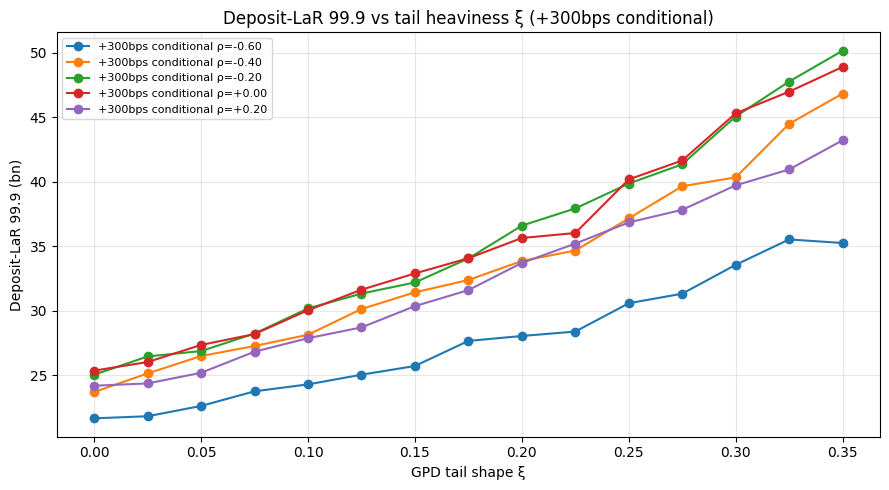

In [65]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# USER KNOBS
# =========================================================
num_sim = 300_000          # start smaller; 1_000_000 is slow
nu = 10
T_horizon = 0.25           # quarter if flow_total is quarterly pct_change
alpha_99  = 0.99
alpha_999 = 0.999

# Heatmap grids
xi_grid  = np.linspace(0.00, 0.35, 15)                 # GPD shape (tail heaviness)
rho_grid = np.array([-0.60, -0.40, -0.20, 0.00, 0.20])  # dependence sensitivity

# Regimes
shock_regimes_bps = {
    "No shock (unconditional rates)": None,
    "+300 bps shock (conditional)":  300,
    "-300 bps shock (conditional)": -300,
}

eps = 1e-8
rng = np.random.default_rng(42)

# =========================================================
# 1) DATA FOR COPULA FIT
# =========================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()
x_hist = df["flow_total"].to_numpy()
y_hist = df["fedfunds_change"].to_numpy()
n = len(df)
print("n obs:", n)

# Rank uniforms for historical dependence estimate (optional diagnostic)
u_x = (stats.rankdata(x_hist, method="average") - 0.5) / n
u_y = (stats.rankdata(y_hist, method="average") - 0.5) / n
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)
rho_t_hat = np.corrcoef(t_x, t_y)[0, 1]
print("rho_t_hat (from data):", rho_t_hat)

# =========================================================
# 2) VASICEK MARGINAL FOR r_T over T_horizon
# =========================================================
def vasicek_marginal_params(r0, a, b, sigma, T):
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return m_T, np.sqrt(v_T)

m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

# =========================================================
# 3) BALANCE SHEET SNAPSHOT + HQLA (billions)
# =========================================================
latest = panel.sort_values("report_date").iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands

HQLA_th = (
    float(latest["cash_and_balances"])
    + float(latest["interest_bearing_balances"])
    + float(latest["securities_afs_total"])
)
HQLA_bn = HQLA_th / 1e6
D0_bn = D0_th / 1e6
print(f"D0 (domestic deposits): {D0_bn:.1f} bn, HQLA: {HQLA_bn:.1f} bn")

# =========================================================
# 4) COPULA SAMPLERS
# =========================================================
def sample_bivariate_t(size, rho, nu, rng):
    """(Tx,Ty) ~ t_nu(0, [[1,rho],[rho,1]])"""
    Sigma = np.array([[1.0, rho],
                      [rho, 1.0]])
    L = np.linalg.cholesky(Sigma)
    z = rng.standard_normal((size, 2)) @ L.T
    w = rng.chisquare(nu, size=size)
    return z / np.sqrt(w / nu)[:, None]

def sample_t_conditional_x_given_y(ty, rho, nu, size, rng):
    """
    (Tx,Ty) ~ t_nu(0, [[1,rho],[rho,1]])
    => Tx | Ty=ty is t_{nu+1} with:
       mean = rho*ty
       scale^2 = ((nu + ty^2)/(nu+1)) * (1 - rho^2)
    """
    df_cond = nu + 1
    mu_cond = rho * ty
    scale2 = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale = np.sqrt(scale2)
    return mu_cond + scale * stats.t.rvs(df=df_cond, size=size, random_state=rng)

# =========================================================
# 5) SEMI-PARAMETRIC FLOW MARGINAL: empirical center + GPD LEFT tail
# =========================================================
def fit_left_tail_gpd(x, tail_q=0.10):
    u = np.quantile(x, tail_q)
    tail = x[x < u]
    p_tail = len(tail) / len(x)
    L = (u - tail)  # exceedances > 0
    xi_hat, loc_hat, beta_hat = stats.genpareto.fit(L, floc=0)
    return float(u), float(p_tail), float(xi_hat), float(beta_hat)

u_thresh, p_tail, xi_hat, beta_hat = fit_left_tail_gpd(x_hist, tail_q=0.10)
print(f"GPD left-tail fit: u={u_thresh:.5f}, p_tail={p_tail:.3f}, xi_hat={xi_hat:.3f}, beta_hat={beta_hat:.5f}")

def semi_parametric_quantile_lefttail(u, x_center_sample, u_thresh, p_tail, xi, beta):
    u = np.asarray(u)
    out = np.empty_like(u, dtype=float)

    mask_center = (u > p_tail)
    out[mask_center] = np.quantile(x_center_sample, u[mask_center])

    mask_tail = ~mask_center
    v = np.clip(u[mask_tail] / max(p_tail, eps), eps, 1 - eps)
    qL = stats.genpareto.ppf(1.0 - v, c=xi, loc=0.0, scale=beta)  # >=0
    out[mask_tail] = u_thresh - qL
    return out

# =========================================================
# 6) CORE EVALUATION FUNCTION FOR A REGIME
# =========================================================
def evaluate_regime(shock_bps, xi, rho, num_sim, rng):
    """
    Returns (LaR99, LaR999, impliedLCR99, impliedLCR999) for one (xi,rho) under:
      - shock_bps=None: unconditional (simulate Ty then Tx with copula)
      - shock_bps=... : conditional on fixed r_T = r0 + shock
    """
    if shock_bps is None:
        # Unconditional joint simulation from t-copula
        t_sim = sample_bivariate_t(num_sim, rho=rho, nu=nu, rng=rng)
        u_sim = stats.t.cdf(t_sim, df=nu)
        u_x_sim = np.clip(u_sim[:, 0], eps, 1 - eps)
        u_y_sim = np.clip(u_sim[:, 1], eps, 1 - eps)

        # Flows via semi-parametric marginal
        flow_sim = semi_parametric_quantile_lefttail(
            u_x_sim, x_hist, u_thresh=u_thresh, p_tail=p_tail, xi=xi, beta=beta_hat
        )

        # Rates via Vasicek marginal (levels), then convert to change
        rT_sim = stats.norm.ppf(u_y_sim, loc=m_T, scale=std_T)
        rate_change_sim = rT_sim - r0  # not used in LaR directly here, but kept conceptually

    else:
        # Conditional on fixed shock: force r_T = r0 + shock
        shock = shock_bps / 10_000.0
        rT_star = r0 + shock

        # Map fixed rT_star into u_y_star via Vasicek marginal, then to latent ty*
        u_y_star = stats.norm.cdf(rT_star, loc=m_T, scale=std_T)
        u_y_star = float(np.clip(u_y_star, eps, 1 - eps))
        t_y_star = float(stats.t.ppf(u_y_star, df=nu))

        # Sample Tx | Ty=t_y_star
        t_x_cond = sample_t_conditional_x_given_y(t_y_star, rho=rho, nu=nu, size=num_sim, rng=rng)
        u_x_cond = stats.t.cdf(t_x_cond, df=nu)
        u_x_cond = np.clip(u_x_cond, eps, 1 - eps)

        # Map to flows via semi-parametric marginal
        flow_sim = semi_parametric_quantile_lefttail(
            u_x_cond, x_hist, u_thresh=u_thresh, p_tail=p_tail, xi=xi, beta=beta_hat
        )

    # Flows -> outflows (one quarter)
    D1_th = D0_th * (1.0 + flow_sim)
    outflow_th = np.maximum(D0_th - D1_th, 0.0)
    outflow_bn = outflow_th / 1e6

    lar99  = float(np.quantile(outflow_bn, alpha_99))
    lar999 = float(np.quantile(outflow_bn, alpha_999))

    lcr99  = HQLA_bn / lar99  if lar99  > 0 else np.inf
    lcr999 = HQLA_bn / lar999 if lar999 > 0 else np.inf
    return lar99, lar999, lcr99, lcr999

# =========================================================
# 7) HEATMAPS FOR EACH REGIME
# =========================================================
def compute_heatmaps_for_regime(shock_bps, title_suffix):
    LaR999 = np.zeros((len(rho_grid), len(xi_grid)))
    LCR999 = np.zeros((len(rho_grid), len(xi_grid)))

    for i_r, rho in enumerate(rho_grid):
        for j_xi, xi in enumerate(xi_grid):
            _, lar999, _, lcr999 = evaluate_regime(
                shock_bps=shock_bps, xi=xi, rho=rho, num_sim=num_sim, rng=rng
            )
            LaR999[i_r, j_xi] = lar999
            LCR999[i_r, j_xi] = lcr999

    # --- Plot LaR heatmap ---
    plt.figure(figsize=(10, 4.5))
    im = plt.imshow(LaR999, aspect="auto", origin="lower")
    plt.colorbar(im, label="Deposit-LaR 99.9 (bn)")
    plt.xticks(np.arange(len(xi_grid)), [f"{v:.2f}" for v in xi_grid], rotation=45, ha="right")
    plt.yticks(np.arange(len(rho_grid)), [f"{v:+.2f}" for v in rho_grid])
    plt.xlabel("GPD tail shape ξ (heavier tail → larger ξ)")
    plt.ylabel("Copula correlation ρ")
    plt.title(f"Deposit-LaR 99.9 heatmap {title_suffix}")
    plt.tight_layout()
    plt.show()

    # --- Plot LCR heatmap ---
    plt.figure(figsize=(10, 4.5))
    im = plt.imshow(LCR999, aspect="auto", origin="lower")
    plt.colorbar(im, label="Implied coverage (HQLA / LaR99.9), x")
    plt.xticks(np.arange(len(xi_grid)), [f"{v:.2f}" for v in xi_grid], rotation=45, ha="right")
    plt.yticks(np.arange(len(rho_grid)), [f"{v:+.2f}" for v in rho_grid])
    plt.xlabel("GPD tail shape ξ")
    plt.ylabel("Copula correlation ρ")
    plt.title(f"Implied LCR (HQLA/LaR99.9) heatmap {title_suffix}")
    plt.tight_layout()
    plt.show()

    return LaR999, LCR999

heatmap_results = {}
for regime_name, shock_bps in shock_regimes_bps.items():
    print("\n--- Regime:", regime_name, "---")
    heatmap_results[regime_name] = compute_heatmaps_for_regime(shock_bps, f"({regime_name})")

# =========================================================
# 8) UNCONDITIONAL COMPARISON PLOT (LINES)
#     Show LaR99.9 vs ξ for each ρ, under:
#       - unconditional regime (no shock)
#       - conditional +300 bps (optional)
# =========================================================
def lineplot_LaR999_vs_xi(shock_bps, label_prefix):
    plt.figure(figsize=(9, 5))
    for rho in rho_grid:
        vals = []
        for xi in xi_grid:
            _, lar999, _, _ = evaluate_regime(
                shock_bps=shock_bps, xi=xi, rho=rho, num_sim=num_sim, rng=rng
            )
            vals.append(lar999)
        plt.plot(xi_grid, vals, marker="o", label=f"{label_prefix} ρ={rho:+.2f}")
    plt.xlabel("GPD tail shape ξ")
    plt.ylabel("Deposit-LaR 99.9 (bn)")
    plt.title(f"Deposit-LaR 99.9 vs tail heaviness ξ ({label_prefix})")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# Unconditional (no shock)
lineplot_LaR999_vs_xi(shock_bps=None, label_prefix="Unconditional")

# Conditional +300 bps (optional comparison)
lineplot_LaR999_vs_xi(shock_bps=300, label_prefix="+300bps conditional")

Beta-Hurdle Model

P(outflow_total > 0) = 0.306
Beta parameters on positive outflows:
  alpha = 1.683, beta = 103.027


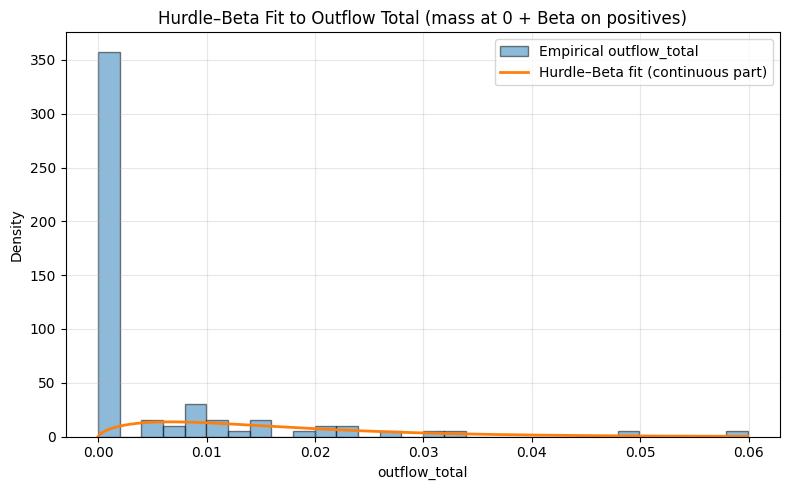

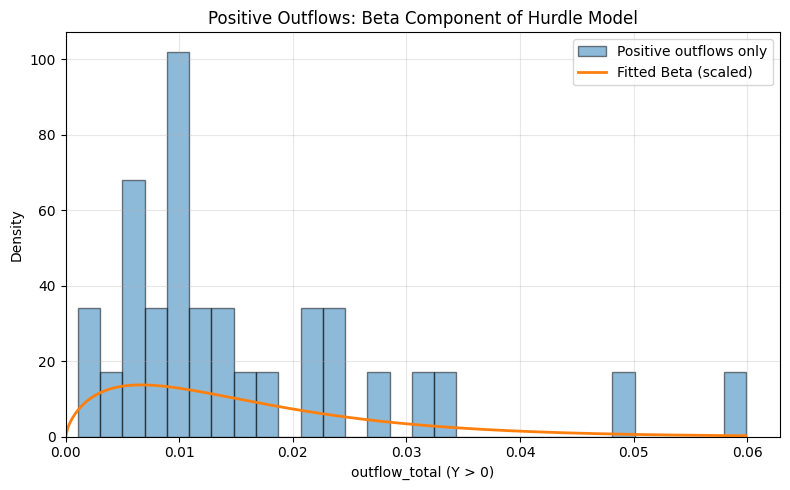

In [36]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. Prepare data: use outflow_total (>= 0 by construction)
# ----------------------------------------------------
y = panel["outflow_total"].astype(float).replace([np.inf, -np.inf], np.nan)
y = y.dropna()

# Indicator for positive outflow
is_pos = y > 0
p_pos = is_pos.mean()        # hurdle probability: P(Y > 0)
print(f"P(outflow_total > 0) = {p_pos:.3f}")

y_pos = y[is_pos]

# ----------------------------------------------------
# 2. Put positive outflows on (0, 1) and fit Beta
# ----------------------------------------------------
eps = 1e-6

# If any outflow >= 1, rescale by the max; otherwise leave as-is
y_max = y_pos.max()
if y_max >= 1.0:
    scale_y = y_max + eps
    y_unit = np.clip(y_pos / scale_y, eps, 1 - eps)
    print(f"Rescaling positive outflows by factor {scale_y:.4f} to fit Beta on (0,1).")
else:
    scale_y = 1.0
    y_unit = np.clip(y_pos, eps, 1 - eps)

# Fit Beta(alpha, beta) on y_unit in (0,1)
alpha_hat, beta_hat, loc_hat, scale_hat = stats.beta.fit(
    y_unit,
    floc=0,   # force support [0,1]
    fscale=1
)

print(f"Beta parameters on positive outflows:")
print(f"  alpha = {alpha_hat:.3f}, beta = {beta_hat:.3f}")

# ----------------------------------------------------
# 3. Helper: hurdle-Beta pdf for plotting (continuous part)
# ----------------------------------------------------
def hurdle_beta_pdf(x_grid):
    """
    Mixture density for Y>0 (ignores the point mass at 0 for plotting).
    If we rescaled by 'scale_y', transform x -> x/scale_y before applying Beta pdf.
    """
    x = np.asarray(x_grid)
    pdf = np.zeros_like(x, dtype=float)
    mask = x > 0
    x_pos = x[mask] / scale_y
    # beta pdf on (0,1), then change-of-variable for scaling
    pdf[mask] = p_pos * (1.0 / scale_y) * stats.beta.pdf(x_pos, alpha_hat, beta_hat)
    return pdf

# ----------------------------------------------------
# 4. Diagnostics: histogram of all outflows + mixture pdf
# ----------------------------------------------------
x_grid = np.linspace(0, y.max(), 300)

plt.figure(figsize=(8, 5))
plt.hist(y, bins=30, density=True, alpha=0.5, edgecolor="black", label="Empirical outflow_total")
plt.plot(x_grid, hurdle_beta_pdf(x_grid), linewidth=2, label="Hurdle–Beta fit (continuous part)")
plt.xlabel("outflow_total")
plt.ylabel("Density")
plt.title("Hurdle–Beta Fit to Outflow Total (mass at 0 + Beta on positives)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 5. Diagnostics: zoom on positive outflows only
# ----------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(y_pos, bins=30, density=True, alpha=0.5, edgecolor="black", label="Positive outflows only")
plt.plot(x_grid, hurdle_beta_pdf(x_grid), linewidth=2, label="Fitted Beta (scaled)")
plt.xlim(0, y_pos.max() * 1.05)
plt.xlabel("outflow_total (Y > 0)")
plt.ylabel("Density")
plt.title("Positive Outflows: Beta Component of Hurdle Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Observations used: 97
Share of zero outflows (p0): 0.701
Outflow cap used for scaling (approx upper tail): 0.0568
Fitted Beta parameters for positive outflows: a=0.581, b=0.861


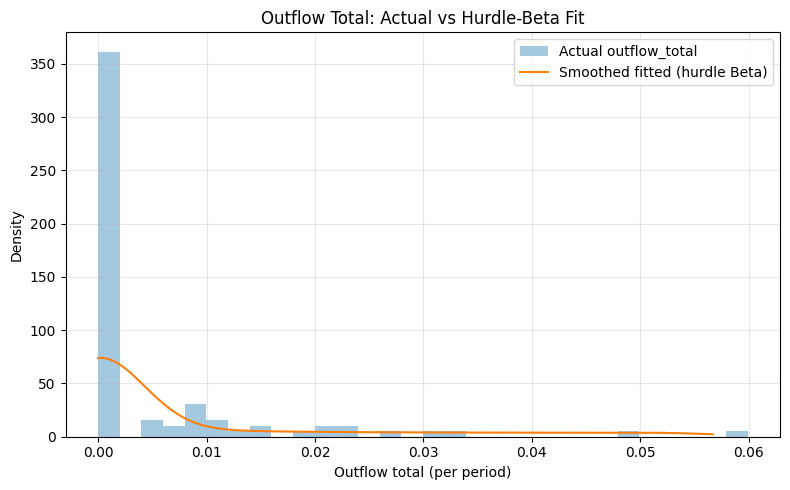

Vasicek horizon T=0.25 yrs:
  Mean rate change μ_Δr = 0.0697%
  Std of rate change σ_Δr = 6.1992%


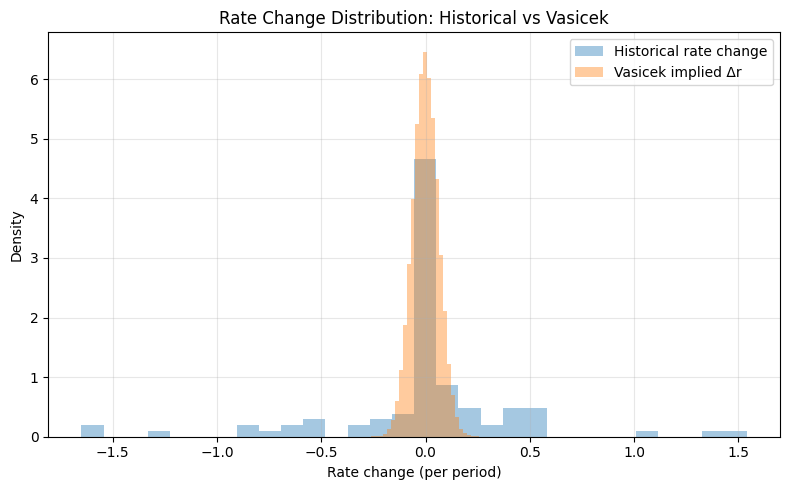

t-copula: nu=5, rho=0.014


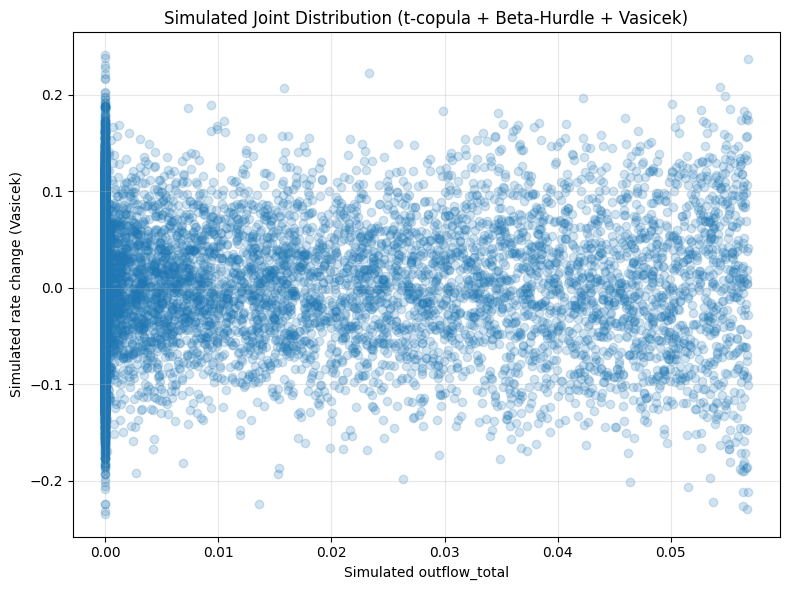

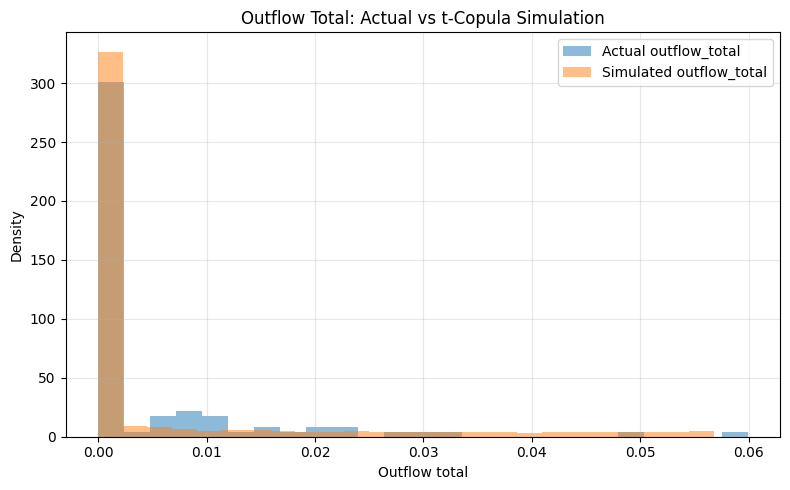

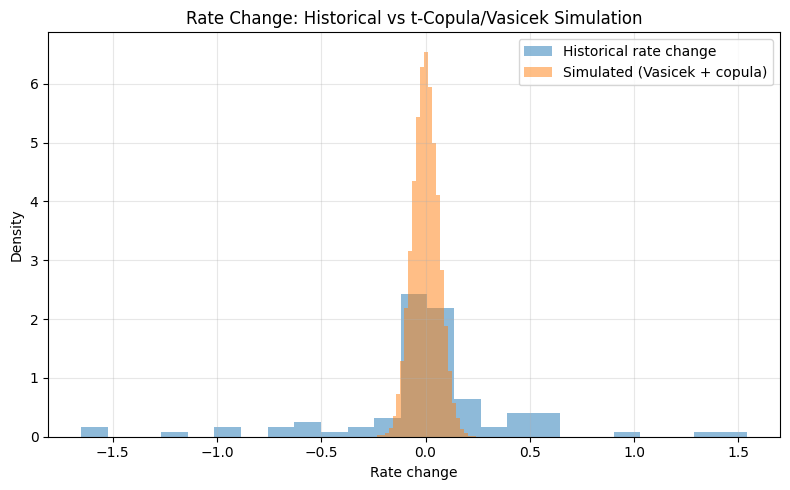

In [19]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import beta, t, norm
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 0. Prepare data: outflows + historical rate changes
# ----------------------------------------------------
# Use total outflows and historical rate changes (same horizon as panel)
df = panel[["outflow_total", "fedfunds_change"]].dropna().copy()

x = df["outflow_total"].values      # deposit outflow rate (>= 0, per quarter)
y = df["fedfunds_change"].values    # rate change (per quarter)

n = len(df)
print(f"Observations used: {n}")

# ----------------------------------------------------
# 1. Beta–hurdle marginal for outflows (x)
# ----------------------------------------------------
# Point mass at 0 + Beta on (0, cap] (scaled to [0,1])

eps = 1e-6

# Probability mass at zero
p0 = np.mean(x == 0)
print(f"Share of zero outflows (p0): {p0:.3f}")

# Positive outflows
x_pos = x[x > 0]
if len(x_pos) < 10:
    raise ValueError("Too few positive outflows to fit the beta component reliably.")

# Choose a cap (e.g. 99th percentile or a fixed max like 10% = 0.10)
cap = np.quantile(x_pos, 0.99)
print(f"Outflow cap used for scaling (approx upper tail): {cap:.4f}")

# Scale positive outflows to (0,1)
z = np.clip(x_pos / cap, eps, 1 - eps)

# Fit Beta(a,b) on z
a_beta, b_beta, loc_beta, scale_beta = beta.fit(z, floc=0, fscale=1)
print(f"Fitted Beta parameters for positive outflows: a={a_beta:.3f}, b={b_beta:.3f}")

def beta_hurdle_ppf(u, p0, a_beta, b_beta, cap):
    """
    Hurdle Beta inverse CDF:
    - with prob p0: outflow = 0
    - else: Beta(a,b) on (0, cap]
    """
    u = np.asarray(u)
    out = np.zeros_like(u, dtype=float)

    mask = u > p0
    if np.any(mask):
        u_cond = (u[mask] - p0) / (1 - p0)         # conditional uniforms in (0,1)
        u_cond = np.clip(u_cond, eps, 1 - eps)
        out[mask] = cap * beta.ppf(u_cond, a_beta, b_beta)

    return out

# ---- Diagnostics: actual vs fitted Beta–hurdle for outflows ----
u_grid = np.linspace(0.001, 0.999, 500)
outflow_fit = beta_hurdle_ppf(u_grid, p0, a_beta, b_beta, cap)

plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, density=True, alpha=0.4, label="Actual outflow_total")
plt.plot(
    np.sort(outflow_fit),
    stats.gaussian_kde(outflow_fit)(np.sort(outflow_fit)),
    label="Smoothed fitted (hurdle Beta)",
)
plt.title("Outflow Total: Actual vs Hurdle-Beta Fit")
plt.xlabel("Outflow total (per period)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 2. Vasicek marginal for rate **change** at horizon T
# ----------------------------------------------------
# Assumes you already estimated Vasicek on some short-rate series and have:
#   a, b, sigma, r0
# and choose horizon T_horizon (years) consistent with your LaR horizon.

T_horizon = 0.25   # for example, 1 quarter; adjust as needed

# Level of rate at horizon:
m_T = b + (r0 - b) * np.exp(-a * T_horizon)
v_T = sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T_horizon))
std_T = np.sqrt(v_T)

# We want the **change** at horizon: Δr_T = r_T - r0
mu_d = m_T - r0
sigma_d = std_T

print(f"Vasicek horizon T={T_horizon} yrs:")
print(f"  Mean rate change μ_Δr = {mu_d:.4%}")
print(f"  Std of rate change σ_Δr = {sigma_d:.4%}")

# ---- Diagnostics: implied Vasicek rate-change distribution ----
rate_change_samples = np.random.normal(loc=mu_d, scale=sigma_d, size=50_000)

plt.figure(figsize=(8, 5))
plt.hist(y, bins=30, density=True, alpha=0.4, label="Historical rate change")
plt.hist(rate_change_samples, bins=30, density=True, alpha=0.4, label="Vasicek implied Δr")
plt.title("Rate Change Distribution: Historical vs Vasicek")
plt.xlabel("Rate change (per period)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 3. Fit a t-copula on (outflow_total, rate change)
# ----------------------------------------------------
# Rank-transform to uniforms
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n

eps = 1e-6
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# Choose degrees of freedom (you can tune this; 4–10 is common for heavy tails)
nu = 5

# Map to t-distributed scores
z_x = stats.t.ppf(u_x, df=nu)
z_y = stats.t.ppf(u_y, df=nu)

rho = np.corrcoef(z_x, z_y)[0, 1]
Sigma = np.array([[1.0, rho],
                  [rho, 1.0]])

print(f"t-copula: nu={nu}, rho={rho:.3f}")

def sample_multivariate_t(mu, Sigma, df, size):
    """
    Draw samples from multivariate t with location mu, scale Sigma, df degrees.
    """
    dim = len(mu)
    g = np.random.standard_normal(size=(size, dim))
    L = np.linalg.cholesky(Sigma)
    z = g @ L.T
    w = np.random.chisquare(df, size=size)
    return mu + z / np.sqrt(w / df)[:, None]

# ----------------------------------------------------
# 4. Simulate from t-copula with parametric marginals
# ----------------------------------------------------
num_sim = 20_000

# (a) simulate latent t variables
t_sim = sample_multivariate_t(
    mu=np.zeros(2),
    Sigma=Sigma,
    df=nu,
    size=num_sim
)

# (b) transform to uniforms via t CDF
u_sim = stats.t.cdf(t_sim, df=nu)
u_x_sim = u_sim[:, 0]
u_y_sim = u_sim[:, 1]

# (c) map uniforms to OUTFLOW via Beta–hurdle
flow_sim = beta_hurdle_ppf(u_x_sim, p0, a_beta, b_beta, cap)

# (d) map uniforms to RATE CHANGE via Vasicek (Normal μ_Δr, σ_Δr)
u_y_sim = np.clip(u_y_sim, eps, 1 - eps)
rate_change_sim = norm.ppf(u_y_sim, loc=mu_d, scale=sigma_d)

# ----------------------------------------------------
# 5. Diagnostic plots for the joint parametric model
# ----------------------------------------------------
# Joint simulated cloud
plt.figure(figsize=(8, 6))
plt.scatter(flow_sim, rate_change_sim, alpha=0.2)
plt.xlabel("Simulated outflow_total")
plt.ylabel("Simulated rate change (Vasicek)")
plt.title("Simulated Joint Distribution (t-copula + Beta-Hurdle + Vasicek)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare marginals: outflow (actual vs parametric sim)
plt.figure(figsize=(8, 5))
plt.hist(x,         bins=25, density=True, alpha=0.5, label="Actual outflow_total")
plt.hist(flow_sim,  bins=25, density=True, alpha=0.5, label="Simulated outflow_total")
plt.xlabel("Outflow total")
plt.ylabel("Density")
plt.title("Outflow Total: Actual vs t-Copula Simulation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare marginals: rate change (historical vs Vasicek + copula)
plt.figure(figsize=(8, 5))
plt.hist(y,                bins=25, density=True, alpha=0.5, label="Historical rate change")
plt.hist(rate_change_sim,  bins=25, density=True, alpha=0.5, label="Simulated (Vasicek + copula)")
plt.xlabel("Rate change")
plt.ylabel("Density")
plt.title("Rate Change: Historical vs t-Copula/Vasicek Simulation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Variable Cap Paramteric Deposit Model

P(outflow_total > 0) = 0.306
Max observed outflow = 0.0599
Using design cap (support upper bound) = 0.1797
Beta parameters on positive outflows:
  alpha = 1.550, beta = 15.677


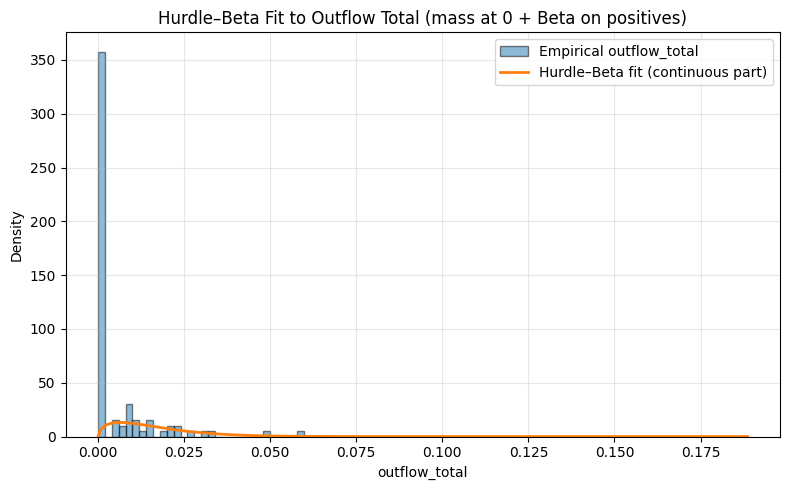

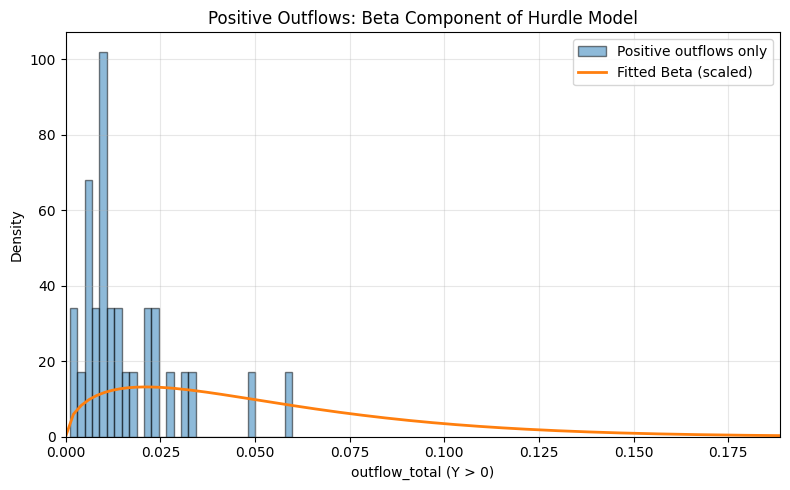

In [40]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. Prepare data: use outflow_total (>= 0 by construction)
# ----------------------------------------------------
y = panel["outflow_total"].astype(float).replace([np.inf, -np.inf], np.nan)
y = y.dropna()

# Indicator for positive outflow
is_pos = y > 0
p_pos = is_pos.mean()        # hurdle probability: P(Y > 0)
print(f"P(outflow_total > 0) = {p_pos:.3f}")

y_pos = y[is_pos]

# ----------------------------------------------------
# 2. Put positive outflows on (0, 1) and fit Beta
#    (with a relaxed cap above historical max)
# ----------------------------------------------------
eps = 1e-6

y_max = y_pos.max()

# Choose a design cap above history, e.g. 1.5× historical max (tunable)
cap_multiplier = 3.0
design_cap = cap_multiplier * y_max

scale_y = design_cap
y_unit = np.clip(y_pos / scale_y, eps, 1 - eps)

print(f"Max observed outflow = {y_max:.4f}")
print(f"Using design cap (support upper bound) = {design_cap:.4f}")

# Fit Beta(alpha, beta) on y_unit in (0,1)
alpha_hat, beta_hat, loc_hat, scale_hat = stats.beta.fit(
    y_unit,
    floc=0,   # force support [0,1]
    fscale=1
)

print(f"Beta parameters on positive outflows:")
print(f"  alpha = {alpha_hat:.3f}, beta = {beta_hat:.3f}")

# ----------------------------------------------------
# 3. Helper: hurdle-Beta pdf for plotting (continuous part)
# ----------------------------------------------------
def hurdle_beta_pdf(x_grid):
    """
    Mixture density for Y>0 (ignores the point mass at 0 for plotting).
    If we rescaled by 'scale_y', transform x -> x/scale_y before applying Beta pdf.
    """
    x = np.asarray(x_grid)
    pdf = np.zeros_like(x, dtype=float)
    mask = x > 0
    x_pos = x[mask] / scale_y
    # beta pdf on (0,1), then change-of-variable for scaling
    pdf[mask] = p_pos * (1.0 / scale_y) * stats.beta.pdf(x_pos, alpha_hat, beta_hat)
    return pdf

# ----------------------------------------------------
# 4. Diagnostics: histogram of all outflows + mixture pdf
# ----------------------------------------------------
x_grid = np.linspace(0, design_cap * 1.05, 300)

plt.figure(figsize=(8, 5))
plt.hist(y, bins=30, density=True, alpha=0.5, edgecolor="black", label="Empirical outflow_total")
plt.plot(x_grid, hurdle_beta_pdf(x_grid), linewidth=2, label="Hurdle–Beta fit (continuous part)")
plt.xlabel("outflow_total")
plt.ylabel("Density")
plt.title("Hurdle–Beta Fit to Outflow Total (mass at 0 + Beta on positives)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 5. Diagnostics: zoom on positive outflows only
# ----------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(y_pos, bins=30, density=True, alpha=0.5, edgecolor="black", label="Positive outflows only")
plt.plot(x_grid * (1/p_pos), hurdle_beta_pdf(x_grid), linewidth=2, label="Fitted Beta (scaled)")
plt.xlim(0, design_cap * 1.05)
plt.xlabel("outflow_total (Y > 0)")
plt.ylabel("Density")
plt.title("Positive Outflows: Beta Component of Hurdle Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

n obs: 86
rho_hat: -0.28728727687067757
D0=161.5 bn, HQLA=49.8 bn
Left-tail GPD: u=-0.03645, p_tail=0.105, xi_hat=-0.319, beta_hat=0.02799


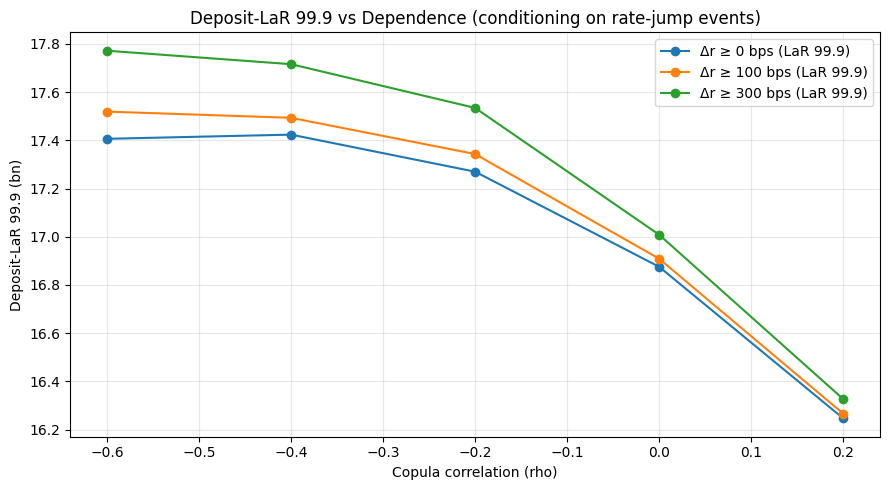

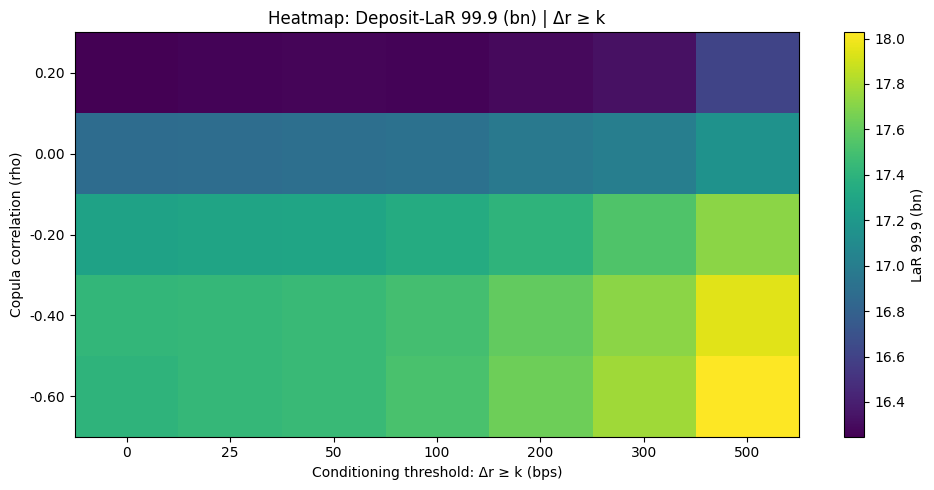

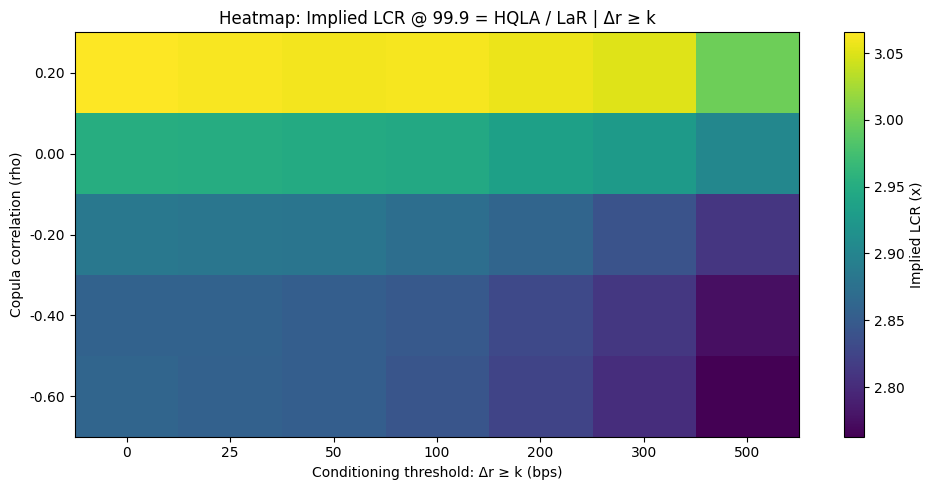

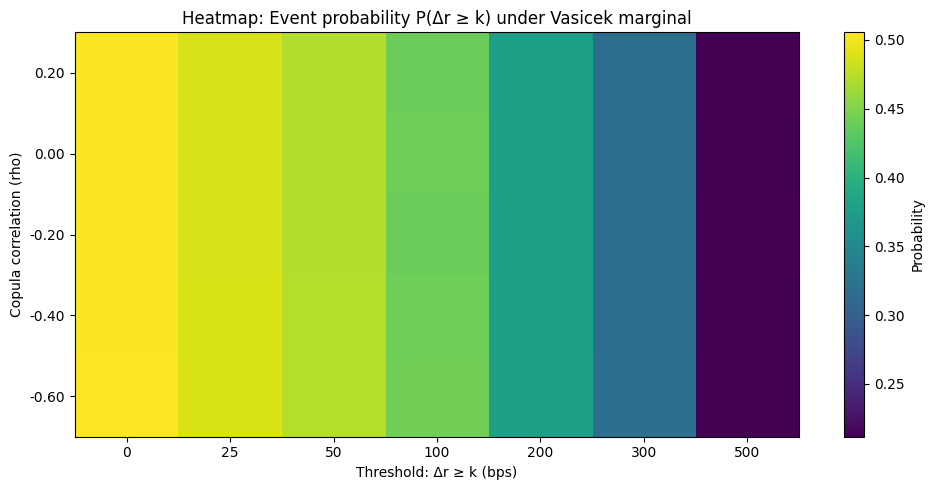

In [66]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# 0) USER KNOBS
# =========================================================
nu = 10
num_sim = 400_000          # start here; 1_000_000 is fine but slower
alpha_99  = 0.99
alpha_999 = 0.999
eps = 1e-8
rng = np.random.default_rng(42)

# Conditioning thresholds (bps) for "rate jump event": Δr >= k
cond_grid_bps = np.array([0, 25, 50, 100, 200, 300, 500])
rho_grid = np.array([-0.60, -0.40, -0.20, 0.00, 0.20])

# Horizon: keep consistent with your flow horizon
T_horizon = 0.25  # quarter

# =========================================================
# 1) DATA FOR COPULA FIT (historical) + BASE rho_hat
# =========================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()
x_hist = df["flow_total"].to_numpy()
y_hist = df["fedfunds_change"].to_numpy()
n = len(df)
print("n obs:", n)

u_x_hist = (stats.rankdata(x_hist, method="average") - 0.5) / n
u_y_hist = (stats.rankdata(y_hist, method="average") - 0.5) / n
u_x_hist = np.clip(u_x_hist, eps, 1 - eps)
u_y_hist = np.clip(u_y_hist, eps, 1 - eps)

t_x_hist = stats.t.ppf(u_x_hist, df=nu)
t_y_hist = stats.t.ppf(u_y_hist, df=nu)
rho_hat = float(np.corrcoef(t_x_hist, t_y_hist)[0, 1])
print("rho_hat:", rho_hat)

# =========================================================
# 2) VASICEK MARGINAL FOR RATE LEVEL r_T
#     You already have r0, a, b, sigma estimated elsewhere.
# =========================================================
def vasicek_marginal_params(r0, a, b, sigma, T):
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return m_T, np.sqrt(v_T)

m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

# =========================================================
# 3) BALANCE SHEET SNAPSHOT + HQLA (billions)
# =========================================================
latest = panel.sort_values("report_date").iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands

HQLA_th = (
    float(latest["cash_and_balances"])
    + float(latest["interest_bearing_balances"])
    + float(latest["securities_afs_total"])
)
HQLA_bn = HQLA_th / 1e6
D0_bn = D0_th / 1e6
print(f"D0={D0_bn:.1f} bn, HQLA={HQLA_bn:.1f} bn")

# =========================================================
# 4) SEMI-PARAMETRIC FLOW MARGINAL:
#    empirical center + GPD for LEFT tail (negative flows)
# =========================================================
def fit_left_tail_gpd(x, tail_q=0.10):
    u = np.quantile(x, tail_q)
    tail = x[x < u]
    p_tail = len(tail) / len(x)

    L = (u - tail)  # exceedances >0
    xi_hat, loc_hat, beta_hat = stats.genpareto.fit(L, floc=0)
    return float(u), float(p_tail), float(xi_hat), float(beta_hat)

u_thresh, p_tail, xi_hat, beta_hat = fit_left_tail_gpd(x_hist, tail_q=0.10)
print(f"Left-tail GPD: u={u_thresh:.5f}, p_tail={p_tail:.3f}, xi_hat={xi_hat:.3f}, beta_hat={beta_hat:.5f}")

def semi_parametric_quantile_lefttail(u, x_center_sample, u_thresh, p_tail, xi, beta):
    u = np.asarray(u)
    out = np.empty_like(u, dtype=float)

    mask_center = (u > p_tail)
    out[mask_center] = np.quantile(x_center_sample, u[mask_center])

    mask_tail = ~mask_center
    v = np.clip(u[mask_tail] / max(p_tail, eps), eps, 1 - eps)
    qL = stats.genpareto.ppf(1.0 - v, c=xi, loc=0.0, scale=beta)
    out[mask_tail] = u_thresh - qL
    return out

# =========================================================
# 5) SAMPLE FROM t-COPULA (UNCONDITIONAL), THEN FILTER ON EVENT Δr >= k
#    and compute LaR/LCR. This matches your "condition on tail event" idea.
# =========================================================
def sample_multivariate_t(mu, Sigma, df, size, rng):
    dim = len(mu)
    g = rng.standard_normal(size=(size, dim))
    L = np.linalg.cholesky(Sigma)
    z = g @ L.T
    w = rng.chisquare(df, size=size)
    return mu + z / np.sqrt(w / df)[:, None]

def flows_to_outflows_bn(flow_sim, D0_th):
    D1_th = D0_th * (1.0 + flow_sim)
    outflow_th = np.maximum(D0_th - D1_th, 0.0)
    return outflow_th / 1e6

# Storage: heatmaps over (rho, threshold)
LaR99_mat  = np.full((len(rho_grid), len(cond_grid_bps)), np.nan)
LaR999_mat = np.full((len(rho_grid), len(cond_grid_bps)), np.nan)
LCR99_mat  = np.full((len(rho_grid), len(cond_grid_bps)), np.nan)
LCR999_mat = np.full((len(rho_grid), len(cond_grid_bps)), np.nan)
p_event_mat = np.full((len(rho_grid), len(cond_grid_bps)), np.nan)

for i_r, rho in enumerate(rho_grid):
    Sigma = np.array([[1.0, rho],
                      [rho, 1.0]])

    # (A) draw latent t samples
    t_sim = sample_multivariate_t(mu=np.zeros(2), Sigma=Sigma, df=nu, size=num_sim, rng=rng)

    # (B) map latent to uniforms
    u_sim = stats.t.cdf(t_sim, df=nu)
    u_x = np.clip(u_sim[:, 0], eps, 1 - eps)
    u_y = np.clip(u_sim[:, 1], eps, 1 - eps)

    # (C) map u_y -> r_T via Vasicek marginal (normal), then Δr = r_T - r0
    rT = stats.norm.ppf(u_y, loc=m_T, scale=std_T)
    dr = rT - r0

    # (D) map u_x -> flow via semi-parametric marginal (choose xi_hat or override later)
    flow_all = semi_parametric_quantile_lefttail(
        u_x, x_hist,
        u_thresh=u_thresh, p_tail=p_tail,
        xi=xi_hat, beta=beta_hat
    )

    # unconditional baseline (k= -inf) is convenient to include separately if desired
    # We'll compute for each threshold using filtering.
    for j_k, k_bps in enumerate(cond_grid_bps):
        k = k_bps / 10_000.0
        mask = (dr >= k)
        p_event = mask.mean()
        p_event_mat[i_r, j_k] = p_event

        # Guard: if event is too rare, quantiles will be unstable
        if mask.sum() < 2_000:
            continue

        out_bn = flows_to_outflows_bn(flow_all[mask], D0_th)

        lar99  = float(np.quantile(out_bn, alpha_99))
        lar999 = float(np.quantile(out_bn, alpha_999))

        LaR99_mat[i_r, j_k]  = lar99
        LaR999_mat[i_r, j_k] = lar999
        LCR99_mat[i_r, j_k]  = HQLA_bn / lar99  if lar99  > 0 else np.inf
        LCR999_mat[i_r, j_k] = HQLA_bn / lar999 if lar999 > 0 else np.inf

# =========================================================
# 6) PLOTS
# =========================================================

# --- (1) Unconditional comparison plot: LaR vs rho at a few thresholds
plt.figure(figsize=(9, 5))
for k_bps in [0, 100, 300]:
    j = np.where(cond_grid_bps == k_bps)[0][0]
    plt.plot(rho_grid, LaR999_mat[:, j], marker="o", label=f"Δr ≥ {k_bps} bps (LaR 99.9)")
plt.xlabel("Copula correlation (rho)")
plt.ylabel("Deposit-LaR 99.9 (bn)")
plt.title("Deposit-LaR 99.9 vs Dependence (conditioning on rate-jump events)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- (2) Heatmap: LaR 99.9 across (rho, threshold)
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(LaR999_mat, aspect="auto", origin="lower")

ax.set_yticks(np.arange(len(rho_grid)))
ax.set_yticklabels([f"{r:.2f}" for r in rho_grid])
ax.set_xticks(np.arange(len(cond_grid_bps)))
ax.set_xticklabels([str(int(k)) for k in cond_grid_bps])

ax.set_xlabel("Conditioning threshold: Δr ≥ k (bps)")
ax.set_ylabel("Copula correlation (rho)")
ax.set_title("Heatmap: Deposit-LaR 99.9 (bn) | Δr ≥ k")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("LaR 99.9 (bn)")
plt.tight_layout()
plt.show()

# --- (3) Heatmap: implied LCR (99.9) across (rho, threshold)
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(LCR999_mat, aspect="auto", origin="lower")

ax.set_yticks(np.arange(len(rho_grid)))
ax.set_yticklabels([f"{r:.2f}" for r in rho_grid])
ax.set_xticks(np.arange(len(cond_grid_bps)))
ax.set_xticklabels([str(int(k)) for k in cond_grid_bps])

ax.set_xlabel("Conditioning threshold: Δr ≥ k (bps)")
ax.set_ylabel("Copula correlation (rho)")
ax.set_title("Heatmap: Implied LCR @ 99.9 = HQLA / LaR | Δr ≥ k")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Implied LCR (x)")
plt.tight_layout()
plt.show()

# --- (4) Event probability heatmap: P(Δr ≥ k)
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(p_event_mat, aspect="auto", origin="lower")

ax.set_yticks(np.arange(len(rho_grid)))
ax.set_yticklabels([f"{r:.2f}" for r in rho_grid])
ax.set_xticks(np.arange(len(cond_grid_bps)))
ax.set_xticklabels([str(int(k)) for k in cond_grid_bps])

ax.set_xlabel("Threshold: Δr ≥ k (bps)")
ax.set_ylabel("Copula correlation (rho)")
ax.set_title("Heatmap: Event probability P(Δr ≥ k) under Vasicek marginal")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Probability")
plt.tight_layout()
plt.show()

ρ = -0.60
ρ = -0.40
ρ = -0.20
ρ = 0.00
ρ = 0.20


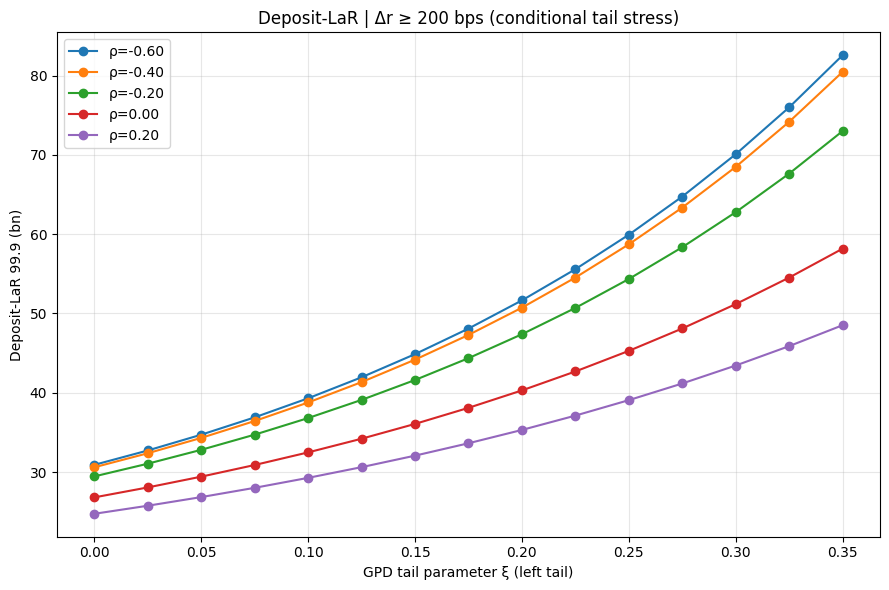

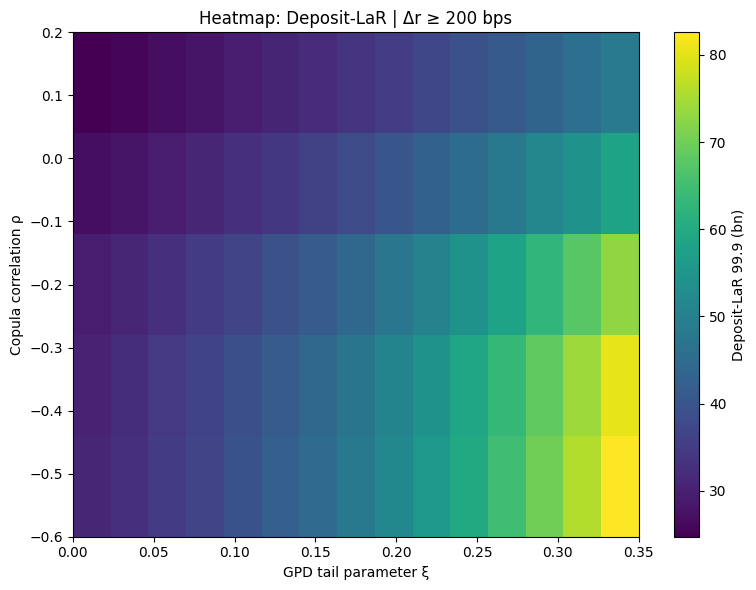

In [67]:
# =========================================================
# CONDITIONAL TAIL ANALYSIS:
#   LaR vs (xi, rho) given Δr ≥ k
# =========================================================

k_bps = 200
k = k_bps / 10_000.0   # decimal rate change threshold

num_sim_cond = 500_000
eps = 1e-8

# ---------------------------------------------------------
# Step 1: simulate joint (Tx, Ty) from t-copula
# ---------------------------------------------------------
def simulate_joint_t(n, rho, nu, rng):
    Sigma = np.array([[1.0, rho],
                      [rho, 1.0]])
    g = rng.standard_normal((n, 2))
    L = np.linalg.cholesky(Sigma)
    z = g @ L.T
    w = rng.chisquare(df=nu, size=n)
    t = z / np.sqrt(w / nu)[:, None]
    return t[:, 0], t[:, 1]   # Tx, Ty

# ---------------------------------------------------------
# Step 2: container for results
# ---------------------------------------------------------
LaR99_cond  = np.zeros((len(rho_grid), len(xi_grid)))
LaR999_cond = np.zeros((len(rho_grid), len(xi_grid)))

# ---------------------------------------------------------
# Step 3: loop over correlation and tail heaviness
# ---------------------------------------------------------
for i_r, rho in enumerate(rho_grid):

    print(f"ρ = {rho:.2f}")

    # simulate joint copula draws
    Tx, Ty = simulate_joint_t(num_sim_cond, rho, nu, rng)

    # map Ty → rate changes via Vasicek marginal
    u_y = stats.t.cdf(Ty, df=nu)
    u_y = np.clip(u_y, eps, 1 - eps)
    rT_sim = stats.norm.ppf(u_y, loc=m_T, scale=std_T)
    delta_r_sim = rT_sim - r0

    # -----------------------------------------------------
    # CONDITION: Δr ≥ k
    # -----------------------------------------------------
    mask = delta_r_sim >= k
    if mask.sum() < 5_000:
        print("  WARNING: too few tail observations")
        continue

    Tx_tail = Tx[mask]

    # map Tx → uniforms
    u_x = stats.t.cdf(Tx_tail, df=nu)
    u_x = np.clip(u_x, eps, 1 - eps)

    for j_xi, xi in enumerate(xi_grid):

        # semi-parametric flow marginal
        flow_sim = semi_parametric_quantile_lefttail(
            u_x,
            x_hist,
            u_thresh=u_thresh,
            p_tail=p_tail,
            xi=xi,
            beta=beta_hat
        )

        # flows → outflows
        D1_th = D0_th * (1.0 + flow_sim)
        outflow_bn = np.maximum(D0_th - D1_th, 0.0) / 1e6

        LaR99_cond[i_r, j_xi]  = np.quantile(outflow_bn, 0.99)
        LaR999_cond[i_r, j_xi] = np.quantile(outflow_bn, 0.999)

# =========================================================
# VISUALIZATION 1: LaR vs xi for each rho
# =========================================================
plt.figure(figsize=(9,6))
for i_r, rho in enumerate(rho_grid):
    plt.plot(xi_grid, LaR999_cond[i_r], marker="o", label=f"ρ={rho:.2f}")

plt.xlabel("GPD tail parameter ξ (left tail)")
plt.ylabel("Deposit-LaR 99.9 (bn)")
plt.title(f"Deposit-LaR | Δr ≥ {k_bps} bps (conditional tail stress)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# VISUALIZATION 2: Heatmap (ρ × ξ)
# =========================================================
plt.figure(figsize=(8,6))
plt.imshow(
    LaR999_cond,
    aspect="auto",
    origin="lower",
    extent=[xi_grid.min(), xi_grid.max(), rho_grid.min(), rho_grid.max()],
    cmap="viridis"
)
plt.colorbar(label="Deposit-LaR 99.9 (bn)")
plt.xlabel("GPD tail parameter ξ")
plt.ylabel("Copula correlation ρ")
plt.title(f"Heatmap: Deposit-LaR | Δr ≥ {k_bps} bps")
plt.tight_layout()
plt.show()

a     (speed)      = 0.0839
b     (mean level) = 7.0389%
sigma (volatility) = 12.5288%

Last observed rate r0 = 3.6800%

n obs: 86
rho_t_hat: -0.28728727687067757
D0 (domestic deposits): 161.5 bn, HQLA: 49.8 bn


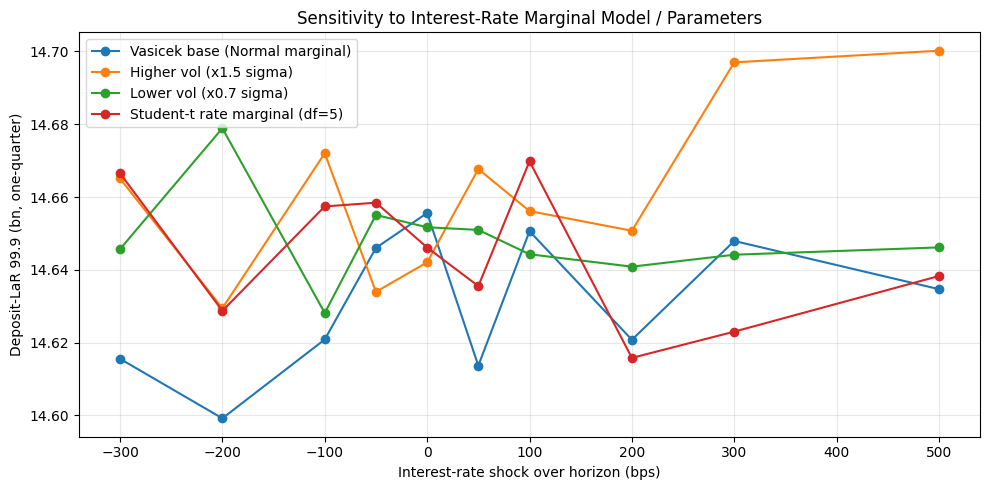

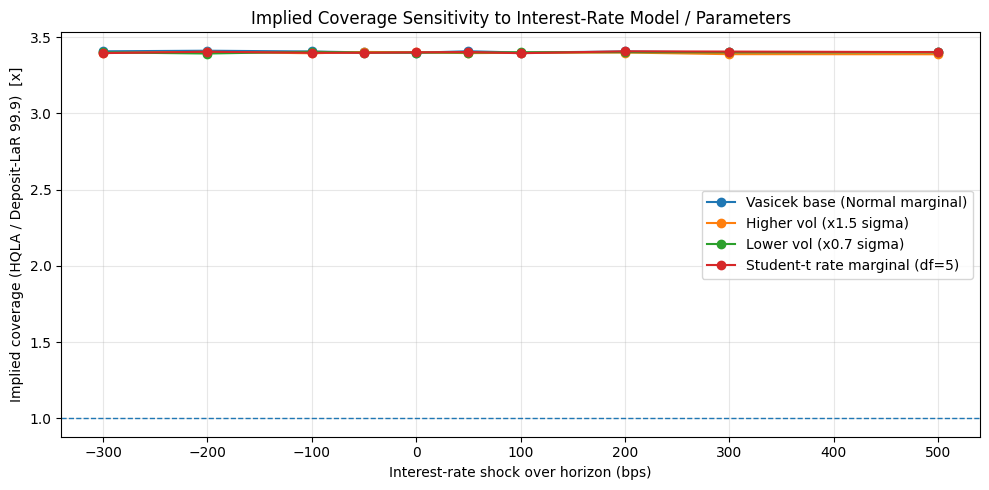

Synthetic rho_t_hat: 0.5


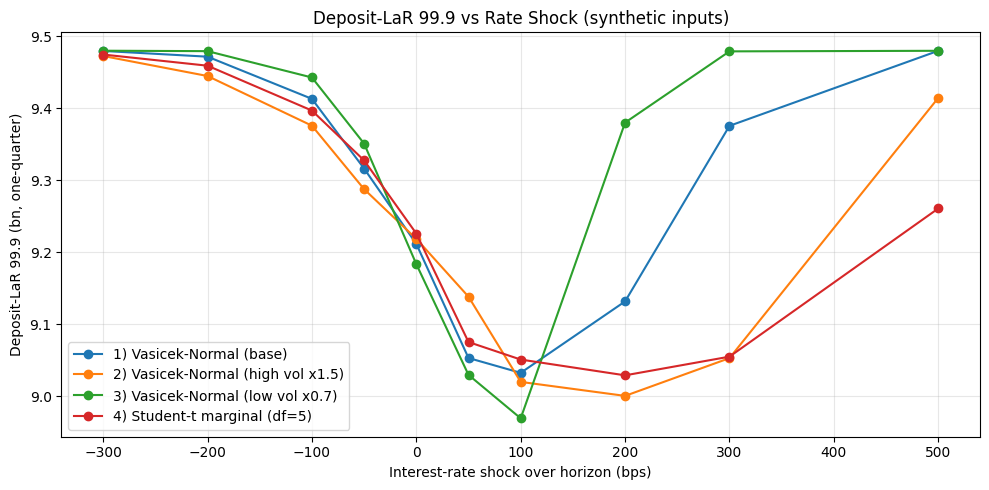

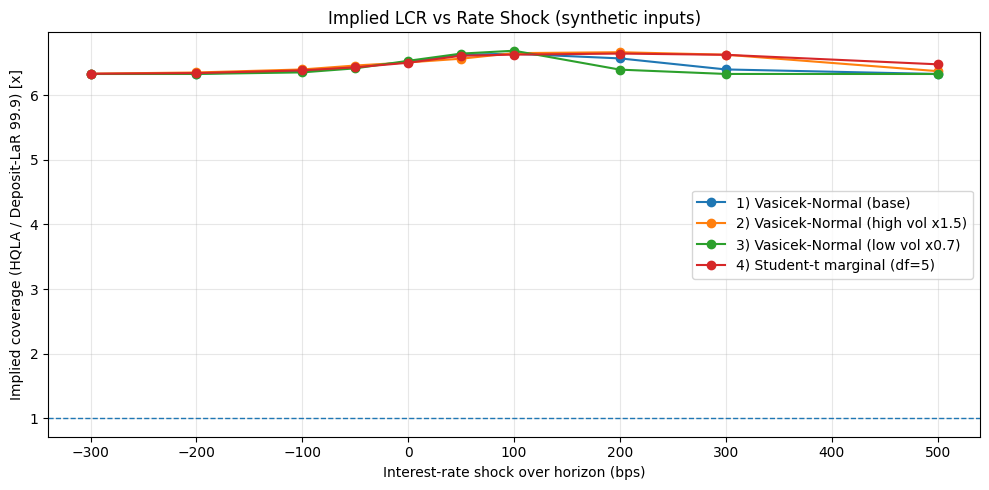

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# 0) USER KNOBS (all synthetic)
# =========================================================
num_sim = 200_000
nu = 10
T_horizon = 0.25  # quarter

shock_grid_bps = np.array([-300, -200, -100, -50, 0, 50, 100, 200, 300, 500])
alpha_99  = 0.99
alpha_999 = 0.999
eps = 1e-8
rng = np.random.default_rng(42)

# Synthetic balance sheet "model numbers"
D0_bn   = 300.0   # domestic deposits (bn)
HQLA_bn =  60.0   # HQLA (bn)
D0_th   = D0_bn * 1e6  # keep your convention: "thousands" internally

# =========================================================
# 1) Create synthetic "historical" samples to fit copula dependence
#    (replace this with your real x_hist/y_hist later)
# =========================================================
n_hist = 120  # ~30 years of quarters

# Synthetic quarterly deposit flows: centered ~0.3% with left-tail stress
# (heavy-tailed & slightly negatively skewed)
x_hist = 0.003 + 0.01 * stats.t.rvs(df=5, size=n_hist, random_state=rng)
x_hist = np.clip(x_hist, -0.20, 0.20)  # guardrails

# Synthetic quarterly rate changes: heavier tails than normal
y_hist = 0.00 + 0.005 * stats.t.rvs(df=6, size=n_hist, random_state=rng)
y_hist = np.clip(y_hist, -0.10, 0.10)  # ±1000 bps/quarter guardrail

# Fit t-copula correlation using ranks -> t-ppf latent
u_x = (stats.rankdata(x_hist, method="average") - 0.5) / n_hist
u_y = (stats.rankdata(y_hist, method="average") - 0.5) / n_hist
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)
rho_t_hat = float(np.corrcoef(t_x, t_y)[0, 1])
print("Synthetic rho_t_hat:", rho_t_hat)

# =========================================================
# 2) Conditional sampler: Tx | Ty=ty  for bivariate t-copula
# =========================================================
def sample_t_conditional_x_given_y(ty, rho, nu, size, rng):
    # (Tx,Ty) ~ t_nu(0, [[1,rho],[rho,1]])
    # => Tx|Ty=ty is t_{nu+1} with mean=rho*ty and scaled variance
    df_cond = nu + 1
    mu_cond = rho * ty
    scale2  = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale   = np.sqrt(scale2)
    return mu_cond + scale * stats.t.rvs(df=df_cond, size=size, random_state=rng)

# Deposit marginal: keep it simple here (empirical quantile from x_hist)
def deposit_quantile(u):
    return np.quantile(x_hist, u)

# =========================================================
# 3) RATE MARGINALS (swap these)
#    IMPORTANT: use DECIMALS. Example: 4% = 0.04
# =========================================================
def vasicek_marginal_params(r0, a, b, sigma, T):
    # r_T ~ Normal(m_T, std_T) under Vasicek
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return float(m_T), float(np.sqrt(v_T))

def u_y_from_rate_normal(rT_star, m_T, std_T):
    return float(np.clip(stats.norm.cdf(rT_star, loc=m_T, scale=std_T), eps, 1 - eps))

def u_y_from_rate_student_t(rT_star, m_T, std_T, df_rate=5):
    # Heavy-tailed rate marginal around m_T with scale std_T
    z = (rT_star - m_T) / max(std_T, 1e-12)
    return float(np.clip(stats.t.cdf(z, df=df_rate), eps, 1 - eps))

# =========================================================
# 4) Scenario engine: compute LaR/LCR curves vs shocks for a chosen rate marginal
# =========================================================
def run_shock_curve(rate_u_cdf_func, rate_params, rho_t=rho_t_hat):
    LaR_99_list, LaR_999_list = [], []
    LCR_99_list, LCR_999_list = [], []

    r0_local = rate_params["r0"]

    for shock_bps in shock_grid_bps:
        shock = shock_bps / 10_000.0  # bps -> decimal
        rT_star = r0_local + shock    # "forced" end-horizon level

        # map physical rate level -> copula uniform -> latent t
        u_y_star = rate_u_cdf_func(rT_star, **rate_params)
        t_y_star = float(stats.t.ppf(u_y_star, df=nu))

        # conditional latent deposit factor
        t_x_cond = sample_t_conditional_x_given_y(t_y_star, rho_t, nu, num_sim, rng)

        # back to uniform for X in copula space
        u_x_cond = stats.t.cdf(t_x_cond, df=nu)
        u_x_cond = np.clip(u_x_cond, eps, 1 - eps)

        # map to deposit flows (quarterly)
        flow_sim = deposit_quantile(u_x_cond)

        # flow -> outflow (one-quarter), in bn
        D1_th = D0_th * (1.0 + flow_sim)
        outflow_th = np.maximum(D0_th - D1_th, 0.0)
        outflow_bn = outflow_th / 1e6

        lar99  = float(np.quantile(outflow_bn, alpha_99))
        lar999 = float(np.quantile(outflow_bn, alpha_999))

        LaR_99_list.append(lar99)
        LaR_999_list.append(lar999)

        LCR_99_list.append(HQLA_bn / lar99  if lar99  > 0 else np.inf)
        LCR_999_list.append(HQLA_bn / lar999 if lar999 > 0 else np.inf)

    return (np.array(LaR_99_list), np.array(LaR_999_list),
            np.array(LCR_99_list), np.array(LCR_999_list))

# =========================================================
# 5) Define rate-model parameter sets (ALL IN DECIMALS)
# =========================================================
# Example "model numbers"
r0 = 0.040   # 4.0%
a  = 1.20    # mean reversion speed (per year)
b  = 0.035   # long-run mean 3.5%
sigma = 0.020  # 2.0% vol per sqrt(year)

m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

rate_models = {
    "1) Vasicek-Normal (base)": dict(r0=r0, m_T=m_T, std_T=std_T),
    "2) Vasicek-Normal (high vol x1.5)": dict(r0=r0, m_T=m_T, std_T=1.5*std_T),
    "3) Vasicek-Normal (low vol x0.7)": dict(r0=r0, m_T=m_T, std_T=0.7*std_T),
    "4) Student-t marginal (df=5)": dict(r0=r0, m_T=m_T, std_T=std_T, df_rate=5),
}

results = {}
for name, params in rate_models.items():
    if "df_rate" in params:
        lar99, lar999, lcr99, lcr999 = run_shock_curve(
            lambda rT_star, r0, m_T, std_T, df_rate: u_y_from_rate_student_t(rT_star, m_T, std_T, df_rate),
            params
        )
    else:
        lar99, lar999, lcr99, lcr999 = run_shock_curve(
            lambda rT_star, r0, m_T, std_T: u_y_from_rate_normal(rT_star, m_T, std_T),
            params
        )
    results[name] = dict(lar99=lar99, lar999=lar999, lcr99=lcr99, lcr999=lcr999)

# =========================================================
# 6) Visualizations
# =========================================================
plt.figure(figsize=(10,5))
for name, out in results.items():
    plt.plot(shock_grid_bps, out["lar999"], marker="o", label=name)
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Deposit-LaR 99.9 (bn, one-quarter)")
plt.title("Deposit-LaR 99.9 vs Rate Shock (synthetic inputs)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
for name, out in results.items():
    plt.plot(shock_grid_bps, out["lcr999"], marker="o", label=name)
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Implied coverage (HQLA / Deposit-LaR 99.9) [x]")
plt.title("Implied LCR vs Rate Shock (synthetic inputs)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Toy rho_hat (unused if overriding rho): -0.06397097646775525
Left-tail GPD fit: u=-0.0158, p_tail=0.100, xi=-0.212, beta=0.0052


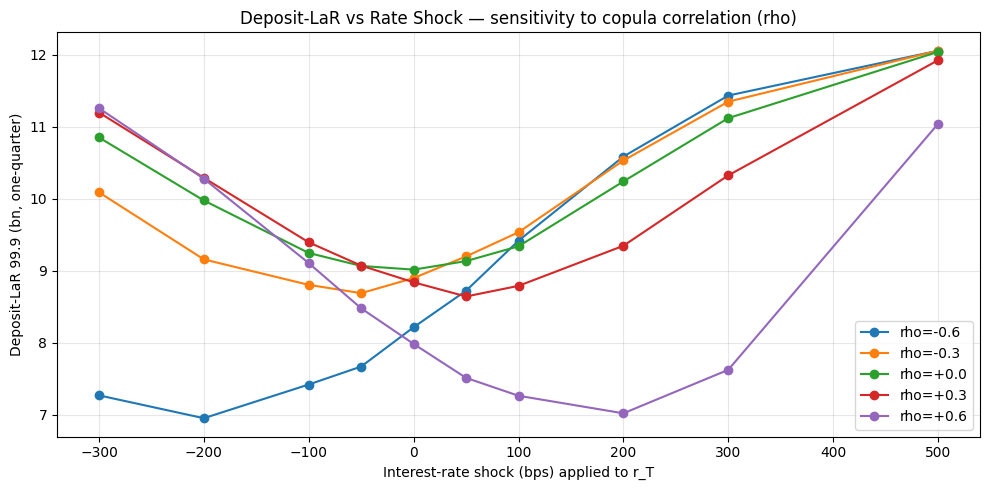

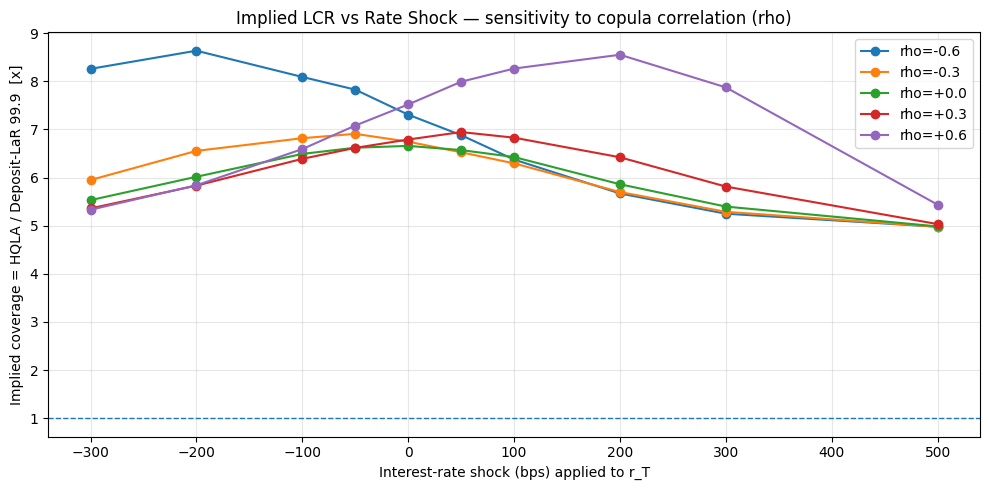

In [72]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# 0) USER KNOBS
# =========================================================
num_sim = 200_000
nu_copula = 10
T_horizon = 0.25                        # quarter horizon
shock_grid_bps = np.array([-300, -200, -100, -50, 0, 50, 100, 200, 300, 500])

alpha_99  = 0.99
alpha_999 = 0.999
eps = 1e-10
rng = np.random.default_rng(42)

# Vary dependence
rho_grid = np.array([-0.6, -0.3, 0.0, 0.3, 0.6])

# =========================================================
# 1) TOY "HISTORICAL" DATA (for fitting copula + flow marginal)
#    Replace these with your real x_hist, y_hist later.
# =========================================================
n_hist = 200
# Toy quarterly deposit flow: centered near 0 with left-tail downside risk
x_hist = rng.normal(loc=0.002, scale=0.015, size=n_hist)   # flows as ratios
# Toy quarterly rate change (decimal): mean 0, some volatility
y_hist = rng.normal(loc=0.0, scale=0.005, size=n_hist)     # Δr in decimals (50bp ~ 0.005)

# Fit copula dependence from toy data (optional); we’ll override rho anyway
u_x = (stats.rankdata(x_hist, method="average") - 0.5) / n_hist
u_y = (stats.rankdata(y_hist, method="average") - 0.5) / n_hist
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)
t_x = stats.t.ppf(u_x, df=nu_copula)
t_y = stats.t.ppf(u_y, df=nu_copula)
rho_hat = float(np.corrcoef(t_x, t_y)[0, 1])
print("Toy rho_hat (unused if overriding rho):", rho_hat)

# =========================================================
# 2) Semi-parametric flow marginal: empirical center + GPD LEFT tail
# =========================================================
def fit_left_tail_gpd(x, tail_q=0.10):
    u = np.quantile(x, tail_q)
    tail = x[x < u]
    p_tail = len(tail) / len(x)
    L = (u - tail)  # exceedances (positive)
    xi_hat, loc_hat, beta_hat = stats.genpareto.fit(L, floc=0)
    return float(u), float(p_tail), float(xi_hat), float(beta_hat)

u_thresh, p_tail, xi_hat, beta_hat = fit_left_tail_gpd(x_hist, tail_q=0.10)
print(f"Left-tail GPD fit: u={u_thresh:.4f}, p_tail={p_tail:.3f}, xi={xi_hat:.3f}, beta={beta_hat:.4f}")

def flow_quantile_semi_param(u, x_center, u_thresh, p_tail, xi, beta):
    """
    u -> flow:
      if u <= p_tail: draw from GPD left tail below threshold u_thresh
      else: empirical quantile
    """
    u = np.asarray(u)
    out = np.empty_like(u, dtype=float)

    mask_center = (u > p_tail)
    out[mask_center] = np.quantile(x_center, u[mask_center])

    mask_tail = ~mask_center
    v = np.clip(u[mask_tail] / max(p_tail, eps), eps, 1 - eps)
    qL = stats.genpareto.ppf(1.0 - v, c=xi, loc=0.0, scale=beta)  # >=0
    out[mask_tail] = u_thresh - qL
    return out

# Toggle: use semi-parametric or pure empirical
USE_SEMI_PARAMETRIC = True

def flow_quantile(u):
    if USE_SEMI_PARAMETRIC:
        return flow_quantile_semi_param(u, x_hist, u_thresh, p_tail, xi_hat, beta_hat)
    return np.quantile(x_hist, u)

# =========================================================
# 3) Rate marginal: Vasicek r_T distribution over horizon T
#    Everything in DECIMALS (e.g., 0.05 = 5%)
# =========================================================
def vasicek_marginal_params(r0, a, b, sigma, T):
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return float(m_T), float(np.sqrt(v_T))

# Toy Vasicek params (reasonable-ish, in decimal units)
r0 = 0.045           # 4.5%
a  = 1.2             # mean reversion
b  = 0.04            # long-run mean 4.0%
sigma = 0.02         # 2% per sqrt(year)
m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

def u_y_from_rT(rT):
    return float(np.clip(stats.norm.cdf(rT, loc=m_T, scale=std_T), eps, 1 - eps))

# =========================================================
# 4) Conditional sampler: Tx | Ty=ty for bivariate t-copula
# =========================================================
def sample_t_conditional_x_given_y(ty, rho, nu, size, rng):
    df_cond = nu + 1
    mu_cond = rho * ty
    scale2 = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale = np.sqrt(scale2)
    return mu_cond + scale * stats.t.rvs(df=df_cond, size=size, random_state=rng)

# =========================================================
# 5) Balance sheet toy numbers for LaR/LCR
# =========================================================
D0_bn = 300.0     # deposits in billions (toy)
HQLA_bn = 60.0    # HQLA in billions (toy)
D0 = D0_bn * 1e6  # convert bn -> thousands for consistency with your earlier code style

# =========================================================
# 6) Scenario engine: LaR/LCR vs shock for each rho
# =========================================================
def run_curve_for_rho(rho):
    lar99_list, lar999_list = [], []
    lcr99_list, lcr999_list = [], []

    for shock_bps in shock_grid_bps:
        shock = shock_bps / 10_000.0         # bps -> decimal
        rT_star = r0 + shock                 # force r_T to hit this level

        # map shock level -> copula latent Ty*
        u_y_star = u_y_from_rT(rT_star)
        t_y_star = float(stats.t.ppf(u_y_star, df=nu_copula))

        # sample conditional Tx|Ty*
        t_x_cond = sample_t_conditional_x_given_y(t_y_star, rho, nu_copula, num_sim, rng)

        # Tx -> Ux
        u_x_cond = stats.t.cdf(t_x_cond, df=nu_copula)
        u_x_cond = np.clip(u_x_cond, eps, 1 - eps)

        # Ux -> flow via marginal
        flow_sim = flow_quantile(u_x_cond)

        # flow -> outflow amount (one-quarter)
        D1 = D0 * (1.0 + flow_sim)
        outflow = np.maximum(D0 - D1, 0.0)         # thousands
        outflow_bn = outflow / 1e6                 # bn

        lar99  = float(np.quantile(outflow_bn, alpha_99))
        lar999 = float(np.quantile(outflow_bn, alpha_999))

        lar99_list.append(lar99)
        lar999_list.append(lar999)
        lcr99_list.append(HQLA_bn / lar99 if lar99 > 0 else np.inf)
        lcr999_list.append(HQLA_bn / lar999 if lar999 > 0 else np.inf)

    return (np.array(lar99_list), np.array(lar999_list),
            np.array(lcr99_list), np.array(lcr999_list))

results = {}
for rho in rho_grid:
    results[rho] = {}
    lar99, lar999, lcr99, lcr999 = run_curve_for_rho(rho)
    results[rho]["lar99"] = lar99
    results[rho]["lar999"] = lar999
    results[rho]["lcr99"] = lcr99
    results[rho]["lcr999"] = lcr999

# =========================================================
# 7) Plots
# =========================================================
plt.figure(figsize=(10,5))
for rho in rho_grid:
    plt.plot(shock_grid_bps, results[rho]["lar999"], marker="o", label=f"rho={rho:+.1f}")
plt.xlabel("Interest-rate shock (bps) applied to r_T")
plt.ylabel("Deposit-LaR 99.9 (bn, one-quarter)")
plt.title("Deposit-LaR vs Rate Shock — sensitivity to copula correlation (rho)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
for rho in rho_grid:
    plt.plot(shock_grid_bps, results[rho]["lcr999"], marker="o", label=f"rho={rho:+.1f}")
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel("Interest-rate shock (bps) applied to r_T")
plt.ylabel("Implied coverage = HQLA / Deposit-LaR 99.9  [x]")
plt.title("Implied LCR vs Rate Shock — sensitivity to copula correlation (rho)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Using fixed t-copula correlation rho = -0.3


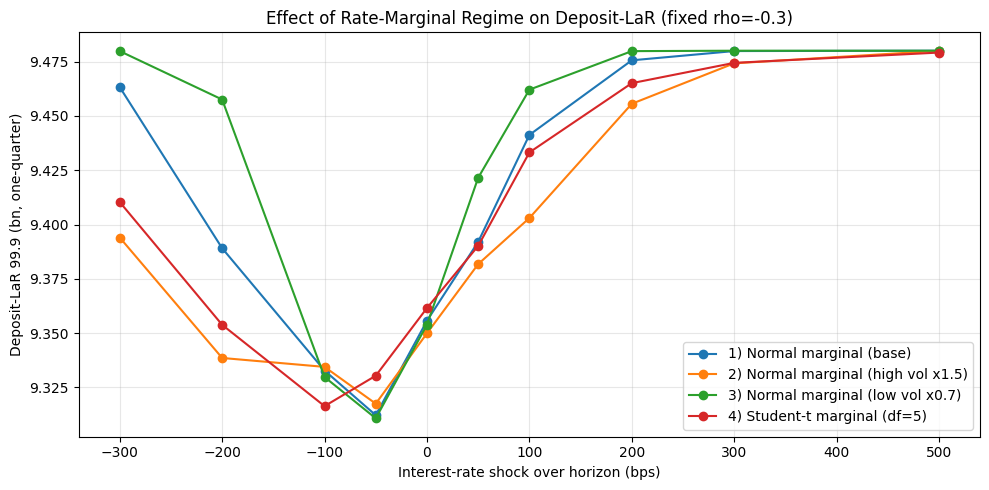

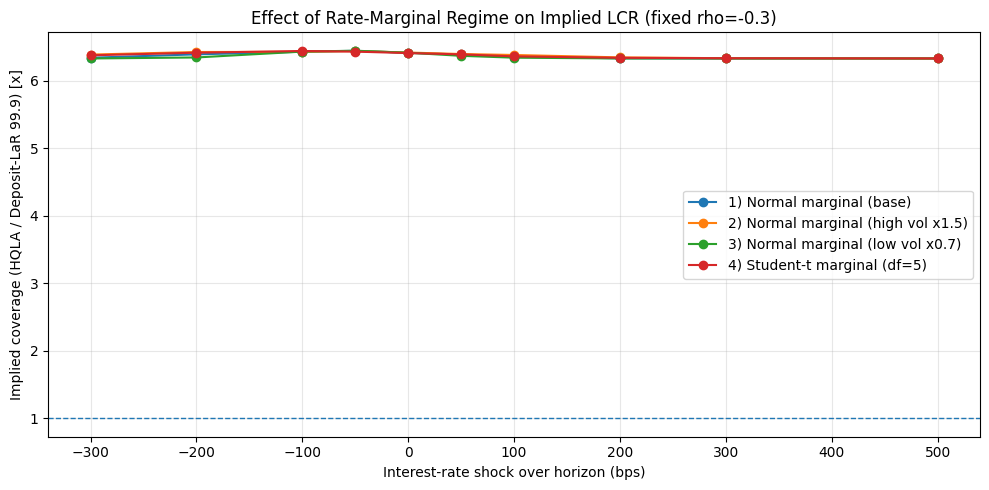

In [78]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# 0) USER KNOBS (synthetic)
# =========================================================
num_sim = 200_000
nu = 10
T_horizon = 0.25  # quarter horizon
shock_grid_bps = np.array([-300, -200, -100, -50, 0, 50, 100, 200, 300, 500])
alpha_999 = 0.999
eps = 1e-8
rng = np.random.default_rng(42)

# FIXED copula dependence (set what you want to demonstrate)
rho_fixed = -0.30   # <--- moderate negative dependence (your call)
print("Using fixed t-copula correlation rho =", rho_fixed)

# Synthetic balance sheet "model numbers"
D0_bn   = 300.0   # deposits (bn)
HQLA_bn =  60.0   # HQLA (bn)
D0_th   = D0_bn * 1e6  # keep your convention: "thousands" internally

# =========================================================
# 1) Synthetic deposit-flow marginal (historical sample)
#    (this is only for the empirical quantile of flows)
# =========================================================
n_hist = 120  # ~30 years of quarters

# Heavy-tailed, slightly left-skewed quarterly deposit flows
x_hist = 0.003 + 0.01 * stats.t.rvs(df=5, size=n_hist, random_state=rng)
x_hist = np.clip(x_hist, -0.20, 0.20)  # guardrails

def deposit_quantile(u):
    # empirical marginal for flows
    return np.quantile(x_hist, u)

# =========================================================
# 2) Conditional sampler: Tx | Ty=ty for bivariate t-copula
# =========================================================
def sample_t_conditional_x_given_y(ty, rho, nu, size, rng):
    df_cond = nu + 1
    mu_cond = rho * ty
    scale2  = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale   = np.sqrt(scale2)
    return mu_cond + scale * stats.t.rvs(df=df_cond, size=size, random_state=rng)

# =========================================================
# 3) Rate marginal modules (swap regimes)
# =========================================================
def vasicek_marginal_params(r0, a, b, sigma, T):
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return float(m_T), float(np.sqrt(v_T))

def u_y_from_rate_normal(rT_star, m_T, std_T):
    return float(np.clip(stats.norm.cdf(rT_star, loc=m_T, scale=std_T), eps, 1 - eps))

def u_y_from_rate_student_t(rT_star, m_T, std_T, df_rate=5):
    z = (rT_star - m_T) / max(std_T, 1e-12)
    return float(np.clip(stats.t.cdf(z, df=df_rate), eps, 1 - eps))

# =========================================================
# 4) Scenario engine: compute LaR99.9 + implied LCR99.9 vs shock
# =========================================================
def run_shock_curve(rate_u_cdf_func, rate_params, rho_t=rho_fixed):
    LaR_999_list, LCR_999_list = [], []

    r0_local = rate_params["r0"]

    for shock_bps in shock_grid_bps:
        shock = shock_bps / 10_000.0  # bps -> decimal
        rT_star = r0_local + shock

        # map rate level -> copula uniform -> latent Ty
        u_y_star = rate_u_cdf_func(rT_star, **rate_params)
        t_y_star = float(stats.t.ppf(u_y_star, df=nu))

        # conditional latent Tx | Ty
        t_x_cond = sample_t_conditional_x_given_y(t_y_star, rho_t, nu, num_sim, rng)

        # back to uniforms on X
        u_x_cond = stats.t.cdf(t_x_cond, df=nu)
        u_x_cond = np.clip(u_x_cond, eps, 1 - eps)

        # map to deposit flows (quarterly)
        flow_sim = deposit_quantile(u_x_cond)

        # flow -> outflow (one-quarter), bn
        D1_th = D0_th * (1.0 + flow_sim)
        outflow_th = np.maximum(D0_th - D1_th, 0.0)
        outflow_bn = outflow_th / 1e6

        lar999 = float(np.quantile(outflow_bn, alpha_999))
        LaR_999_list.append(lar999)
        LCR_999_list.append(HQLA_bn / lar999 if lar999 > 0 else np.inf)

    return np.array(LaR_999_list), np.array(LCR_999_list)

# =========================================================
# 5) Define rate-model regimes (all in DECIMALS)
# =========================================================
r0 = 0.040   # 4.0%
a  = 1.20
b  = 0.035
sigma = 0.020  # 2% vol per sqrt(year)

m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

rate_models = {
    "1) Normal marginal (base)": dict(r0=r0, m_T=m_T, std_T=std_T),
    "2) Normal marginal (high vol x1.5)": dict(r0=r0, m_T=m_T, std_T=1.5 * std_T),
    "3) Normal marginal (low vol x0.7)": dict(r0=r0, m_T=m_T, std_T=0.7 * std_T),
    "4) Student-t marginal (df=5)": dict(r0=r0, m_T=m_T, std_T=std_T, df_rate=5),
}

results = {}
for name, params in rate_models.items():
    if "df_rate" in params:
        lar999, lcr999 = run_shock_curve(
            lambda rT_star, r0, m_T, std_T, df_rate: u_y_from_rate_student_t(rT_star, m_T, std_T, df_rate),
            params,
            rho_t=rho_fixed
        )
    else:
        lar999, lcr999 = run_shock_curve(
            lambda rT_star, r0, m_T, std_T: u_y_from_rate_normal(rT_star, m_T, std_T),
            params,
            rho_t=rho_fixed
        )
    results[name] = dict(lar999=lar999, lcr999=lcr999)

# =========================================================
# 6) Plots
# =========================================================
plt.figure(figsize=(10, 5))
for name, out in results.items():
    plt.plot(shock_grid_bps, out["lar999"], marker="o", label=name)
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Deposit-LaR 99.9 (bn, one-quarter)")
plt.title(f"Effect of Rate-Marginal Regime on Deposit-LaR (fixed rho={rho_fixed})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for name, out in results.items():
    plt.plot(shock_grid_bps, out["lcr999"], marker="o", label=name)
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Implied coverage (HQLA / Deposit-LaR 99.9) [x]")
plt.title(f"Effect of Rate-Marginal Regime on Implied LCR (fixed rho={rho_fixed})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Unconditional LaR99, LaR99.9: 8.73911153151418 9.420382966272555
Unconditional implied LCR99, LCR99.9: 6.865686492686759 6.369167815662671


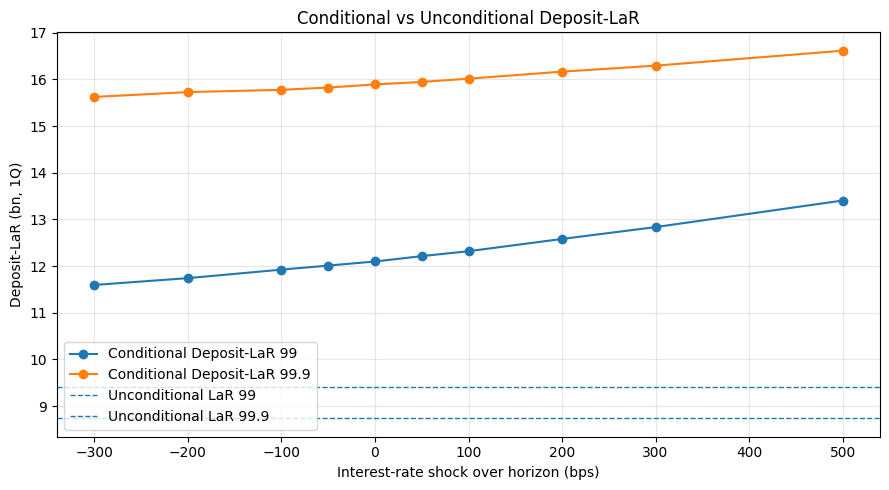

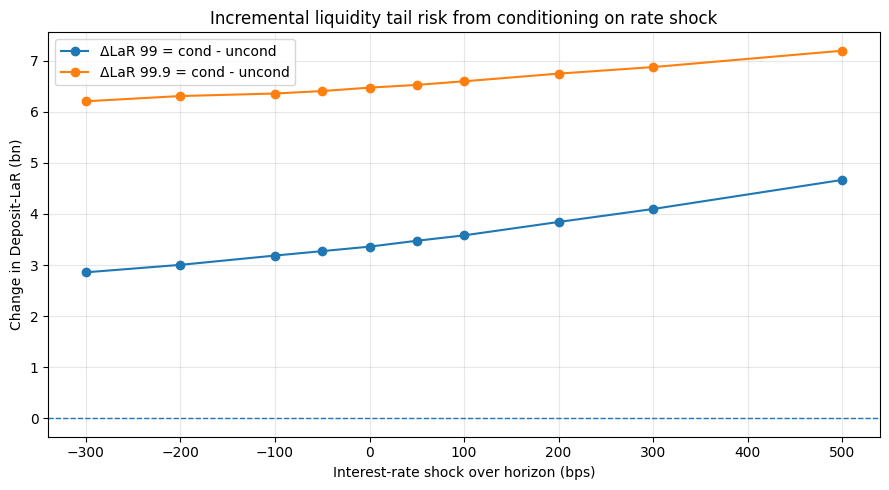

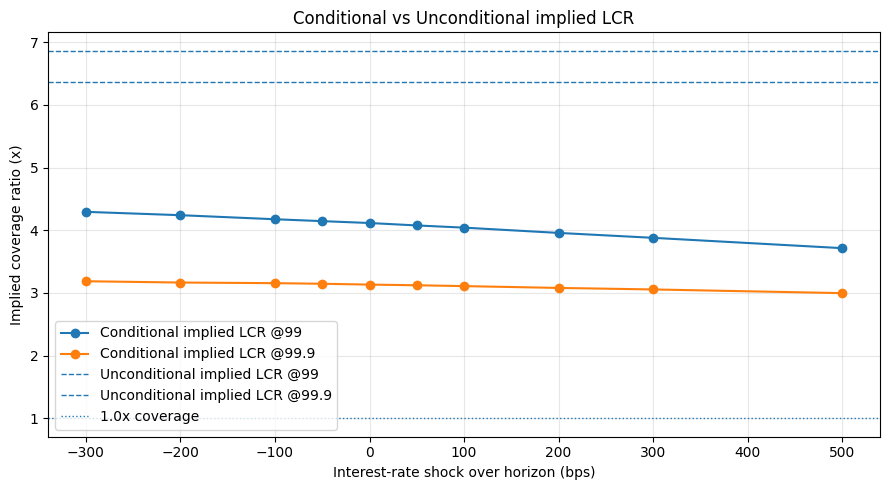

In [76]:
# =========================================================
# Unconditional Deposit-LaR baseline (same copula rho, same deposit marginal)
# This does NOT condition on any rate shock. It uses the copula marginal Ty ~ t_nu.
# =========================================================
def unconditional_LaR(num_sim, rho, nu, deposit_quantile, D0_th, alpha_levels=(0.99, 0.999), rng=None, eps=1e-8):
    if rng is None:
        rng = np.random.default_rng(0)

    # Sample Ty from its copula marginal (t with df=nu)
    t_y = stats.t.rvs(df=nu, size=num_sim, random_state=rng)

    # Sample Tx | Ty (preserves dependence with rho)
    t_x = sample_t_conditional_x_given_y(t_y, rho, nu, num_sim, rng)

    # Map Tx -> Ux -> flows
    u_x = stats.t.cdf(t_x, df=nu)
    u_x = np.clip(u_x, eps, 1 - eps)
    flow = deposit_quantile(u_x)

    # Flow -> outflow
    D1_th = D0_th * (1.0 + flow)
    outflow_th = np.maximum(D0_th - D1_th, 0.0)
    outflow_bn = outflow_th / 1e6

    lars = [float(np.quantile(outflow_bn, a)) for a in alpha_levels]
    return lars  # [LaR99, LaR99.9]

lar99_u, lar999_u = unconditional_LaR(
    num_sim=num_sim,
    rho=rho_t_hat,          # or your chosen rho sensitivity value
    nu=nu,
    deposit_quantile=deposit_quantile,
    D0_th=D0_th,
    alpha_levels=(alpha_99, alpha_999),
    rng=np.random.default_rng(123),
    eps=eps
)

lcr99_u  = HQLA_bn / lar99_u  if lar99_u  > 0 else np.inf
lcr999_u = HQLA_bn / lar999_u if lar999_u > 0 else np.inf

print("Unconditional LaR99, LaR99.9:", lar99_u, lar999_u)
print("Unconditional implied LCR99, LCR99.9:", lcr99_u, lcr999_u)

# (A) LaR vs shock + unconditional baseline
plt.figure(figsize=(9, 5))
plt.plot(shock_grid_bps, LaR_99, marker="o", label="Conditional Deposit-LaR 99")
plt.plot(shock_grid_bps, LaR_999, marker="o", label="Conditional Deposit-LaR 99.9")
plt.axhline(lar99_u,  linestyle="--", linewidth=1, label="Unconditional LaR 99")
plt.axhline(lar999_u, linestyle="--", linewidth=1, label="Unconditional LaR 99.9")
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Deposit-LaR (bn, 1Q)")
plt.title("Conditional vs Unconditional Deposit-LaR")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (B) Delta LaR plot (this is the money chart)
plt.figure(figsize=(9, 5))
plt.plot(shock_grid_bps, LaR_99 - lar99_u, marker="o", label="ΔLaR 99 = cond - uncond")
plt.plot(shock_grid_bps, LaR_999 - lar999_u, marker="o", label="ΔLaR 99.9 = cond - uncond")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Change in Deposit-LaR (bn)")
plt.title("Incremental liquidity tail risk from conditioning on rate shock")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (C) Implied LCR vs shock + unconditional baseline
plt.figure(figsize=(9, 5))
plt.plot(shock_grid_bps, LCR_99, marker="o", label="Conditional implied LCR @99")
plt.plot(shock_grid_bps, LCR_999, marker="o", label="Conditional implied LCR @99.9")
plt.axhline(lcr99_u,  linestyle="--", linewidth=1, label="Unconditional implied LCR @99")
plt.axhline(lcr999_u, linestyle="--", linewidth=1, label="Unconditional implied LCR @99.9")
plt.axhline(1.0, linestyle=":", linewidth=1, label="1.0x coverage")
plt.xlabel("Interest-rate shock over horizon (bps)")
plt.ylabel("Implied coverage ratio (x)")
plt.title("Conditional vs Unconditional implied LCR")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

n obs: 86
rho_t: -0.28728727687067757
UNCONDITIONAL Deposit-LaR 99:   13.26 bn
UNCONDITIONAL Deposit-LaR 99.9: 16.88 bn


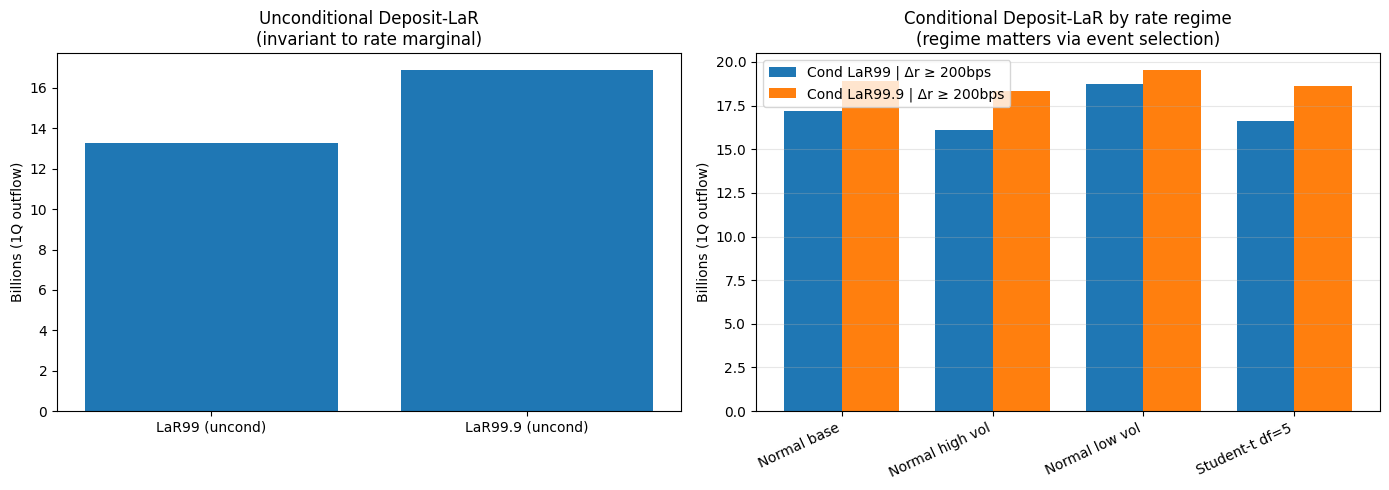

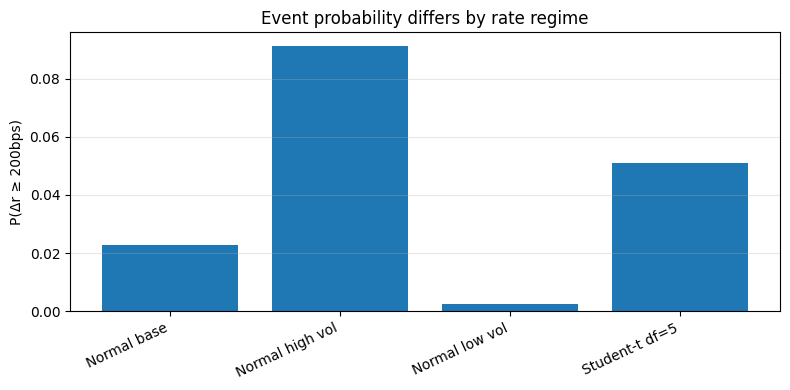

In [84]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# =========================================================
# USER KNOBS
# =========================================================
num_sim = 500_000
nu = 10
eps = 1e-8
rng = np.random.default_rng(42)

alpha_99  = 0.99
alpha_999 = 0.999

# Condition event: quarterly rate change >= +200 bps
k_bps = 200
k = k_bps / 10_000.0

# =========================================================
# 1) Fit t-copula on historical (flow_total, fedfunds_change)
# =========================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()
x_hist = df["flow_total"].to_numpy()
y_hist = df["fedfunds_change"].to_numpy()
n = len(df)

u_x = (stats.rankdata(x_hist, method="average") - 0.5) / n
u_y = (stats.rankdata(y_hist, method="average") - 0.5) / n
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)
rho_t = float(np.corrcoef(t_x, t_y)[0, 1])

print("n obs:", n)
print("rho_t:", rho_t)

# =========================================================
# 2) Simulate (U_x, U_y) from the fitted t-copula
#    (this part is independent of rate marginal choice)
# =========================================================
def sample_bivariate_t_copula_u(rho, nu, size, rng):
    # sample bivariate t with correlation rho, df=nu, then map to uniforms via t-CDF
    g = rng.standard_normal(size=(size, 2))
    L = np.linalg.cholesky(np.array([[1.0, rho], [rho, 1.0]]))
    z = g @ L.T
    w = rng.chisquare(df=nu, size=size)
    t = z / np.sqrt(w / nu)[:, None]
    u = stats.t.cdf(t, df=nu)
    return np.clip(u[:, 0], eps, 1 - eps), np.clip(u[:, 1], eps, 1 - eps)

u_x_sim, u_y_sim = sample_bivariate_t_copula_u(rho_t, nu, num_sim, rng)

# =========================================================
# 3) Deposit-flow marginal: map U_x -> flow
#    Use your semi-parametric marginal if you have it; otherwise empirical.
# =========================================================
def flow_from_u(u):
    # Option A: semi-parametric (recommended for tails)
    return semiparam_flow_ppf(u)

    # Option B: empirical
    # return np.quantile(x_hist, u)

flow_sim = flow_from_u(u_x_sim)

# =========================================================
# 4) Convert flows to outflows using latest deposits (bn)
# =========================================================
latest = panel.sort_values("report_date").iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands
D0_bn = D0_th / 1e6

HQLA_th = (
    float(latest["cash_and_balances"])
    + float(latest["interest_bearing_balances"])
    + float(latest["securities_afs_total"])
)
HQLA_bn = HQLA_th / 1e6

D1_th = D0_th * (1.0 + flow_sim)
outflow_th = np.maximum(D0_th - D1_th, 0.0)
outflow_bn = outflow_th / 1e6

def lar_stats(x_bn):
    lar99  = float(np.quantile(x_bn, alpha_99))
    lar999 = float(np.quantile(x_bn, alpha_999))
    lcr99  = HQLA_bn / lar99  if lar99  > 0 else np.inf
    lcr999 = HQLA_bn / lar999 if lar999 > 0 else np.inf
    return lar99, lar999, lcr99, lcr999

# Unconditional (this will NOT depend on the rate marginal)
lar99_u, lar999_u, lcr99_u, lcr999_u = lar_stats(outflow_bn)

print(f"UNCONDITIONAL Deposit-LaR 99:   {lar99_u:.2f} bn")
print(f"UNCONDITIONAL Deposit-LaR 99.9: {lar999_u:.2f} bn")

# =========================================================
# 5) Define rate-marginal regimes (these ONLY change y_sim values)
#    We map U_y -> delta_r via inverse CDF of the chosen marginal.
# =========================================================
def inv_cdf_rate_normal(u, mu, sigma):
    return stats.norm.ppf(u, loc=mu, scale=sigma)

def inv_cdf_rate_student_t(u, mu, sigma, df_rate):
    # standard t then scale/shift
    return mu + sigma * stats.t.ppf(u, df=df_rate)

# Example regime specs (quarterly delta_r units, decimals)
rate_regimes = {
    "Normal base":         dict(kind="normal",  mu=0.0000, sigma=0.0100),
    "Normal high vol":     dict(kind="normal",  mu=0.0000, sigma=0.0150),
    "Normal low vol":      dict(kind="normal",  mu=0.0000, sigma=0.0070),
    "Student-t df=5":      dict(kind="t",       mu=0.0000, sigma=0.0100, df_rate=5),
}

# =========================================================
# 6) For each regime:
#    - map U_y -> delta_r_sim
#    - compute conditional Deposit-LaR given delta_r >= k
#    Note: unconditional Deposit-LaR is same for all regimes (by copula logic).
# =========================================================
rows = []
for name, p in rate_regimes.items():
    if p["kind"] == "normal":
        dr_sim = inv_cdf_rate_normal(u_y_sim, p["mu"], p["sigma"])
    else:
        dr_sim = inv_cdf_rate_student_t(u_y_sim, p["mu"], p["sigma"], p["df_rate"])

    mask = dr_sim >= k
    p_event = mask.mean()

    if mask.sum() < 200:
        # if event is too rare at your simulation size, increase num_sim
        lar99_c = np.nan
        lar999_c = np.nan
        lcr99_c = np.nan
        lcr999_c = np.nan
    else:
        lar99_c, lar999_c, lcr99_c, lcr999_c = lar_stats(outflow_bn[mask])

    rows.append((name, p_event, lar99_c, lar999_c, lcr99_c, lcr999_c))

# =========================================================
# 7) Plot: (A) Unconditional (single bar) + (B) Conditional by regime
# =========================================================
labels = [r[0] for r in rows]
p_events = np.array([r[1] for r in rows])
lar99_c  = np.array([r[2] for r in rows])
lar999_c = np.array([r[3] for r in rows])

xpos = np.arange(len(labels))
w = 0.38

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# (A) Unconditional is invariant: show as a reference bar pair
ax[0].bar(["LaR99 (uncond)", "LaR99.9 (uncond)"], [lar99_u, lar999_u])
ax[0].set_ylabel("Billions (1Q outflow)")
ax[0].set_title("Unconditional Deposit-LaR\n(invariant to rate marginal)")

# (B) Conditional LaR by regime
ax[1].bar(xpos - w/2, lar99_c,  width=w, label=f"Cond LaR99 | Δr ≥ {k_bps}bps")
ax[1].bar(xpos + w/2, lar999_c, width=w, label=f"Cond LaR99.9 | Δr ≥ {k_bps}bps")
ax[1].set_xticks(xpos)
ax[1].set_xticklabels(labels, rotation=25, ha="right")
ax[1].set_ylabel("Billions (1Q outflow)")
ax[1].set_title("Conditional Deposit-LaR by rate regime\n(regime matters via event selection)")
ax[1].legend()
ax[1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: show event probabilities (why regimes differ)
plt.figure(figsize=(8,4))
plt.bar(labels, p_events)
plt.xticks(rotation=25, ha="right")
plt.ylabel(f"P(Δr ≥ {k_bps}bps)")
plt.title("Event probability differs by rate regime")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()